In [1]:
import numpy as np 
import pandas as pd
from hmmlearn import hmm
from matplotlib import pyplot as plt
import seaborn as sbn
from matplotlib.patches import Ellipse
import umap
import pickle as pkl
import networkx as nx
import tsfel
from sklearn import decomposition

from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# Overview 


This is a template analysis notebook, it is suggested that you make a copy of this file and then change the data and methods as desired. 

We will implement three analysis: 

1. Hidden Markov Model 

2. Time Series Feature Extraction 

3. Pathway correllation analysis 


TODO: (**HIGH**) Descroptions and slide deck for presentation with samuel.   
TODO: Use different dataset/experiment for comparison 


# Load Data 

The data should be in `pickle` form. For more info, see the relevant `data_org.ipynb` notebooks. 

In [2]:
with open('../data/HEK8.pkl', 'rb') as f: 
    data = pkl.load(f)
data.head()

track_index  cdk2_time(h)=0.0  \
0  81_1000189001_heya8_cdk2_mdmx__untreated          0.996649   
1  86_1000215388_heya8_cdk2_mdmx__untreated          0.995417   
2  83_1000195542_heya8_cdk2_mdmx__untreated          0.994308   
3  73_1000149946_heya8_cdk2_mdmx__untreated          0.988188   
4  81_1000187465_heya8_cdk2_mdmx__untreated          0.967397   

   cdk2_time(h)=0.2  cdk2_time(h)=0.5  cdk2_time(h)=0.8  cdk2_time(h)=1.0  \
0          0.995112          0.993575          0.992038          0.990501   
1          0.295146          0.366373          0.333625          0.412077   
2          0.968303          0.904938          0.900423          0.922883   
3          0.992811          0.982868          0.972926          0.962983   
4          0.728514          0.911879          0.567794          0.528236   

   cdk2_time(h)=1.2  cdk2_time(h)=1.5  cdk2_time(h)=1.8  cdk2_time(h)=2.0  \
0          0.969413          0.948325          0.927237          0.906149   
1          0.411844          0.423543          0.397102          0.861592   
2          0.859205          0.940154          0.887254          0.834353   
3          0.951770          0.967916          0.831321          0.856759   
4          0.560685          0.857484          0.982574          0.896957   

   ...  mdmx_time(h)=21.0  mdmx_time(h)=21.2  mdmx_time(h)=21.5  mdmx_site  \
0  ...           0.082932           0.263016           0.209343         81   
1  ...           0.363932           0.313662           0.263392         86   
2  ...           0.149599           0.173044           0.320218         83   
3  ...           0.038332           0.059854           0.045033         73   
4  ...           0.123079           0.168578           0.314991         81   

   mdmx_median   start_y  conc_nm  inhibitor  cell_line  cell_viab  
0     0.145431  0.124073        0  untreated      heya8        NaN  
1     0.230868  0.427603        0  untreated      heya8        NaN  
2     0.144564  0.264669        0  untreated      heya8        NaN  
3     0.130409  0.027369        0  untreated      heya8        NaN  
4     0.169868  0.580908        0  untreated      heya8        NaN  

[5 rows x 186 columns]

# Config. Parameters 

In [3]:
# HMM params 
nstates = 25
niter   = 40

# Data Visualization 

Detecting cycles in time series 
https://github.com/oemof/cydets

There should be a cell division cycle we can see in this... right? 

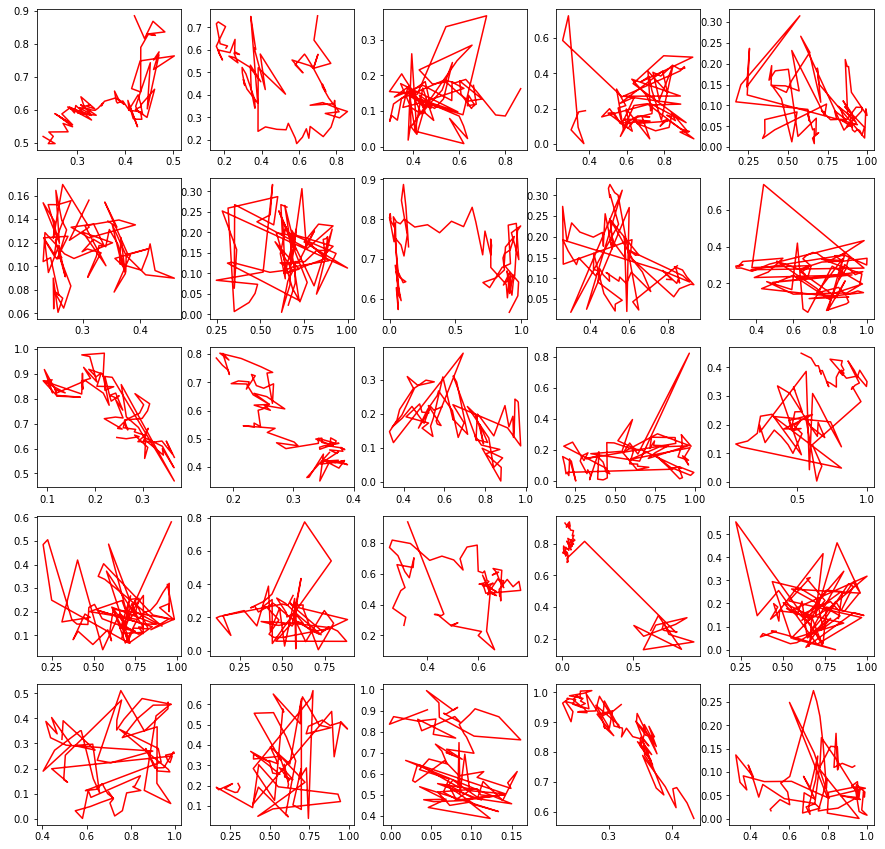

In [4]:
f, axes = plt.subplots(5,5, figsize=(15,15))
for i,row in data.sample(25).reset_index().iterrows(): 
    __x = row[data.attrs['clover_selector']]
    __y = row[data.attrs['mscarlet_selector']]
    axes.flat[i].plot(__x, __y, 'r-', alpha=1)

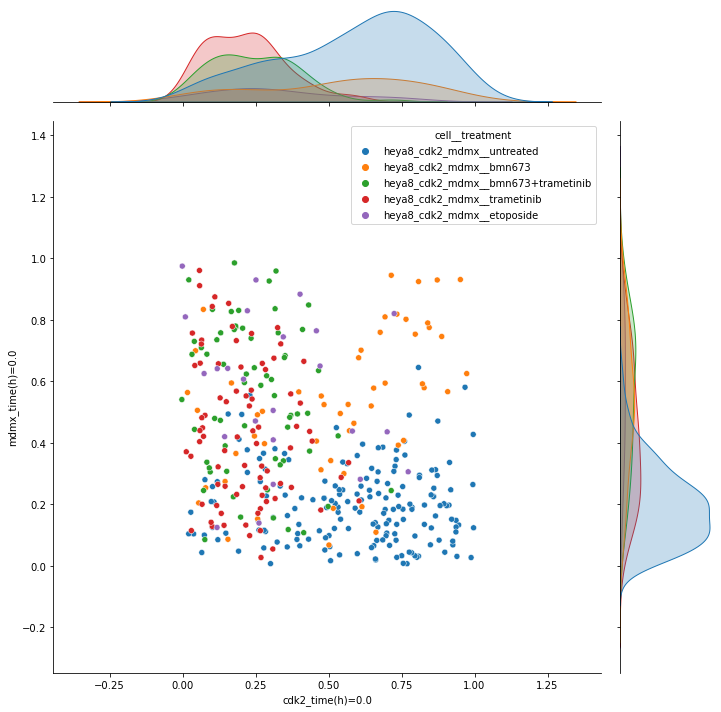

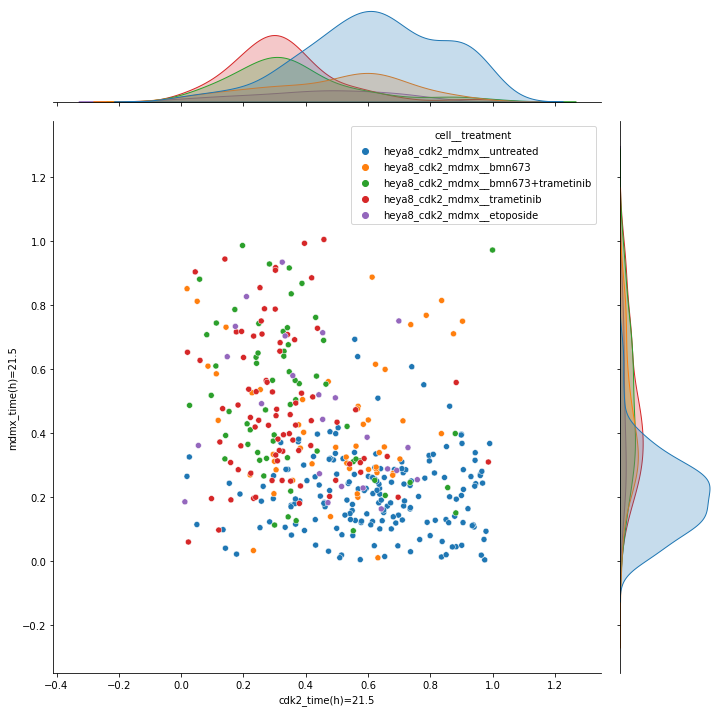

In [103]:
sbn.jointplot(x=data.attrs['clover_selector'][0], y=data.attrs['mscarlet_selector'][0], hue='cell__treatment', data=data, ax=axes[0], height=10)
sbn.jointplot(x=data.attrs['clover_selector'][-1], y=data.attrs['mscarlet_selector'][-1], hue='cell__treatment', data=data, ax=axes[1], height=10)


# Analysis 1: Hidden Markov Model (HMM)

HMM using [this](https://hmmlearn.readthedocs.io/en/latest/) package. 

The base HMM will be trained from unperturbed treatment group. 

Alternatively, [this](https://pomegranate.readthedocs.io/en/latest/HiddenMarkovModel.html) is another option <- significantly faster training, parrellization and more flexible. 

In [5]:
def form_data(df): 
    # https://hmmlearn.readthedocs.io/en/latest/tutorial.html#multiple-sequences
    X = np.concatenate((df[df.attrs['clover_selector']].values.reshape(-1, len(df.attrs['clover_selector']), 1), 
                        df[df.attrs['mscarlet_selector']].values.reshape(-1, len(df.attrs['clover_selector']), 1)), 
                       axis=2)
    
    _lens = [X.shape[1]]*X.shape[0]
    X = X.reshape((-1, 2))
    
    print('shape:', X.shape)
    return X, _lens

In [6]:
data.cell__treatment.unique()

array(['heya8_cdk2_mdmx__untreated', 'heya8_cdk2_mdmx__bmn673',
       'heya8_cdk2_mdmx__bmn673+trametinib',
       'heya8_cdk2_mdmx__trametinib', 'heya8_cdk2_mdmx__etoposide'],
      dtype=object)

In [7]:
# https://hmmlearn.readthedocs.io/en/latest/tutorial.html#multiple-sequences
untreated = data[data.cell__treatment=='heya8_cdk2_mdmx__untreated']
X_untreated, untreated_lens = form_data(untreated)

shape: (15225, 2)


In [8]:
X, _lens = form_data(data)

shape: (34365, 2)


In [9]:
def get_HMM(X, lengths, nstates, niter, means=None, verbose=True): 
    
    if means is not None: 
        remodel = hmm.GaussianHMM(n_components=nstates, covariance_type="full", n_iter=niter, init_params='stc')
        remodel.means_ = means
    else: 
        remodel = hmm.GaussianHMM(n_components=nstates, covariance_type="full", n_iter=niter, init_params='mstc')

    # train 
    remodel.fit(X, lengths)
    if verbose: print('model converged:', remodel.monitor_.converged)

    return remodel 

# Check HMM convergence 

In [10]:
def plot_convergence_variance(X, lens, nruns=25, nstates=10, niter=5):

    _hmms_ = {'iter':[], 'clover':[], 'mscarlet':[]}
    for i in range(nruns):
        print('iter:', i, end='\r')
        _hmms_['iter'].append(i)
        h = get_HMM(X.copy(), lens.copy(), nstates=nstates, niter=niter, verbose=False)
        _hmms_['clover'].append( h.means_[:,0] ) 
        _hmms_['mscarlet'].append( h.means_[:,1] ) 
    _hmms_ = pd.DataFrame(_hmms_)

    plt.figure()
    for i,row in _hmms_.iterrows(): 
        plt.plot(row.clover, row.mscarlet, 'b.')
    plt.title(f'nruns={nruns} | nstates={nstates} | niter={niter}')
    plt.show()

In [11]:
#plot_convergence_variance(X_untreated, untreated_lens, nruns=25, nstates=20, niter=1)

In [12]:
#plot_convergence_variance(X_untreated, untreated_lens, nruns=25, nstates=20, niter=5)

In [13]:
#plot_convergence_variance(X_untreated, untreated_lens, nruns=25, nstates=20, niter=10)

# Train HMM

In [14]:
# init model
remodel = get_HMM(X_untreated, untreated_lens, nstates, niter)
#remodel = get_HMM(X, _lens, nstates, niter)

# get states 
Z2 = remodel.predict(X, _lens) # switch this to  X_untreated... ? 

model converged: True


In [15]:
# reshape to original observations 
z2 = Z2.reshape((-1, len(data.attrs['clover_selector'])))
z2.shape

(395, 87)

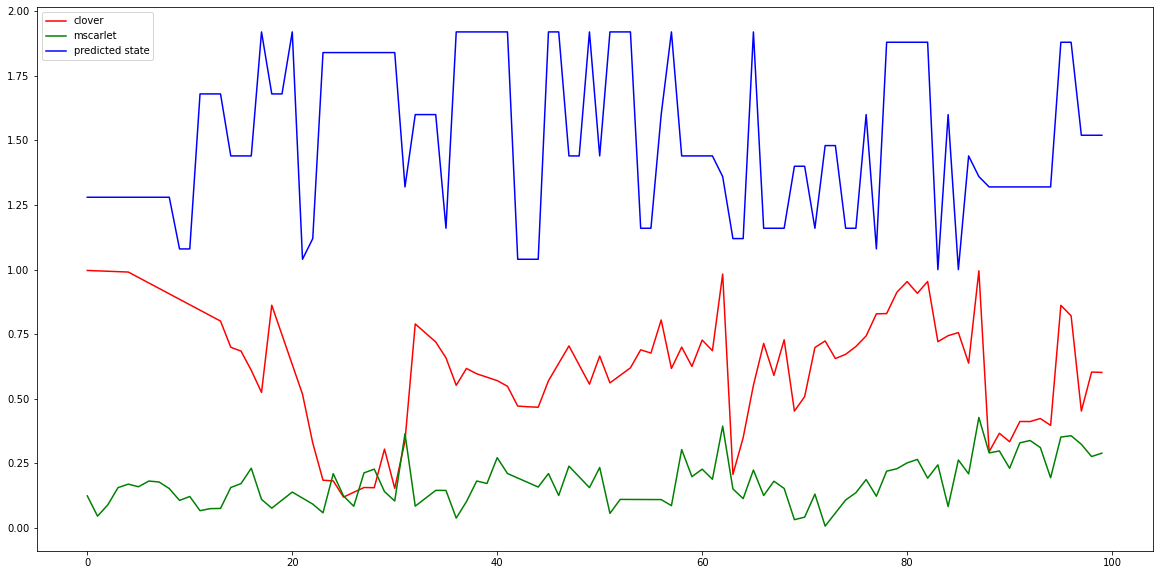

In [16]:
plt.figure(figsize=(20,10))
_n = 100
plt.plot(X[:_n, 0], 'r', label='clover')
plt.plot(X[:_n, 1], 'g', label='mscarlet')
plt.plot(Z2[:_n]/nstates + 1, 'b', label='predicted state')
plt.legend()

plt.show()

In [17]:
# create wide dataframe with track labesl 
res = pd.DataFrame(z2, columns=[float(x.split('=')[-1]) for x in data.attrs['clover_selector']])
res = res.assign(label=data.track_index)

# unstack time - long data
res = res.set_index('label').unstack().reset_index().rename({'level_0':'time', 0:'state'}, axis=1)
res.head()

time                                     label  state
0   0.0  81_1000189001_heya8_cdk2_mdmx__untreated      7
1   0.0  86_1000215388_heya8_cdk2_mdmx__untreated      9
2   0.0  83_1000195542_heya8_cdk2_mdmx__untreated     22
3   0.0  73_1000149946_heya8_cdk2_mdmx__untreated     24
4   0.0  81_1000187465_heya8_cdk2_mdmx__untreated     20

In [18]:
# count the # time points spent in each sate - for each time series (cell)
out = res.groupby(['label','state']).count().rename({'time':'count'},axis=1).reset_index().set_index('label').pivot(columns='state', values='count').reset_index()

# if a cell never occupies a state, then it is listed as na  -replace these as 0
out = out.fillna(0)

# assign treatments 
out = out.assign(cell__treatment= [x.split('_', 2)[-1] for x in out.label])

# rename states for convenience 
out = out.rename({x:f'state_{x}' for x in out.columns[1:-1]}, axis=1)

# init state_selector to grab relevant col later 
state_sel = out.columns[1:-1]

# merge cell_viab 
out = out.merge(data[['track_index', 'cell_viab']], left_on='label', right_on='track_index', how='left')
out.head()

label  state_0  state_1  \
0  100_1000249955_heya8_cdk2_mdmx__bmn673+trametinib      0.0      0.0   
1  101_1000251595_heya8_cdk2_mdmx__bmn673+trametinib      0.0      0.0   
2  101_1000252386_heya8_cdk2_mdmx__bmn673+trametinib      0.0      0.0   
3  102_1000253233_heya8_cdk2_mdmx__bmn673+trametinib      0.0      0.0   
4  102_1000253498_heya8_cdk2_mdmx__bmn673+trametinib      0.0      0.0   

   state_2  state_3  state_4  state_5  state_6  state_7  state_8  ...  \
0      0.0      0.0      0.0      0.0     53.0      0.0      0.0  ...   
1      0.0      0.0      0.0      0.0     68.0      0.0      2.0  ...   
2      0.0      0.0      0.0      0.0      0.0      0.0      0.0  ...   
3      0.0      0.0      0.0      0.0     34.0      0.0      4.0  ...   
4      0.0      0.0      0.0      0.0     87.0      0.0      0.0  ...   

   state_18  state_19  state_20  state_21  state_22  state_23  state_24  \
0      34.0       0.0       0.0       0.0       0.0       0.0       0.0   
1      17.0       0.0       0.0       0.0       0.0       0.0       0.0   
2      77.0       0.0       0.0       0.0       0.0       0.0       0.0   
3       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

                      cell__treatment  \
0  heya8_cdk2_mdmx__bmn673+trametinib   
1  heya8_cdk2_mdmx__bmn673+trametinib   
2  heya8_cdk2_mdmx__bmn673+trametinib   
3  heya8_cdk2_mdmx__bmn673+trametinib   
4  heya8_cdk2_mdmx__bmn673+trametinib   

                                         track_index  cell_viab  
0  100_1000249955_heya8_cdk2_mdmx__bmn673+trametinib        NaN  
1  101_1000251595_heya8_cdk2_mdmx__bmn673+trametinib        NaN  
2  101_1000252386_heya8_cdk2_mdmx__bmn673+trametinib        NaN  
3  102_1000253233_heya8_cdk2_mdmx__bmn673+trametinib        NaN  
4  102_1000253498_heya8_cdk2_mdmx__bmn673+trametinib        NaN  

[5 rows x 29 columns]

In [19]:
# make sure the counts for each state sum to the # time points ... 
out[state_sel].sum(axis=1).unique()

array([87.])

In [20]:
# calc total number of time series observations in each treatment group 
tot = out.groupby(['cell__treatment'])['label'].count().reset_index()
tot = tot.assign(label=lambda x: x.label*len(data.attrs['clover_selector'])) # account number of time points 

# calc total amount of time spent in each state within each treatment group 
cnts = out.groupby('cell__treatment').sum().reset_index()

# normalize 
norm_cnts = pd.DataFrame((cnts[state_sel].values.T/tot.label.values).T, columns=state_sel).assign(cell__treatment=cnts.cell__treatment)

In [21]:
# double check we calculated our probabilites properly 
#norm_cnts[state_sel].sum(axis=1)

## pca on proprotion in each state - treatment group viz 

In [22]:
# TODO: add variation plot for PC's 

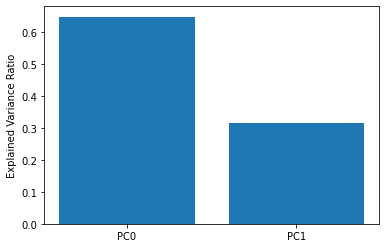

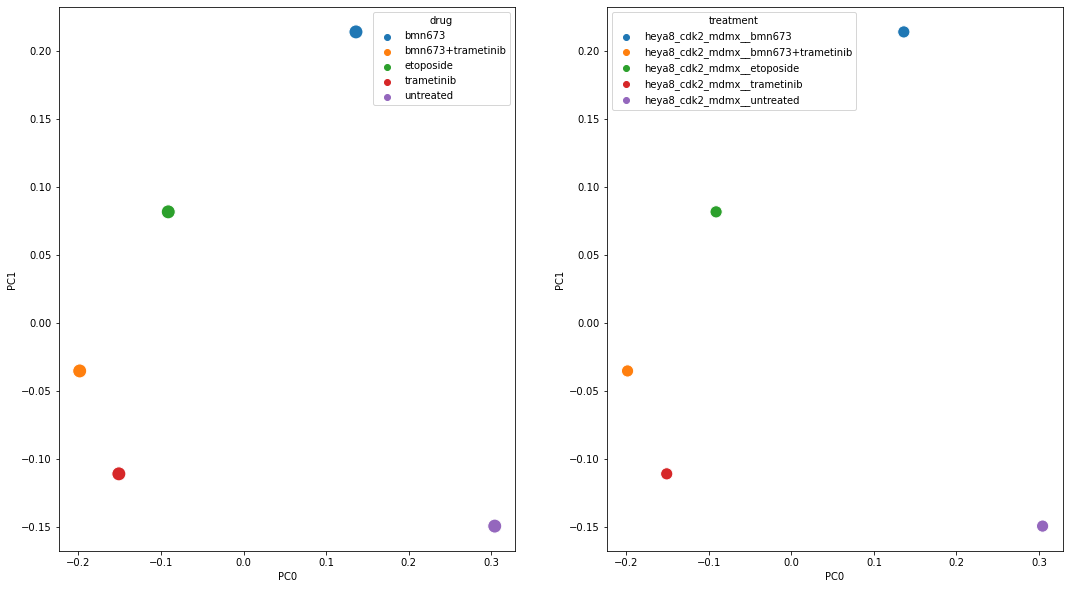

In [23]:
_X = norm_cnts[state_sel]

pca = decomposition.PCA(n_components=2)
pca.fit(_X)
_X2 = pca.transform(_X)

_df = pd.DataFrame(_X2, columns=['PC0', 'PC1']).assign(treatment=norm_cnts.cell__treatment)
_df = _df.assign(drug = [x.split('_')[-1] for x in norm_cnts.cell__treatment])

plt.figure()
plt.bar(height=pca.explained_variance_ratio_, x=['PC0', 'PC1'])
plt.ylabel('Explained Variance Ratio')
plt.show()

f, axes = plt.subplots(1,2, figsize=(18,10))
sbn.scatterplot(x='PC0', y='PC1', hue='drug', data=_df, ax=axes[0], s=200)
sbn.scatterplot(x='PC0', y='PC1', hue='treatment', data=_df, ax=axes[1], s=150)
plt.show()

# treatment group viz - all state prob

In [24]:
viz = norm_cnts.set_index('cell__treatment').unstack().reset_index().rename({0:'prob'}, axis=1)
viz.head()

state                     cell__treatment      prob
0  state_0             heya8_cdk2_mdmx__bmn673  0.007591
1  state_0  heya8_cdk2_mdmx__bmn673+trametinib  0.003102
2  state_0          heya8_cdk2_mdmx__etoposide  0.007663
3  state_0         heya8_cdk2_mdmx__trametinib  0.001293
4  state_0          heya8_cdk2_mdmx__untreated  0.043810

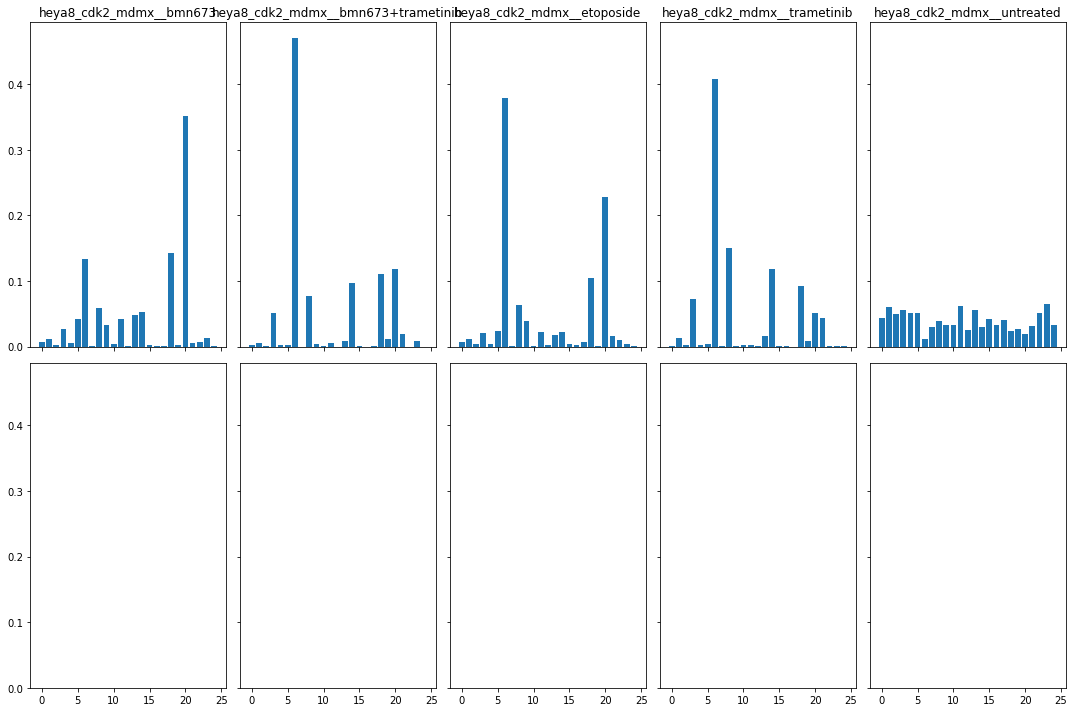

In [25]:
f, axes = plt.subplots(2,5, figsize=(15,10), sharex=True, sharey=True)
for i, row in norm_cnts.iterrows():
    x = row[state_sel].values
    axes.flat[i].bar(x=range(len(x)), height=x, label=row['cell__treatment'])
    axes.flat[i].set_title(row['cell__treatment'])
    
plt.tight_layout()
plt.show()

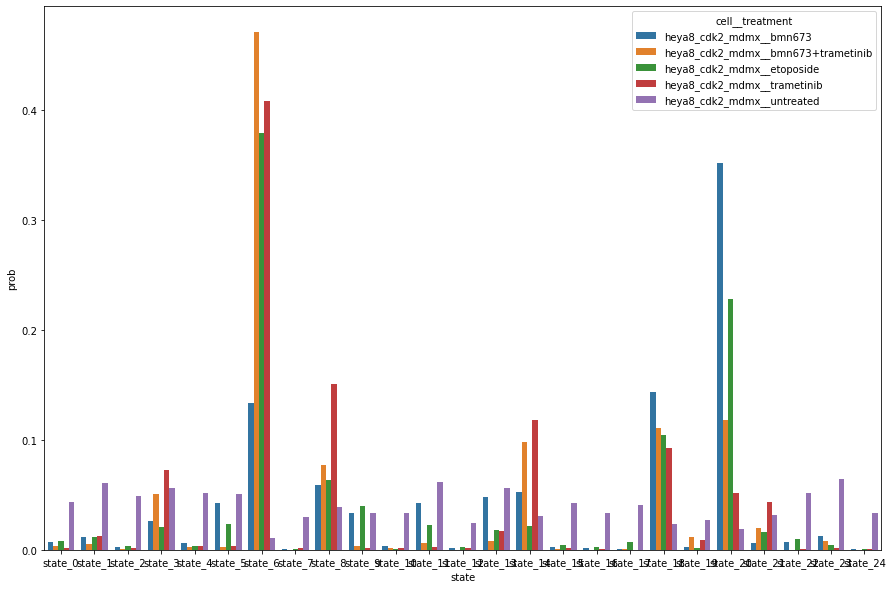

In [26]:
plt.figure(figsize=(15,10))
sbn.barplot(x='state', y='prob', hue='cell__treatment', data=viz)
plt.show()

# Which states are most common overall? 

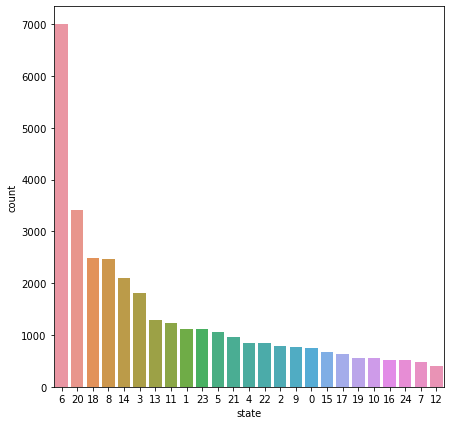

In [27]:
plt.figure(figsize=(7,7))
sbn.countplot(x='state', data=res, order=res.state.value_counts().index)
plt.show()

# Umap representation

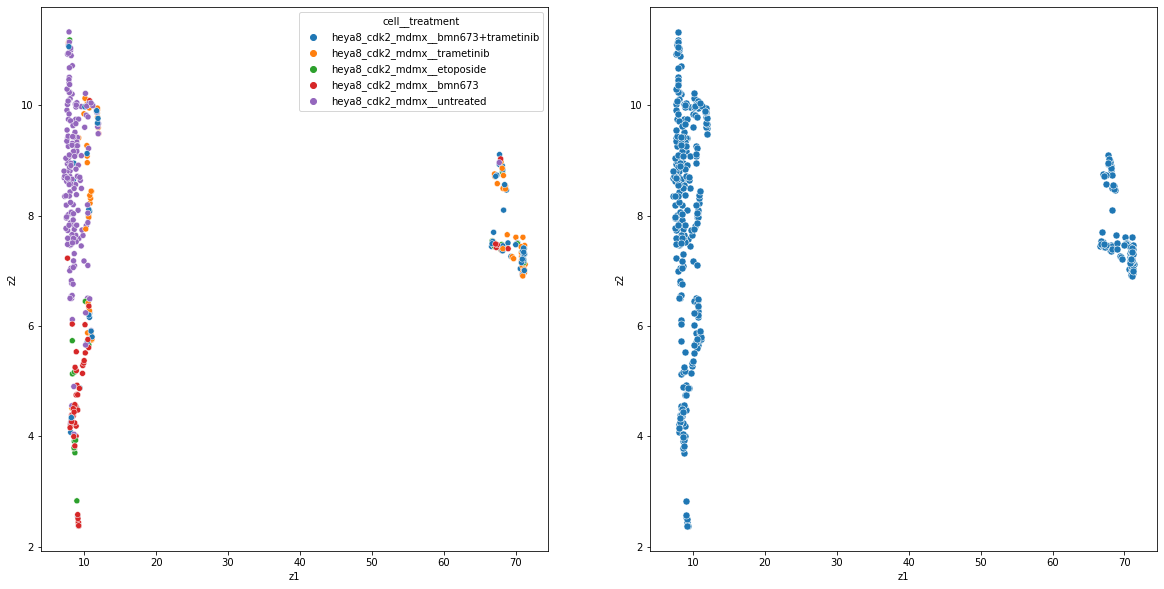

In [92]:
reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, n_components=2, metric='correlation')
embed = reducer.fit_transform(out[state_sel].values)

out = out.assign(z1=embed[:,0], z2=embed[:,1])

f,axes = plt.subplots(1,2,figsize=(20,10))
sbn.scatterplot(x='z1', y='z2', hue='cell__treatment', data=out, ax=axes[0])
sbn.scatterplot(x='z1', y='z2', hue='cell_viab', s=50, alpha=1, data=out, ax=axes[1])

plt.show()

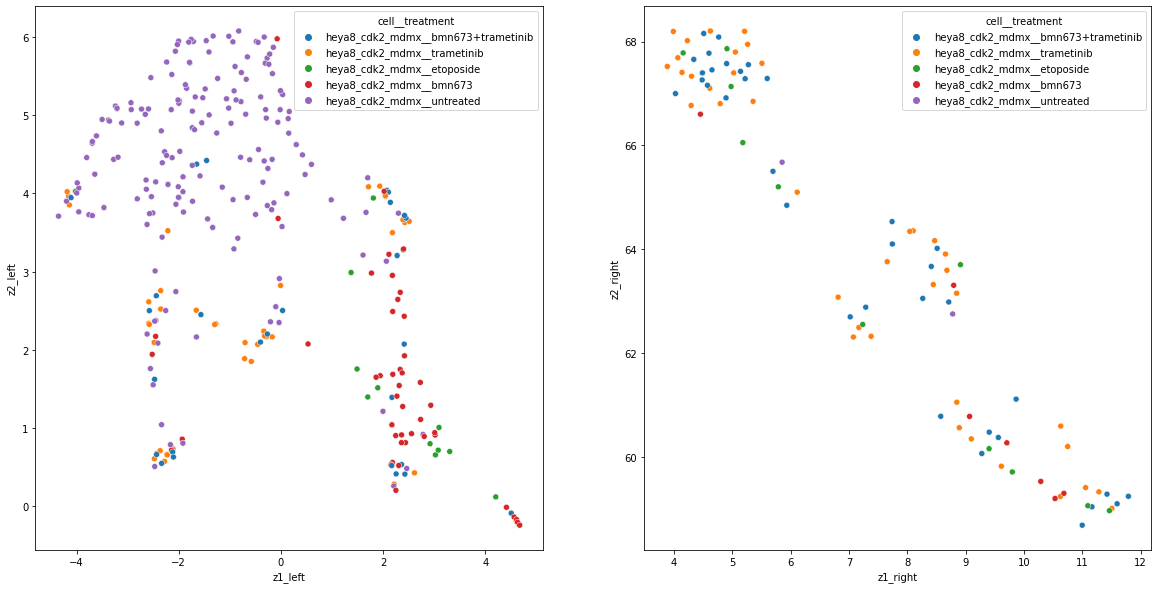

In [100]:
x_left = out[out.z1 < 30][state_sel].values

red_left = umap.UMAP(n_neighbors=30, min_dist=0.1, n_components=2, metric='correlation')
embed_left = red_left.fit_transform(x_left)

out_left = out[out.z1 < 30][['track_index', 'cell__treatment']].assign(z1_left=embed_left[:,0], z2_left=embed_left[:,1])

f,axes = plt.subplots(1,2,figsize=(20,10))
sbn.scatterplot(x='z1_left', y='z2_left', hue='cell__treatment', data=out_left, ax=axes[0])

x_right = out[out.z1 > 30][state_sel].values

red_right = umap.UMAP(n_neighbors=30, min_dist=0.1, n_components=2, metric='correlation')
embed_right = red_right.fit_transform(x_right)

out_right = out[out.z1 > 30][['track_index', 'cell__treatment']].assign(z1_right=embed_right[:,0], z2_right=embed_right[:,1])

sbn.scatterplot(x='z1_right', y='z2_right', hue='cell__treatment', data=out_right, ax=axes[1])


plt.show()

# Predict time-series  `treatment` from state probability 

We'll use this to understand the differences between treatment groups. e.g., what are the primary state differences between untreated and dasatinib? 

In [30]:
_X = out[state_sel].values
y = out.cell__treatment.values
print('class balance:')
_bal = {f'label={x}':y for x,y in zip(*np.unique(y,return_counts=True))}
_ = [print(f'\t{x} : {_bal[x]}') for x in _bal]

le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)

print('x shape: ', _X.shape)

class balance:
	label=heya8_cdk2_mdmx__bmn673 : 53
	label=heya8_cdk2_mdmx__bmn673+trametinib : 63
	label=heya8_cdk2_mdmx__etoposide : 24
	label=heya8_cdk2_mdmx__trametinib : 80
	label=heya8_cdk2_mdmx__untreated : 175
x shape:  (395, 25)


In [31]:
# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear", verbose=False, max_iter=-1, decision_function_shape='ovo', class_weight='balanced')
# The "accuracy" scoring is proportional to the number of correct
# classifications (because multi-class predictions)

min_features_to_select = 2  # Minimum number of features to consider
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(5),
              scoring='accuracy',
              min_features_to_select=min_features_to_select, verbose=False, n_jobs=8)
rfecv.fit(_X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 25


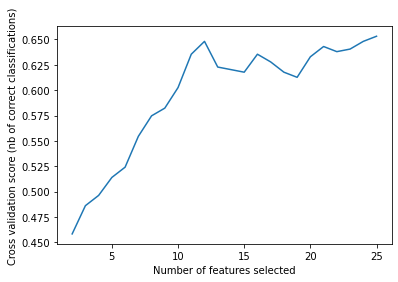

In [32]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(min_features_to_select,
               len(rfecv.grid_scores_) + min_features_to_select),
         rfecv.grid_scores_)
plt.show()

In [33]:
selected_feats = out.columns[[False] + list(rfecv.get_support()) + [False]*5]
print('selected features:', selected_feats)

selected features: Index(['state_0', 'state_1', 'state_2', 'state_3', 'state_4', 'state_5',
       'state_6', 'state_7', 'state_8', 'state_9', 'state_10', 'state_11',
       'state_12', 'state_13', 'state_14', 'state_15', 'state_16', 'state_17',
       'state_18', 'state_19', 'state_20', 'state_21', 'state_22', 'state_23',
       'state_24'],
      dtype='object')


In [34]:
_X2 = rfecv.transform(_X)

In [35]:
svc = SVC(kernel="linear", verbose=False, max_iter=-1, decision_function_shape='ovo', class_weight='balanced')

scores = cross_val_score(svc, _X2, y, cv=5)

print('cv acc:', np.mean(scores))
print('random:', 1/len(le.classes_))

cv acc: 0.6531645569620252
random: 0.2


In [36]:
classifier_labels = []
for i,c in enumerate(le.classes_): 
    for j,c2 in enumerate(le.classes_[(i+1):]): 
        classifier_labels.append(f'{c.split("__")[-1]}__VS__{c2.split("__")[-1]}')
#classifier_labels

train score 0.8


<Figure size 720x1080 with 0 Axes>

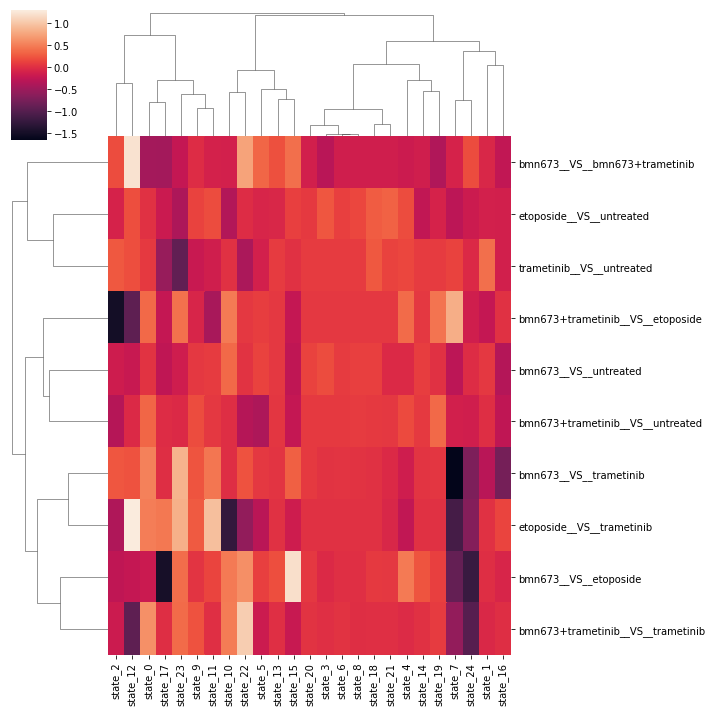

In [37]:
svc = SVC(kernel="linear", verbose=False, max_iter=-1, decision_function_shape='ovo', class_weight='balanced')
svc.fit(_X2, y)

# https://stackoverflow.com/questions/22816646/the-dimension-of-dual-coef-in-sklearn-svc
print('train score', svc.score(_X2, y))

plt.figure(figsize=(10,15))
sbn.clustermap(svc.coef_, xticklabels=selected_feats, yticklabels=classifier_labels, metric='correlation')
plt.show()

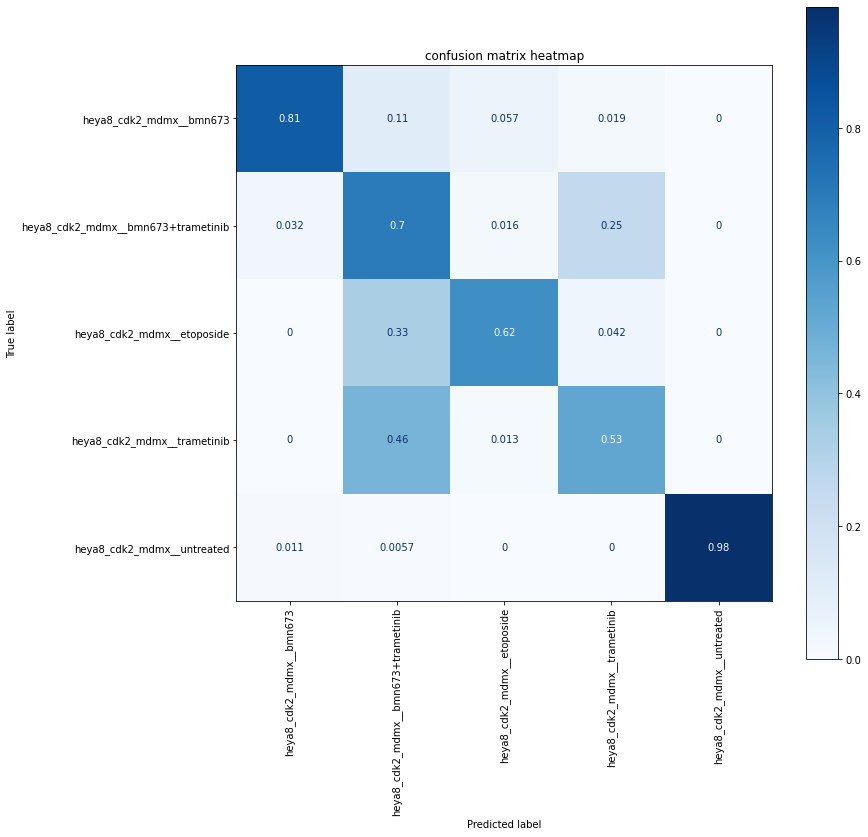

In [38]:
f,ax = plt.subplots(1,1,figsize=(12,12))
plot_confusion_matrix(svc, _X2, y, normalize='true',
                                 display_labels=le.classes_,
                                 cmap=plt.cm.Blues,
                                 ax=ax)
plt.xticks(rotation=90)
plt.title('confusion matrix heatmap')
plt.show()

# What does each state look like?

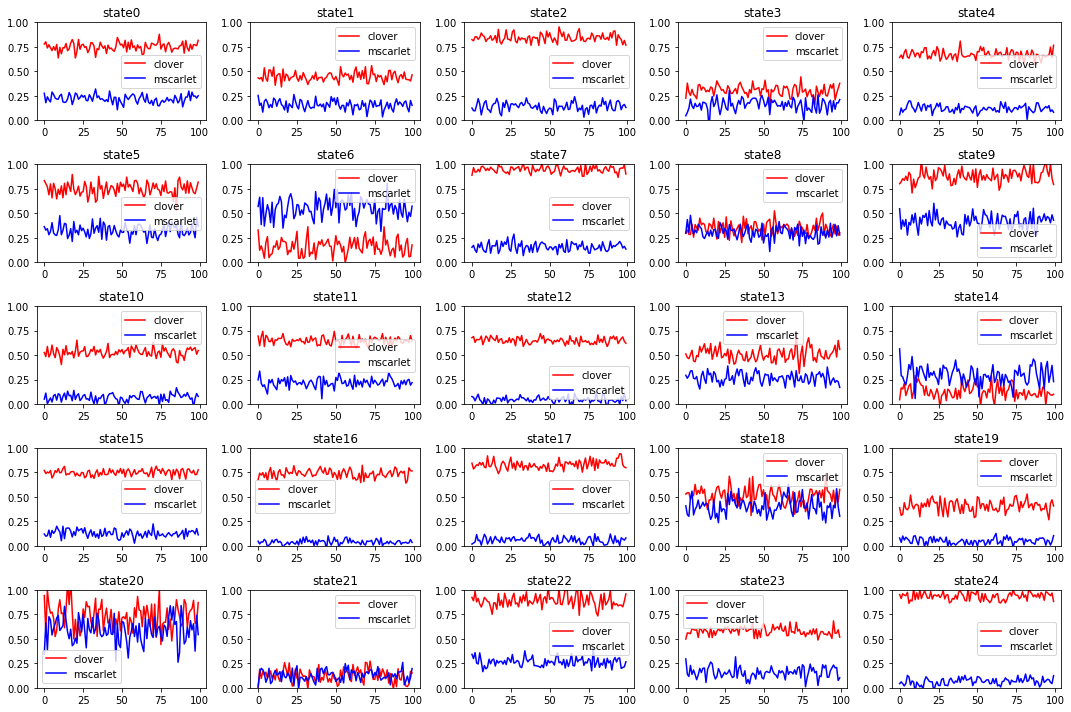

In [39]:
f, axes = plt.subplots(int(nstates/5),5, figsize=(15,10))
for i in range(remodel.n_components): 
    x = np.array([remodel._generate_sample_from_state(i) for x in range(100)])
    axes.flat[i].plot(x[:,0], 'r-', label='clover')
    axes.flat[i].plot(x[:, 1], 'b-', label='mscarlet')
    axes.flat[i].set_title('state' + str(i))
    axes.flat[i].set_ylim((0,1))
    axes.flat[i].legend()
plt.tight_layout()
plt.show()

# State transition matrix 

Which states do they jump between most commonly? 

### What is the self-transition probability? Do certain states stay in the same state? or are some states transient? 

Nodes appear to be prodominately uniform in self-transition probability, which makes sense as they are probably determined by the pathway score density. 

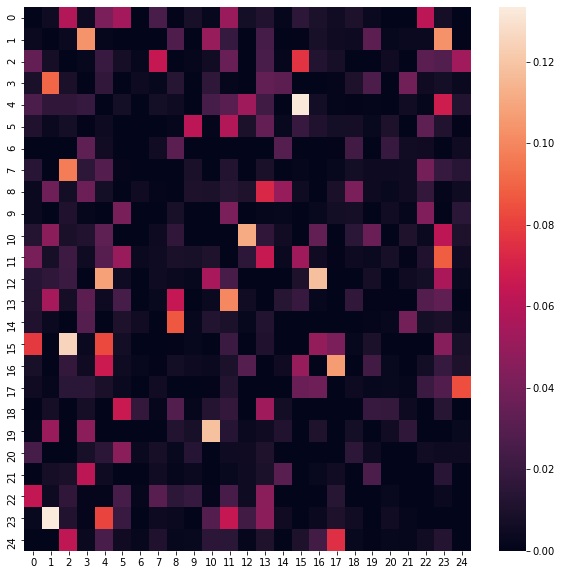

In [40]:
# have to set the diagonal to zero for decent viz (diag is much larger then off diag)
transition_mat = remodel.transmat_.copy()
np.fill_diagonal(transition_mat, 0) #acts *in-place* 

plt.figure(figsize=(10,10))
sbn.heatmap(transition_mat)
plt.show()

75th quantile: 0.014980529902725566


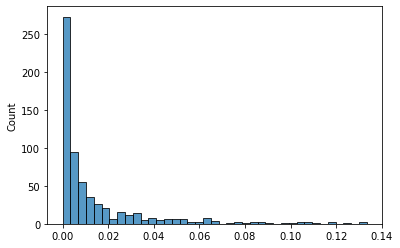

In [41]:
sbn.histplot(transition_mat.flatten())
print('75th quantile:', np.quantile(transition_mat.flatten(), 0.75))

In [42]:
def find_most_common_cycle(A, niters=100): 
    '''
    for niters 
        randomly choose node 
        sample edges with transition probability (excluding self edge)
            record path 
        if new node is original node, break 
    
    count # of unique cycles , choose largest 
    '''
    cycles = {}
    opt = np.arange(A.shape[0])
    i = 0
    for start in np.random.choice(opt, size=niters):
        print(f'progress: {i}/{niters}', end='\r')
        
        nxt = np.random.choice(opt, size=(1,), p=A[start, :])[0]
        while nxt == start: nxt = np.random.choice(opt, size=(1,), p=A[start, :])[0]
            
        cycle=[start, nxt]
        while nxt != start: 
            old = nxt
            nxt = np.random.choice(opt, size=(1,), p=A[start, :])[0]
            if nxt != old: cycle.append(nxt)
        cycle = frozenset(cycle)
        if cycle in cycles:
            cycles[cycle]+=1
        else: 
            cycles[cycle]=1
        i+=1
        
    mcc ={}
    for l in range(2,10): 
        filtered_dict = {k:cycles[k] for k in cycles if len(k)==l}
        try: 
            mcc[l] = max(filtered_dict, key=filtered_dict.get)
        except ValueError: 
            mcc[l]=None
    return mcc
            
_A = remodel.transmat_.copy()
          
mcc = find_most_common_cycle(_A, niters=100000) 
mcc

{2: frozenset({17, 24}),
 3: frozenset({1, 3, 23}),
 4: frozenset({0, 2, 4, 15}),
 5: frozenset({4, 10, 12, 16, 23}),
 6: frozenset({0, 2, 4, 15, 16, 17}),
 7: frozenset({0, 2, 4, 15, 16, 17, 23}),
 8: frozenset({0, 2, 4, 11, 15, 16, 17, 19}),
 9: frozenset({0, 2, 4, 7, 11, 15, 22, 23, 24})}

## Graph Representation of HMM 

> **node size** :  ~self-transition probability    
> **edge width** :  ~transition probability (annotated)   
> **node position** : average state pathway activity (x,y)  
> **node color**:  can be specified, optional: pathway correllation 


TODO: Use `untreated` as the null/base graph. 

In [43]:
def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

def plot_hmm(model, ax, threshold=0.65, node_color='r', edge_color='k', label_edge=True, title=None, cbar=True): 
    
    A = model.transmat_.copy() 
        
    # set small values to zero - want sparse graph 
    A[A < np.quantile(A.flatten(), threshold)] = 0 
    
    node_size = 1000*np.diag(A)
    
    G = nx.DiGraph( A )
    
    pos = {i:x for i,x in enumerate(model.means_)}

    edge_weights = np.array([G[u][v]['weight'] for u,v in G.edges()])
    scaled_edge_weights = 10* edge_weights * 1.0/edge_weights.max()
    
    if node_color == 'path-corr':
        corr_mats = np.array([correlation_from_covariance(x) for x in model.covars_])
        node_color = corr_mats[:,0,1] # grab the off diagonal 
        cmap=plt.get_cmap()
        vmin = -1
        vmax = 1
    
        pl = nx.draw_networkx(G, 
                         pos=pos,
                         arrows=True, 
                         **{'node_color':'red',
                         'node_size': node_size,
                         'width': scaled_edge_weights,
                         'arrowstyle': '->',
                         'arrowsize': 35,
                         'node_color':node_color,
                         'edge_color':edge_color,
                         'alpha':1.0,
                         'vmin':vmin,
                         'vmax':vmax}, 
                          ax=ax)
    else: 
        pl = nx.draw_networkx(G, 
                         pos=pos,
                         arrows=True, 
                         **{'node_color':'red',
                         'node_size': node_size,
                         'width': scaled_edge_weights,
                         'arrowstyle': '->',
                         'arrowsize': 35,
                         'node_color':node_color,
                         'edge_color':edge_color,
                         'alpha':1.0}, 
                          ax=ax)
        
    
    if label_edge: 
        labels = nx.get_edge_attributes(G,'weight')
        labels = {k:f'{labels[k]:.3f}' for k in labels}
        nx.draw_networkx_edge_labels(G,pos,edge_labels=labels, ax=ax)
        
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.set_xlabel('clover mean (pathway score)', fontsize=15)
    ax.set_ylabel('mscarlet mean (pathway score)', fontsize=15)
    ax.set_title(title)
    
    if (type(node_color) != str) & cbar:
        
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
        sm._A = []
        plt.colorbar(sm, label='correlation')

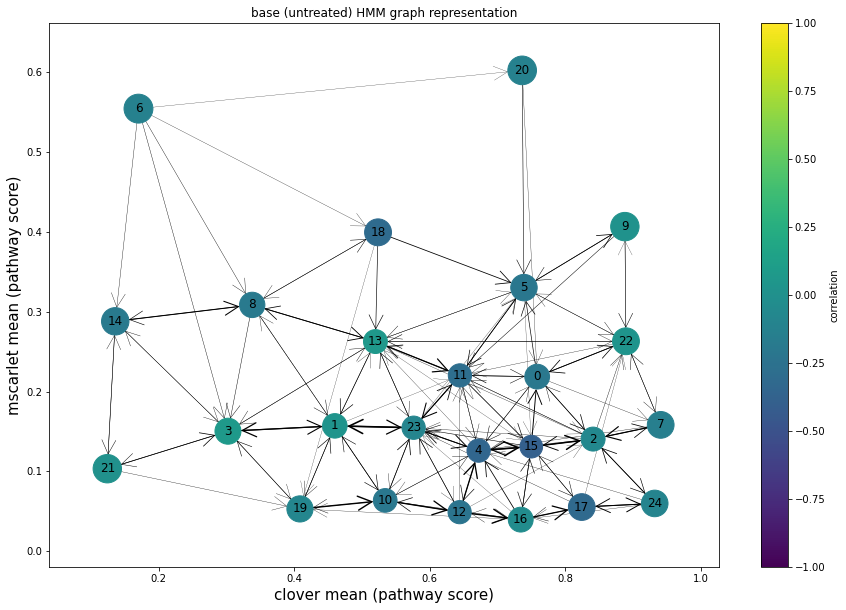

In [44]:
f,ax = plt.subplots(1,1, figsize=(15,10))
plot_hmm(remodel, ax, node_color='path-corr', edge_color='k', label_edge=False, title='base (untreated) HMM graph representation', threshold=0.75)
#lot_hmm_(HMMs[list(HMMs.keys())[1]], ax, node_color='y', edge_color='g', label_edge=False)
plt.show()

In [45]:
# can we find common loops within this? the positional movement here may indicate specific behavior 
# something like the most probable path 

# State Co-variance matrix 

I was curious if any states had co-variance (off diagonal terms - which might indicate correlation between pathway activity)

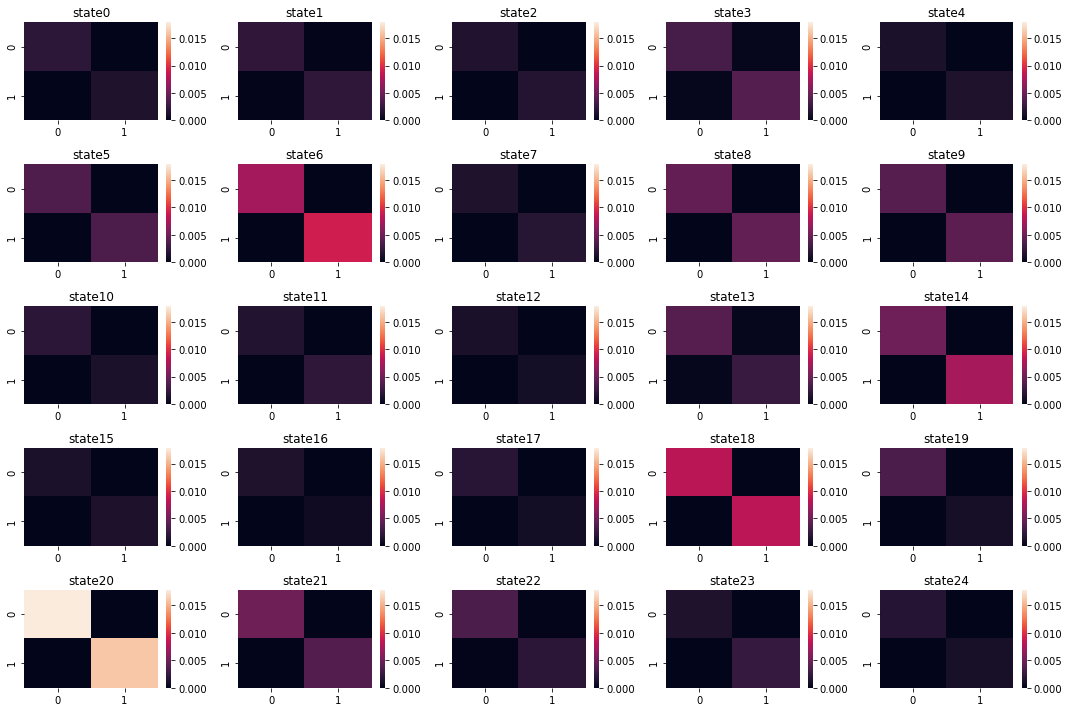

In [46]:
f, axes = plt.subplots(int(nstates/5),5, figsize=(15,10))
for i in range(len(axes.flatten())): 
    x = remodel.covars_[i, :, :]
    sbn.heatmap(x, ax=axes.flat[i], vmin=0, vmax=max(remodel.covars_.flatten()))
    axes.flat[i].set_title('state' + str(i))
plt.tight_layout()
plt.show()

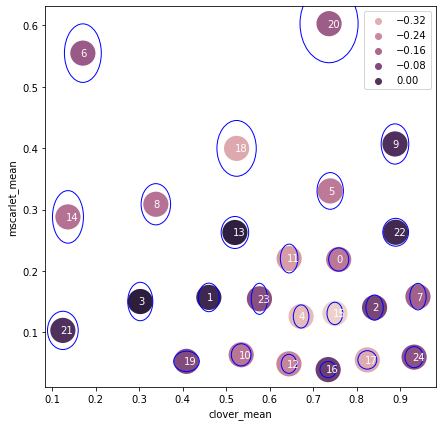

In [47]:
## TODO: add arrow sizes with thickness mediated by transition probabilities. 
## TODO: look at label specific transition probabilities/rates - does this change significnatly??? e.g. do they have different path changes? 


df = pd.DataFrame(remodel.means_, columns=['clover_mean', 'mscarlet_mean']).assign(state=range(remodel.means_.shape[0]))

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']-0.005, point['y']-0.005, str(int(point['val'])), c='w')
    
def circle_point(x, y, var_x, var_y, ax):
    a = pd.concat({'x': x, 'y': y, 'var_x': var_x, 'var_y':var_y}, axis=1)
    for i, point in a.iterrows():
        elps = Ellipse((point.x, point.y), point.var_x**0.5, point.var_y**0.5, edgecolor='b',facecolor='none')
        ax.add_artist(elps)
        

def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

corr_mats = np.array([correlation_from_covariance(x) for x in remodel.covars_])
state_pathway_corr = corr_mats[:,0,1] # grab the off diagonal 

plt.figure(figsize=(7,7))
sbn.scatterplot(x='clover_mean', y='mscarlet_mean', hue=state_pathway_corr, data=df, s=750)       
label_point(df.clover_mean, df.mscarlet_mean, df.state, plt.gca())
circle_point(df.clover_mean, df.mscarlet_mean, pd.Series(remodel.covars_[:,0, 0]), pd.Series(remodel.covars_[:,1, 1]), plt.gca())
plt.show()

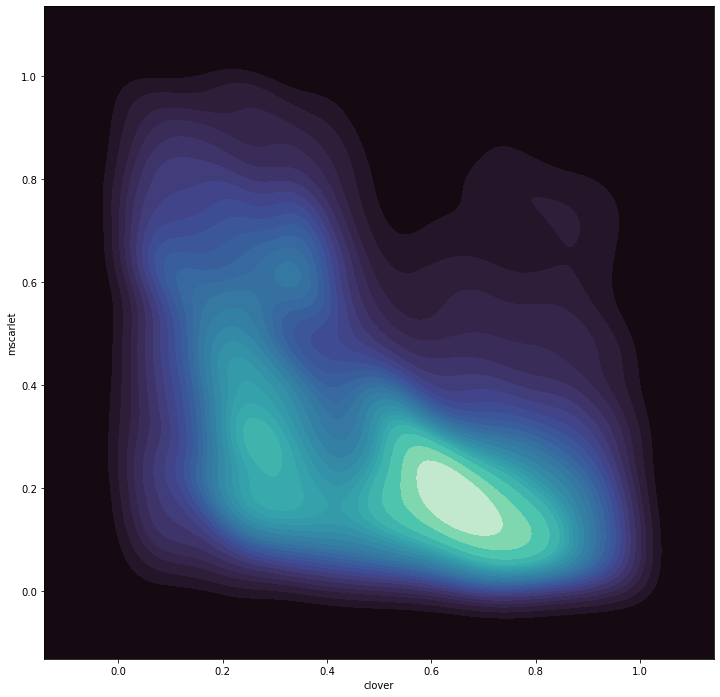

In [48]:
# does this orginization correllate to density of time series points? 
plt.figure(figsize=(12,12))
df2 = pd.DataFrame(X, columns=['clover', 'mscarlet'])
sbn.kdeplot(
    data=df2, x="clover", y="mscarlet",
    fill=True, thresh=0, levels=25, cmap="mako",
)
plt.show()

# Train HMM within each treatment group then compare HMM transition matrices 

In [49]:
HMMs = {}
for treatment in data.cell__treatment.unique(): 
    print('fitting:', treatment)
    temp = data[data.cell__treatment == treatment]
    _x, _lens = form_data(temp)
    HMMs[treatment] = get_HMM(_x, _lens, nstates, niter=niter, means=remodel.means_)
    

fitting: heya8_cdk2_mdmx__untreated
shape: (15225, 2)
model converged: True
fitting: heya8_cdk2_mdmx__bmn673
shape: (4611, 2)
model converged: True
fitting: heya8_cdk2_mdmx__bmn673+trametinib
shape: (5481, 2)
model converged: True
fitting: heya8_cdk2_mdmx__trametinib
shape: (6960, 2)
model converged: True
fitting: heya8_cdk2_mdmx__etoposide
shape: (2088, 2)
model converged: True


In [50]:
def comparative_graph_plots(model1, model2, treatment): 
    f,axes = plt.subplots(1,2, figsize=(20,7), sharex=True, sharey=True)
    plot_hmm(model1, axes[0], node_color='path-corr', edge_color='k', label_edge=False, title=f'{treatment} HMM', threshold=0.8)
    
    plot_hmm(model2, axes[1], node_color='path-corr', edge_color='k', label_edge=False, title='base (untreated) HMM graph representation', cbar=False, threshold=0.8)

    plt.show()
    
def plot_trans(mat, ax, title): 
    mat = mat.copy()
    np.fill_diagonal(mat, 0)
    sbn.heatmap(mat, ax=ax)
    ax.set_title(title)
    
def comparative_transition_heatmaps(model1, model2, treatment): 
    
    f,axes = plt.subplots(1,2, figsize=(20,7))
    
    plot_trans(model1.transmat_, axes.flat[1], 'base (untreated)')
    
    plot_trans(model2.transmat_, axes.flat[0], treatment)

    plt.show()

def model_comparison(model1, model2, treatment): 
    
    f,axes = plt.subplots(1,2, figsize=(20,7))
    
    # plot graphs overlapping
    plot_hmm(model1, axes[0], node_color='b', edge_color='b', label_edge=False, threshold=0.8)
    
    plot_hmm(model2, axes[0], node_color='r', edge_color='r', label_edge=False, title=f'base_HMM=red | {treatment}=blue', cbar=False, threshold=0.8)

    # plot trans mat DIFFERENCES
    
    plot_trans(model2.transmat_.copy() - model1.transmat_.copy(), axes.flat[1], f'transmat DIFF ({treatment} vs untreated)')

    plt.show()

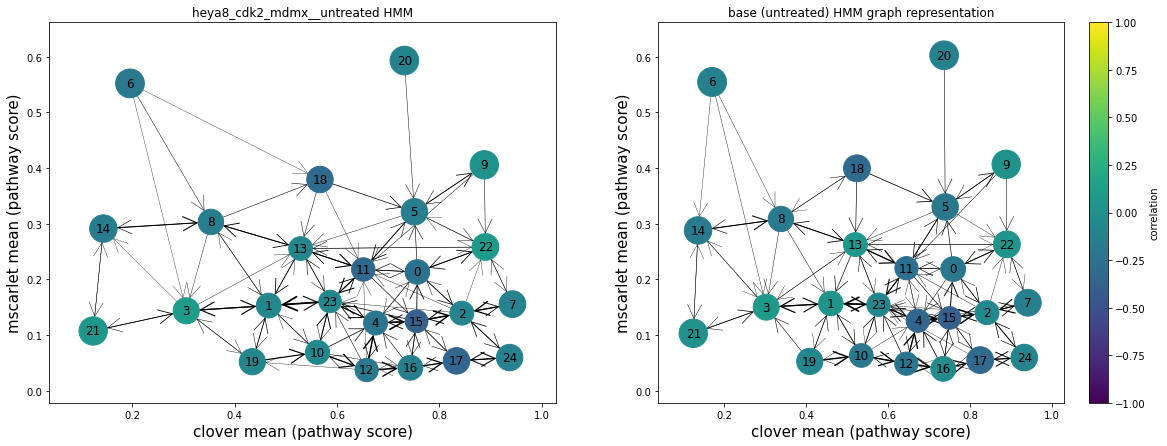

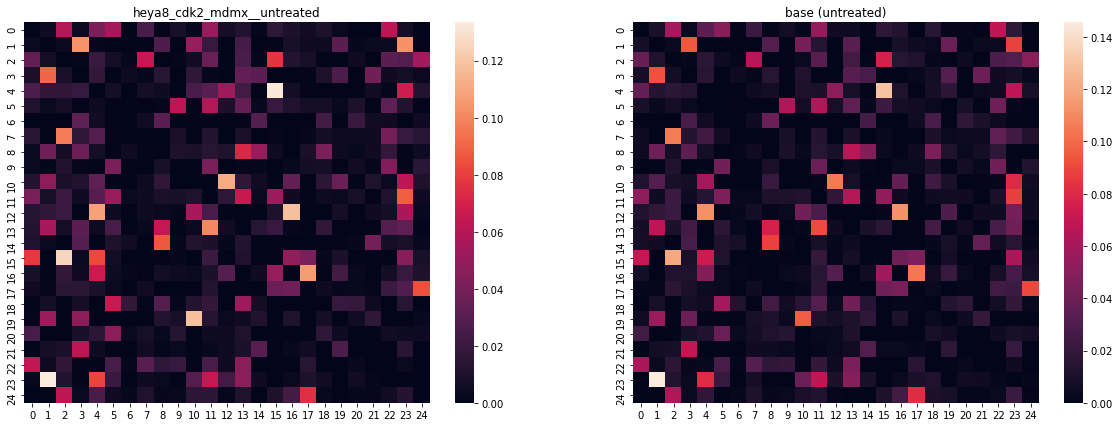

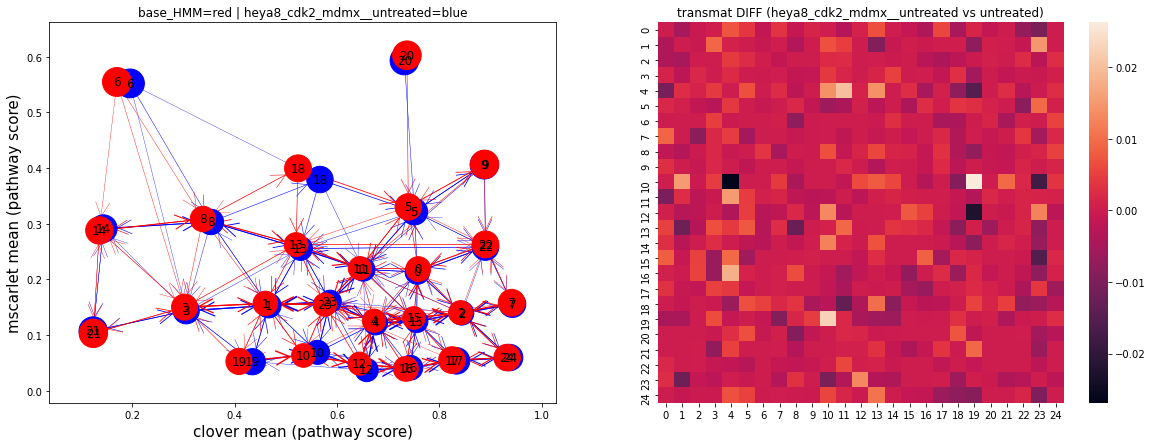

####################################################################################################
####################################################################################################


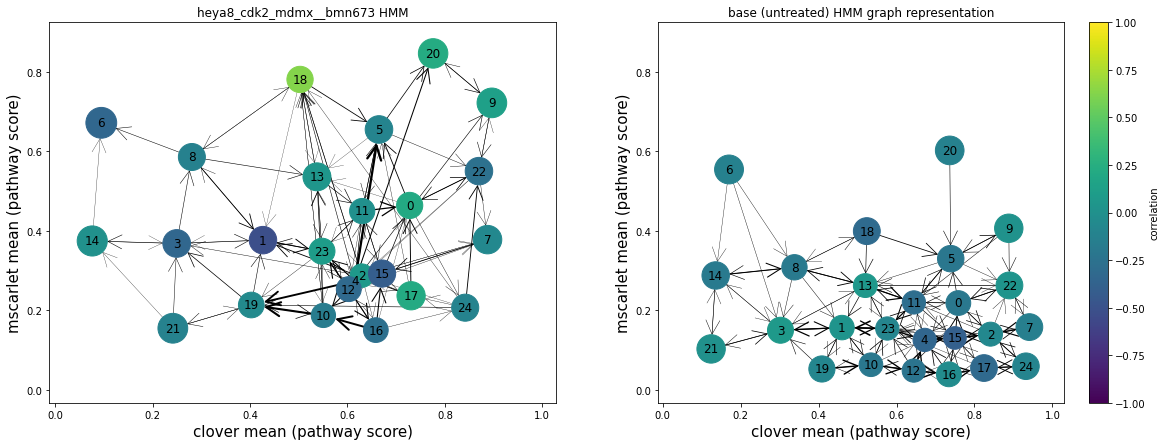

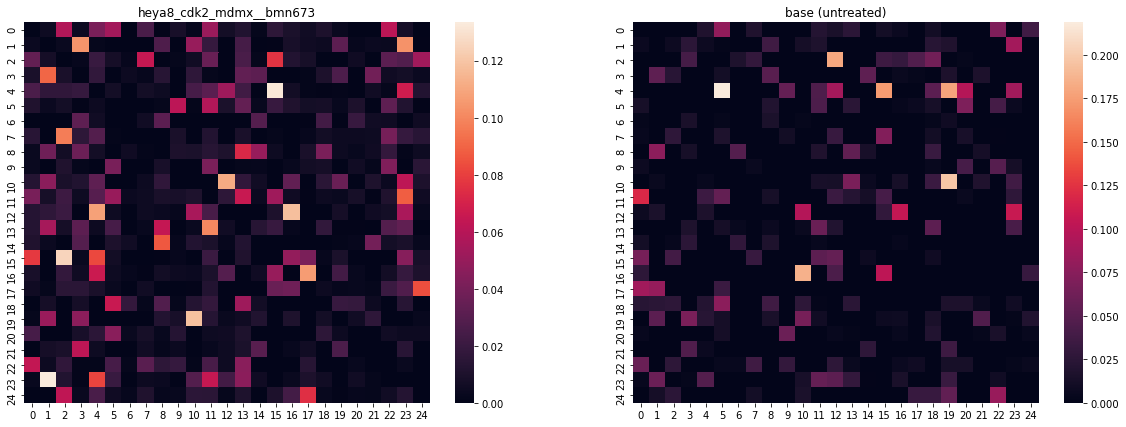

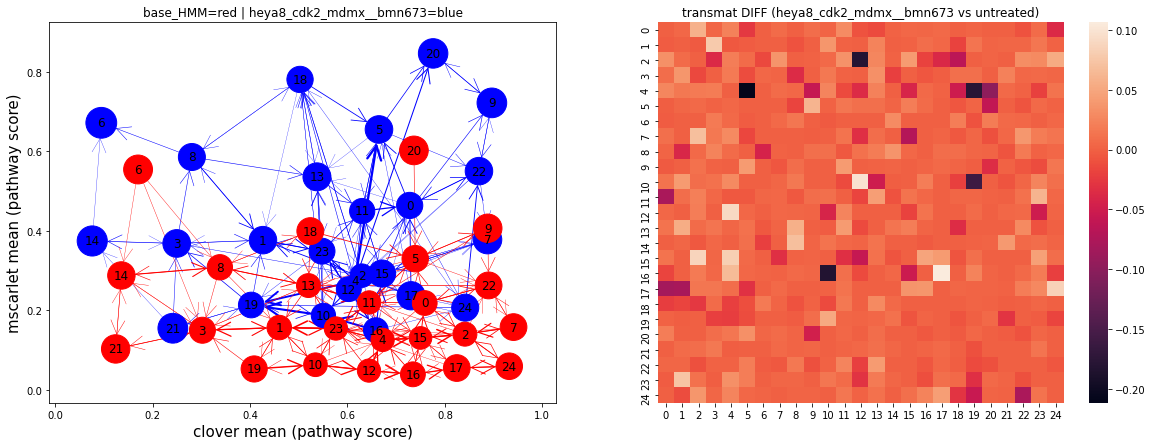

####################################################################################################
####################################################################################################


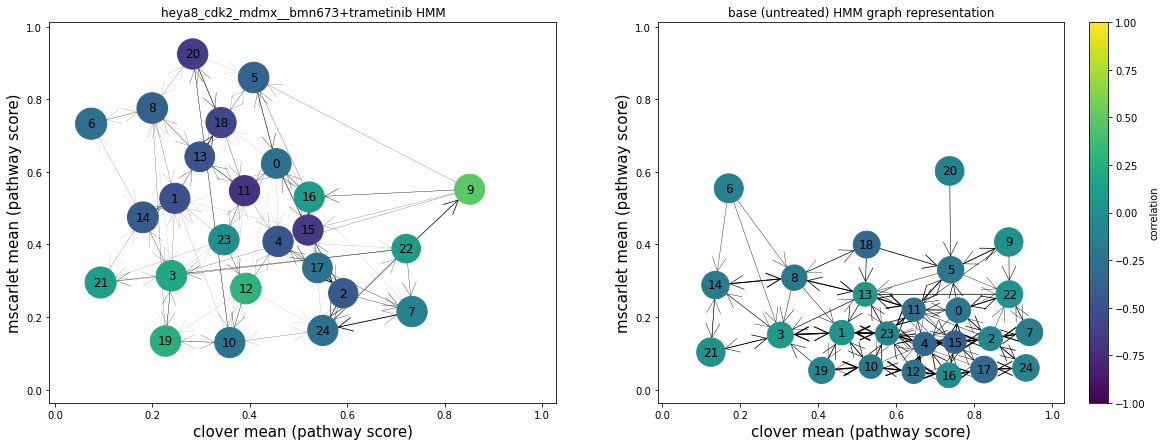

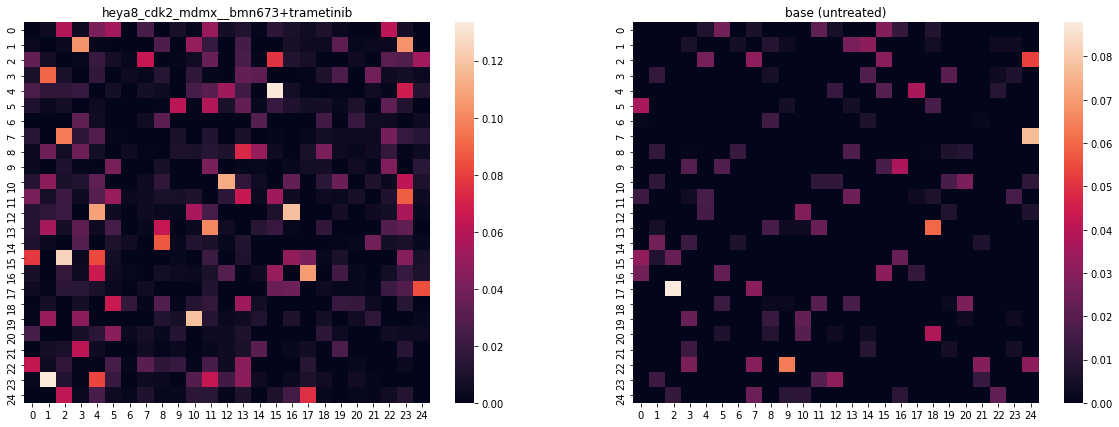

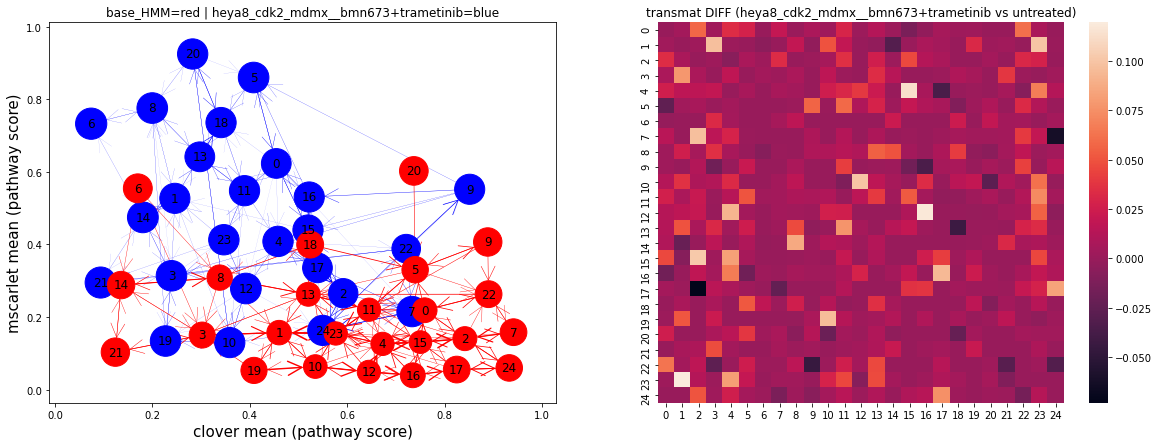

####################################################################################################
####################################################################################################


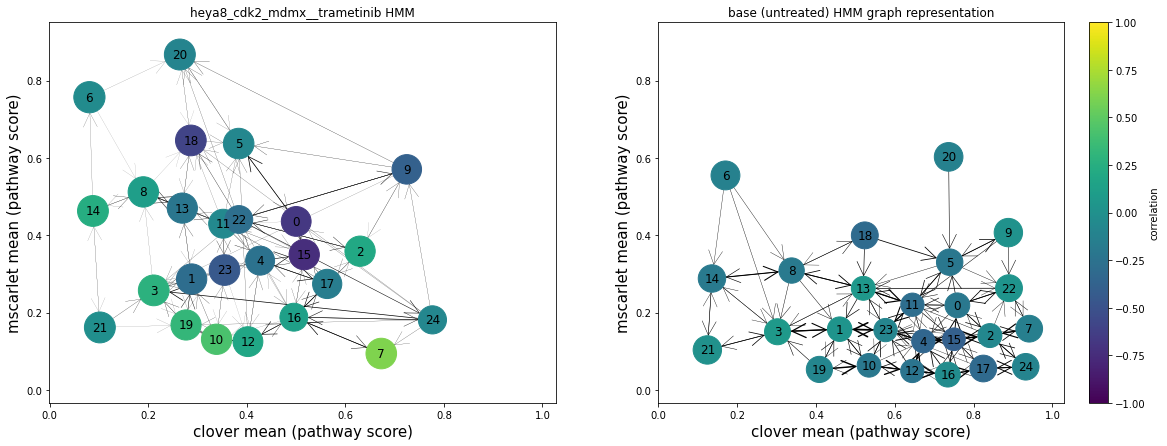

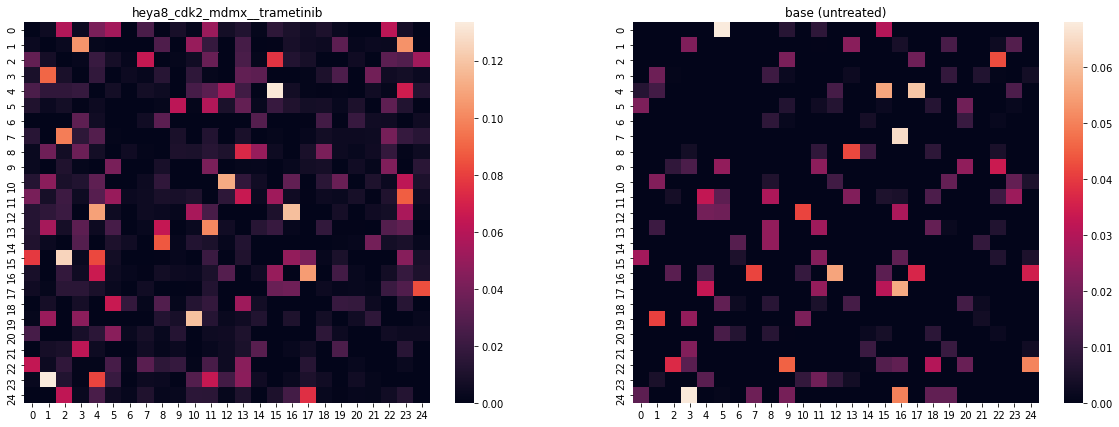

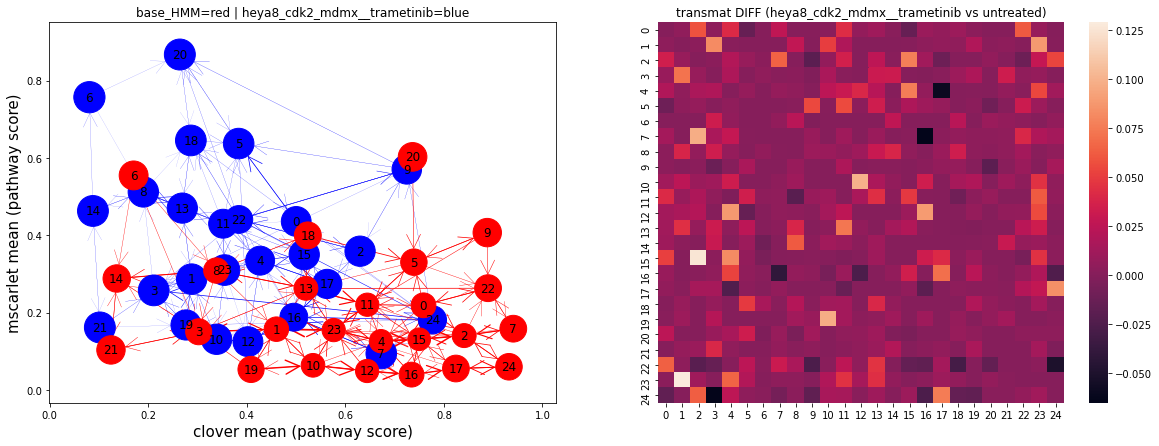

####################################################################################################
####################################################################################################


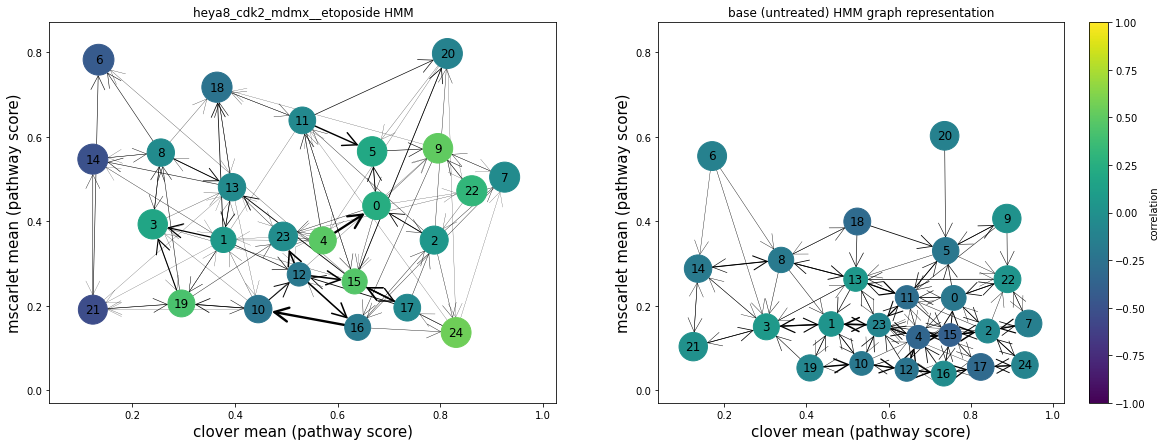

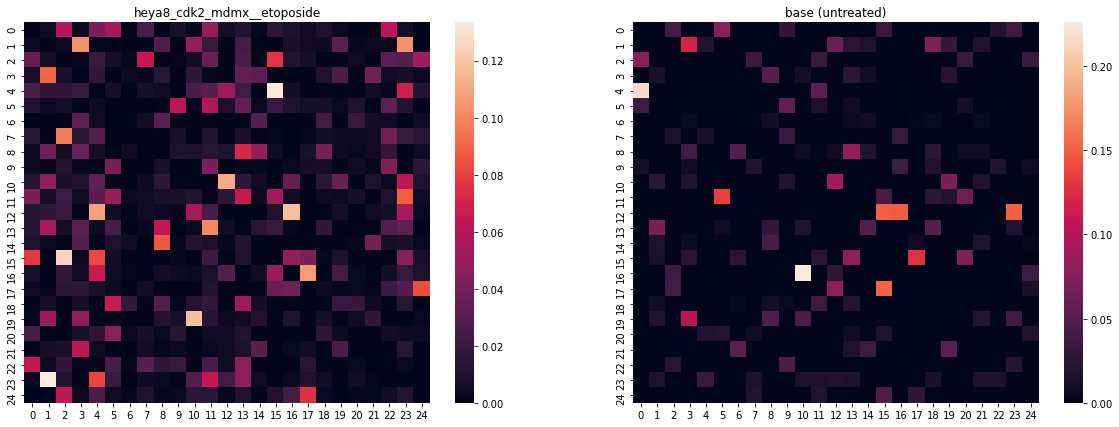

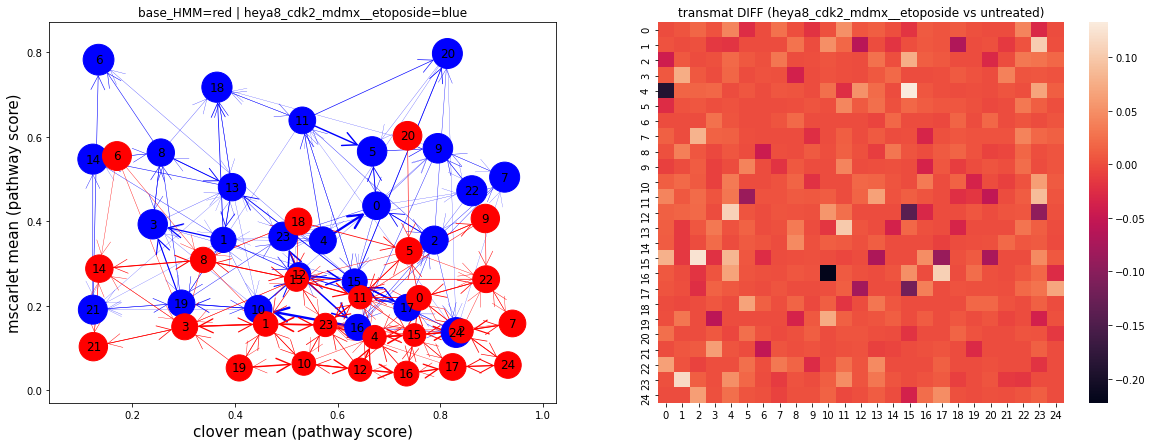

####################################################################################################
####################################################################################################


In [51]:
for treatment in HMMs: 
    comparative_graph_plots(HMMs[treatment], remodel, treatment)
    comparative_transition_heatmaps(HMMs[treatment], remodel, treatment)
    model_comparison(HMMs[treatment], remodel, treatment)
    print('#'*100)
    print('#'*100)

## can we use the transition matrix as features? 

In [52]:
_transdat = [HMMs[treatment].transmat_.flatten() for treatment in HMMs.keys()]
df = pd.DataFrame(_transdat).assign(treatment=HMMs.keys())
df.head()

0              1             2              3             4  \
0  0.604464   9.973816e-03  5.905253e-02   3.904111e-03  3.442681e-02   
1  0.685937   6.732883e-39  7.963733e-07   7.272415e-23  1.851947e-02   
2  0.883635   2.943643e-31  3.097409e-56   4.590344e-52  7.778743e-03   
3  0.886499  3.411812e-147  7.896404e-24  1.700833e-148  2.846761e-38   
4  0.763063   5.366991e-20  4.020152e-02   1.237923e-61  4.881641e-23   

          5              6              7              8             9  ...  \
0  0.049842   1.494674e-03   2.245011e-02   1.734227e-03  7.028234e-03  ...   
1  0.080076   3.122066e-19   1.808110e-02   1.836570e-18  1.169885e-07  ...   
2  0.025978  2.522550e-290   6.380522e-03  4.948746e-175  1.288595e-82  ...   
3  0.067927   8.352637e-20  7.539909e-110   2.211082e-84  7.077462e-03  ...   
4  0.078580  1.939524e-160   1.342377e-67  1.095482e-102  2.843127e-02  ...   

            616           617            618            619            620  \
0  2.549347e-02  8.174640e-02   1.047783e-02   9.224867e-03   2.198057e-03   
1  2.690968e-22  3.206002e-02   3.167972e-02   5.532019e-02   1.623789e-18   
2  1.024832e-02  3.286209e-25  2.865014e-282   2.024624e-30  3.322478e-145   
3  4.992255e-02  2.754323e-33   1.724666e-02   1.717211e-02  3.851001e-145   
4  5.083645e-21  2.698318e-02  3.264547e-188  2.158053e-233   2.633356e-91   

            621           622            623       624  \
0  2.031843e-03  4.441521e-03   2.239656e-02  0.699050   
1  1.223834e-12  8.354947e-02   1.238089e-33  0.732277   
2  1.810780e-79  2.171154e-02  6.915283e-136  0.911851   
3  2.835245e-16  3.950025e-15   1.305383e-33  0.791452   
4  0.000000e+00  3.260696e-69  4.076264e-103  0.890932   

                            treatment  
0          heya8_cdk2_mdmx__untreated  
1             heya8_cdk2_mdmx__bmn673  
2  heya8_cdk2_mdmx__bmn673+trametinib  
3         heya8_cdk2_mdmx__trametinib  
4          heya8_cdk2_mdmx__etoposide  

[5 rows x 626 columns]

<AxesSubplot:ylabel='Count'>

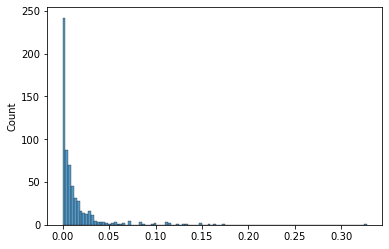

In [53]:
sbn.histplot(df[df.columns[:-1]].values.std(axis=0))

In [54]:
high_var_feats = df.columns[list(df[df.columns[:-1]].values.std(axis=0) > 0.01) + [True]]
high_var_feats

Index([          0,           2,           4,           5,           9,
                11,          22,          23,          24,          26,
       ...
               602,         603,         615,         616,         617,
               618,         619,         622,         624, 'treatment'],
      dtype='object', length=215)

In [55]:
df2 = df[high_var_feats]
X = df2.values[:,:-1]

In [56]:
pca = decomposition.PCA(n_components=2)
pca.fit(X)
X2 = pca.transform(X)

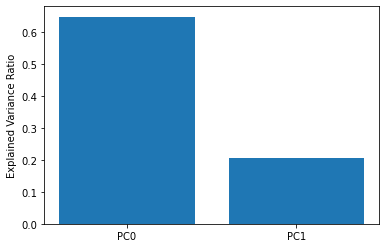

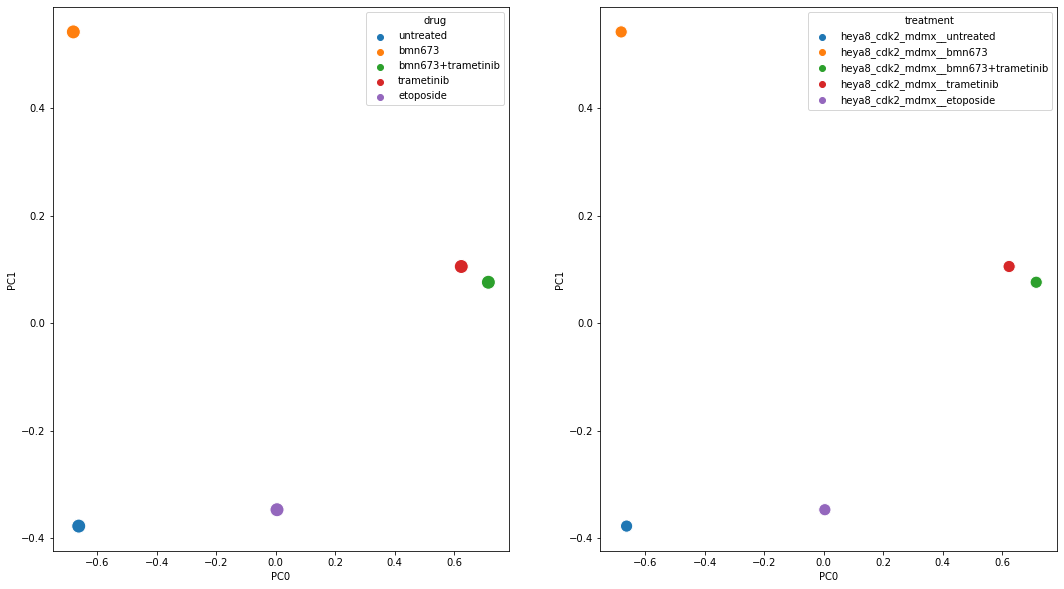

In [57]:
# TODO: Global color assignment 0 nicety 

df3 = pd.DataFrame(X2, columns=['PC0', 'PC1']).assign(treatment=df2.treatment)
df3 = df3.assign(drug = [x.split('_')[-1] for x in df2.treatment])

plt.figure()
plt.bar(height=pca.explained_variance_ratio_, x=['PC0', 'PC1'])
plt.ylabel('Explained Variance Ratio')
plt.show()

f, axes = plt.subplots(1,2, figsize=(18,10))
sbn.scatterplot(x='PC0', y='PC1', hue='drug', data=df3, ax=axes[0], s=200)
sbn.scatterplot(x='PC0', y='PC1', hue='treatment', data=df3, ax=axes[1], s=150)
plt.show()

# Analysis 2: Time-series Feature Extraction 

documentation: https://tsfel.readthedocs.io/en/latest/  

paper: https://www.sciencedirect.com/science/article/pii/S2352711020300017

In [58]:

# needs to be column delineated 
# time-id  feature 
obs = []
for i, row in data.iterrows(): 
    obs.append(pd.DataFrame({'clover':row[data.attrs['clover_selector']].values, 'mscarlet':row[data.attrs['mscarlet_selector']].values, 'time(h)':[x.split('=')[-1] for x in data.attrs['clover_selector']]}))

# Retrieves a pre-defined feature configuration file to extract all available features
cfg = tsfel.get_features_by_domain()
                                          
# Extract features
X = []
for i,o in enumerate(obs): 
    print(f'progress: {i}/{len(obs)}', end='\r')
    X.append(tsfel.time_series_features_extractor(cfg, o, verbose=False))

<ipython-input-58-0536f27c8418>:14: UserWarning: Using default sampling frequency set in configuration file.
  X.append(tsfel.time_series_features_extractor(cfg, o, verbose=False))


In [59]:
res = pd.concat(X, axis=0).reset_index(drop=True)
res = res.assign(track_index=data.track_index, cell__treatment=data.cell__treatment)
res.head()

0_Absolute energy  0_Area under the curve  0_Autocorrelation  0_Centroid  \
0          41.286425                0.558418          41.286425    0.412579   
1          30.717431                0.487435          30.717431    0.460284   
2          42.013402                0.567588          42.013402    0.391967   
3          32.258908                0.486359          32.258908    0.399109   
4          42.451420                0.577705          42.451420    0.412861   

   0_ECDF Percentile Count_0  0_ECDF Percentile Count_1  0_ECDF Percentile_0  \
0                       17.0                       69.0             0.508262   
1                       17.0                       69.0             0.411844   
2                       17.0                       69.0             0.518267   
3                       17.0                       69.0             0.350734   
4                       17.0                       69.0             0.521814   

   0_ECDF Percentile_1  0_ECDF Slope  0_ECDF_0  ...  2_Wavelet variance_2  \
0             0.829762      1.942551  0.011494  ...             16.485781   
1             0.706121      1.765581  0.011494  ...             16.485781   
2             0.840300      1.680163  0.011494  ...             16.485781   
3             0.714979      2.133897  0.011494  ...             16.485781   
4             0.805855      2.341265  0.011494  ...             16.485781   

   2_Wavelet variance_3  2_Wavelet variance_4  2_Wavelet variance_5  \
0              29.27313             45.881855             66.427671   
1              29.27313             45.881855             66.427671   
2              29.27313             45.881855             66.427671   
3              29.27313             45.881855             66.427671   
4              29.27313             45.881855             66.427671   

   2_Wavelet variance_6  2_Wavelet variance_7  2_Wavelet variance_8  \
0             91.049627             119.90985            152.419043   
1             91.049627             119.90985            152.419043   
2             91.049627             119.90985            152.419043   
3             91.049627             119.90985            152.419043   
4             91.049627             119.90985            152.419043   

   2_Zero crossing rate                               track_index  \
0                   1.0  81_1000189001_heya8_cdk2_mdmx__untreated   
1                   1.0  86_1000215388_heya8_cdk2_mdmx__untreated   
2                   1.0  83_1000195542_heya8_cdk2_mdmx__untreated   
3                   1.0  73_1000149946_heya8_cdk2_mdmx__untreated   
4                   1.0  81_1000187465_heya8_cdk2_mdmx__untreated   

              cell__treatment  
0  heya8_cdk2_mdmx__untreated  
1  heya8_cdk2_mdmx__untreated  
2  heya8_cdk2_mdmx__untreated  
3  heya8_cdk2_mdmx__untreated  
4  heya8_cdk2_mdmx__untreated  

[5 rows x 536 columns]

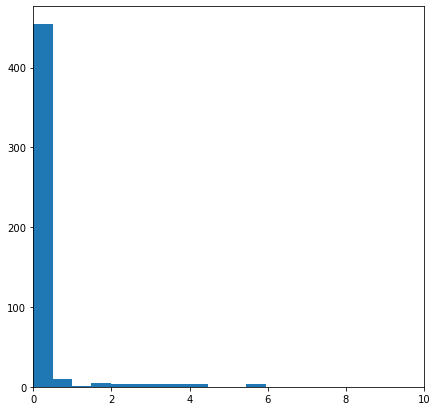

In [60]:
plt.figure(figsize=(7,7))
plt.hist(np.std(res[res.columns[:-2]], axis=0), bins=1000)
plt.xlim(0,10)
plt.show()

In [61]:
# variance filter 
print(res.shape)
res2 = res[res.columns[(np.std(res[res.columns[:-2]], axis=0) > 0.).values.tolist() + [True, True]]]
res2.shape

(395, 536)


(395, 488)

## Recursive Feature Elimination 

https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py

In [62]:
X = res2[res2.columns[:-2]].values
y = res2.cell__treatment.values

le = preprocessing.LabelEncoder()
le.fit(y)
y2 = le.transform(y)
#le.inverse_transform([0, 0, 1, 2])

scaler = StandardScaler()
X2 = scaler.fit_transform(X)

In [63]:
# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear", verbose=False, max_iter=-1, decision_function_shape='ovo', class_weight='balanced')
# The "accuracy" scoring is proportional to the number of correct
# classifications

min_features_to_select = 10  # Minimum number of features to consider
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(5),
              scoring='accuracy',
              min_features_to_select=min_features_to_select, verbose=False, n_jobs=8)
rfecv.fit(X2, y2)

print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 94


In [64]:
print('selected features:')
_ = [print(x) for x in res2.columns[list(rfecv.get_support()) + [False, False]]]

selected features:
0_ECDF Percentile_0
0_FFT mean coefficient_0
0_FFT mean coefficient_1
0_FFT mean coefficient_2
0_FFT mean coefficient_20
0_FFT mean coefficient_27
0_FFT mean coefficient_3
0_FFT mean coefficient_33
0_FFT mean coefficient_37
0_FFT mean coefficient_40
0_FFT mean coefficient_6
0_FFT mean coefficient_7
0_Fundamental frequency
0_Histogram_4
0_Histogram_6
0_Histogram_7
0_Histogram_8
0_Histogram_9
0_LPCC_0
0_LPCC_1
0_LPCC_4
0_LPCC_5
0_LPCC_8
0_MFCC_1
0_MFCC_10
0_MFCC_3
0_MFCC_4
0_MFCC_5
0_MFCC_6
0_MFCC_7
0_MFCC_8
0_Mean diff
0_Median
0_Median absolute deviation
0_Median absolute diff
0_Median diff
0_Median frequency
0_Negative turning points
0_Neighbourhood peaks
0_Peak to peak distance
0_Power bandwidth
0_Spectral entropy
0_Spectral positive turning points
0_Wavelet absolute mean_0
0_Wavelet absolute mean_1
0_Wavelet entropy
0_Zero crossing rate
1_ECDF Slope
1_FFT mean coefficient_0
1_FFT mean coefficient_15
1_FFT mean coefficient_24
1_FFT mean coefficient_25
1_FFT mean co

In [65]:
X3 = rfecv.transform(X2)

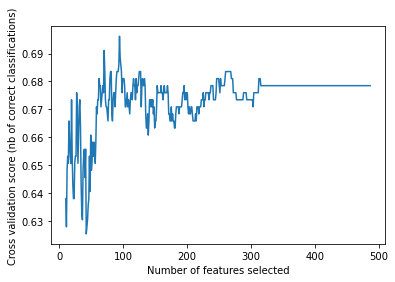

In [66]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(min_features_to_select,
               len(rfecv.grid_scores_) + min_features_to_select),
         rfecv.grid_scores_)
plt.show()

In [67]:
svc = SVC(kernel="linear", verbose=False, max_iter=-1, decision_function_shape='ovo', class_weight='balanced')

scores = cross_val_score(svc, X3, y2, cv=10)

print('cv acc:', np.mean(scores))
print('random:', 1/len(le.classes_))

cv acc: 0.8226282051282052
random: 0.2


In [68]:
classifier_labels = []
for i,c in enumerate(le.classes_): 
    for j,c2 in enumerate(le.classes_[(i+1):]): 
        classifier_labels.append(f'{c.split("__")[-1]}__VS__{c2.split("__")[-1]}')
#classifier_labels

train score 1.0


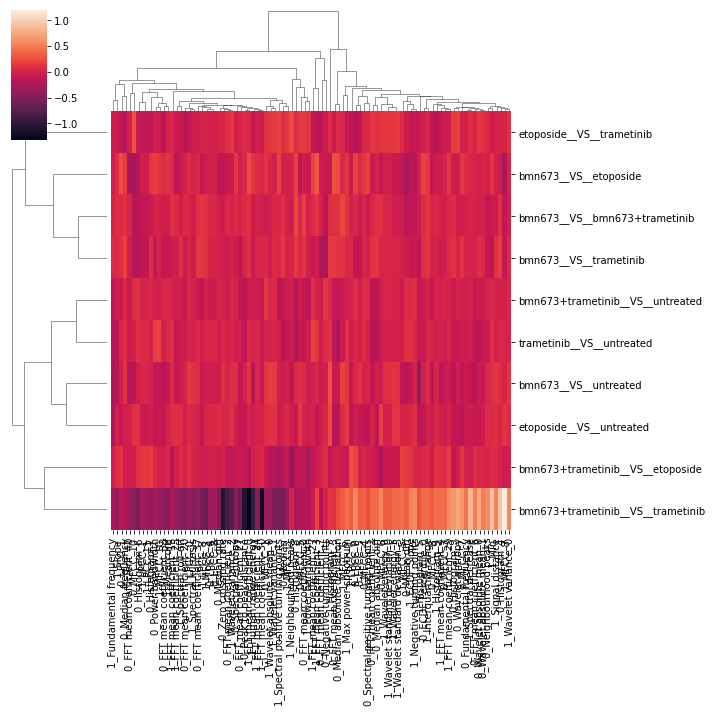

In [69]:

svc = SVC(kernel="linear", verbose=False, max_iter=-1, decision_function_shape='ovo', class_weight='balanced')
svc.fit(X3, y2)

# https://stackoverflow.com/questions/22816646/the-dimension-of-dual-coef-in-sklearn-svc
print('train score', svc.score(X3, y2))

sbn.clustermap(svc.coef_, xticklabels=res2.columns[list(rfecv.get_support()) + [False, False]], yticklabels=classifier_labels, metric='correlation')
#f_importances(svc.coef_, res2.columns[list(rfecv.get_support()) + [False, False]])

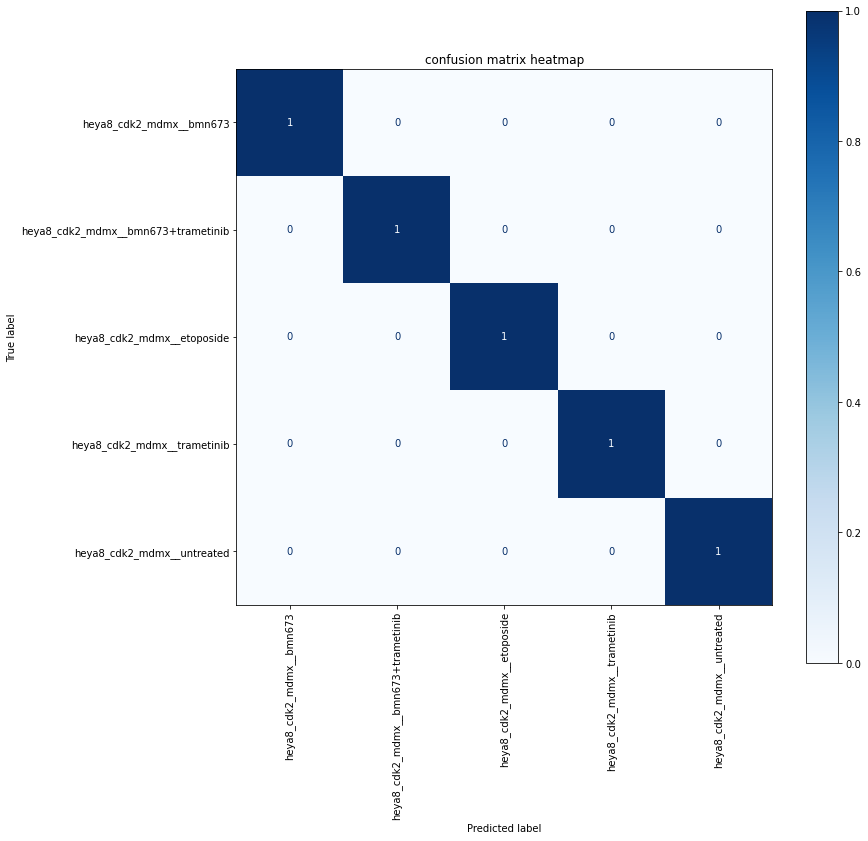

In [70]:
f, ax = plt.subplots(1,1,figsize=(12,12))
plot_confusion_matrix(svc, X3, y2, normalize='true',
                                 display_labels=le.classes_,
                                 cmap=plt.cm.Blues, ax=ax)
plt.xticks(rotation=90)
plt.title('confusion matrix heatmap')
plt.show()

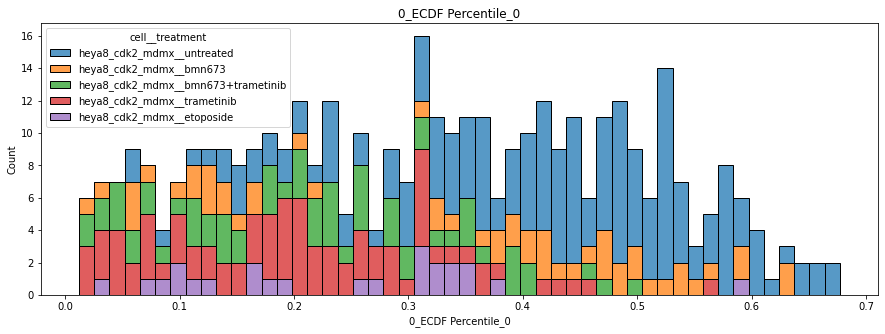

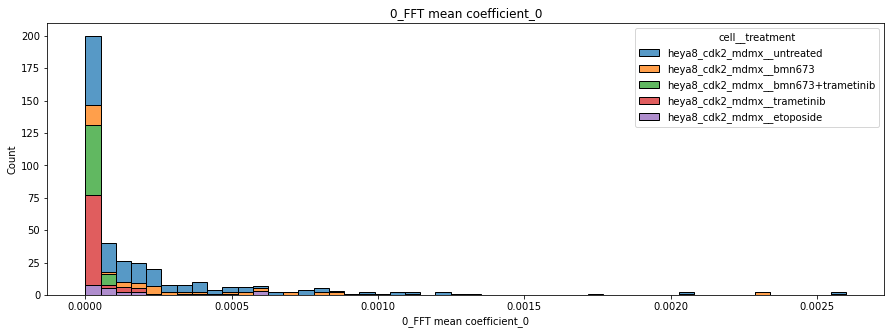

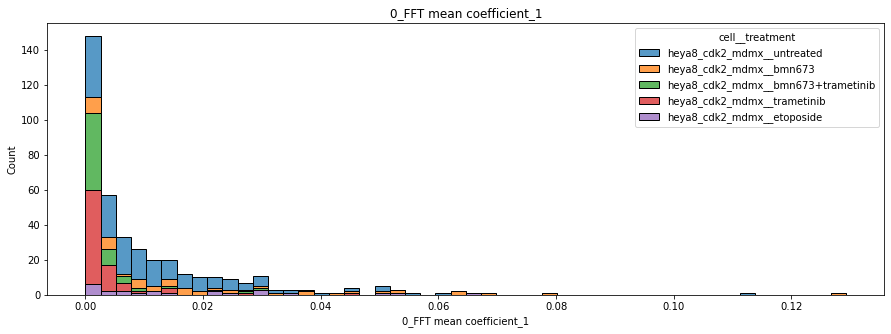

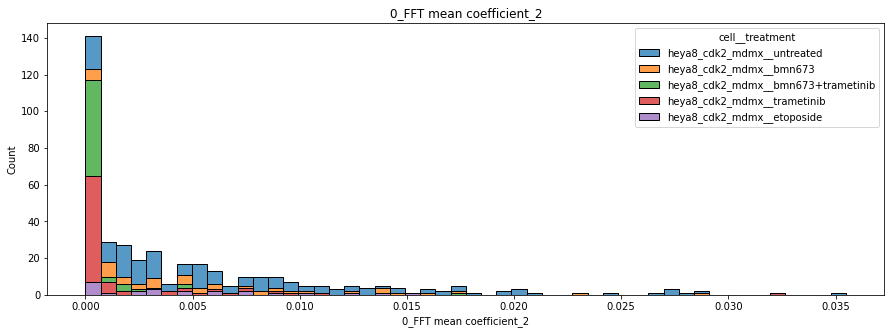

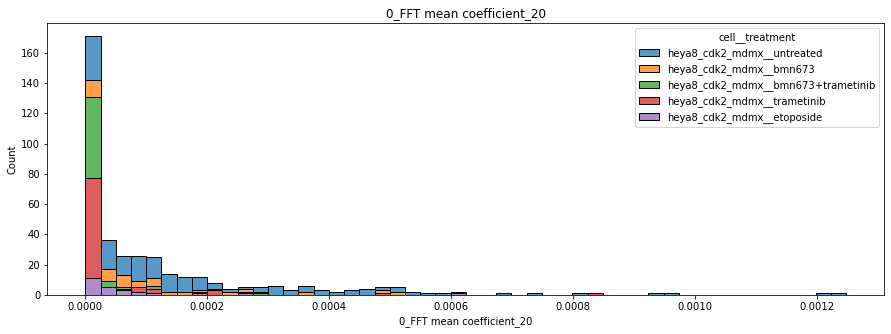

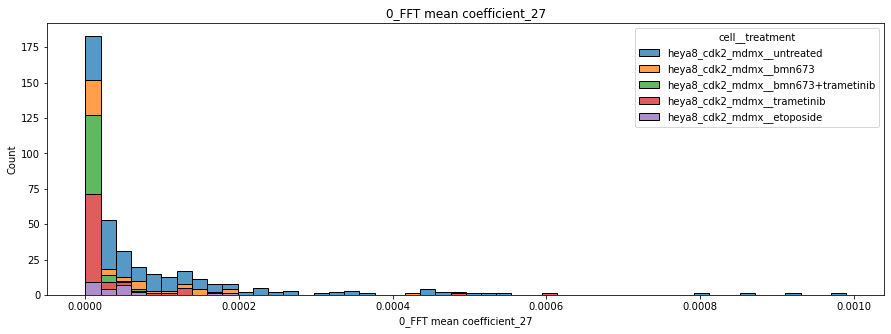

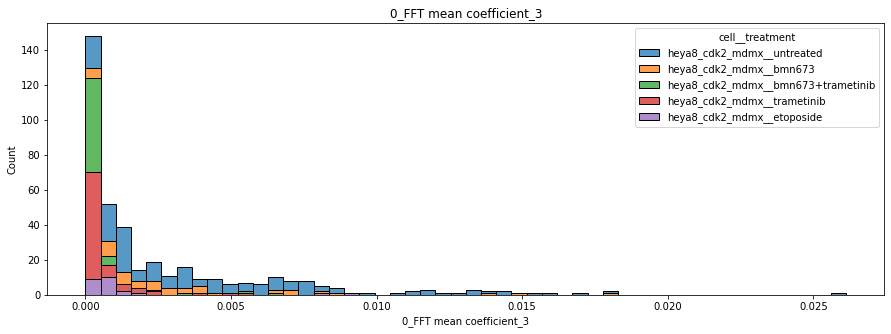

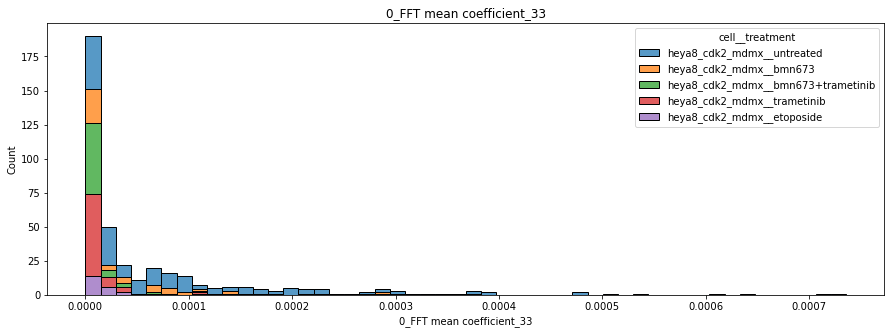

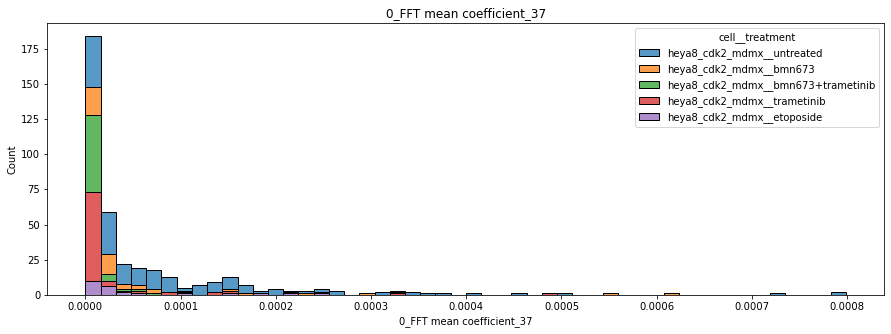

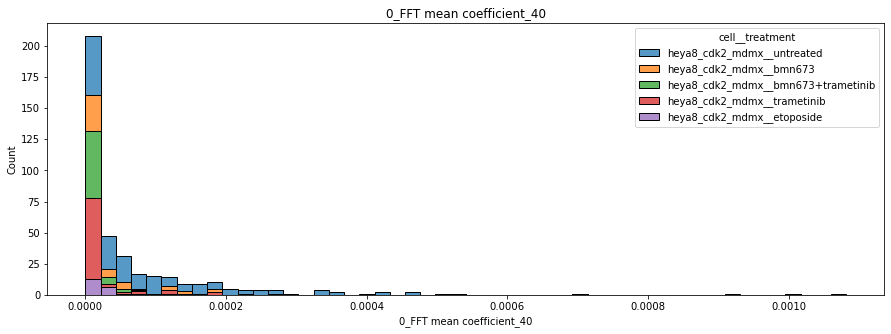

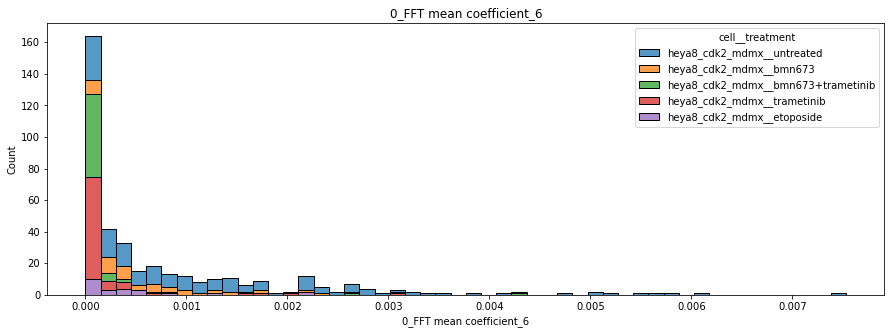

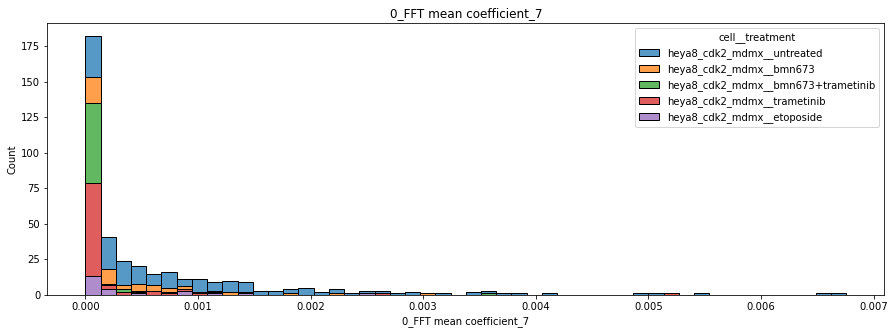

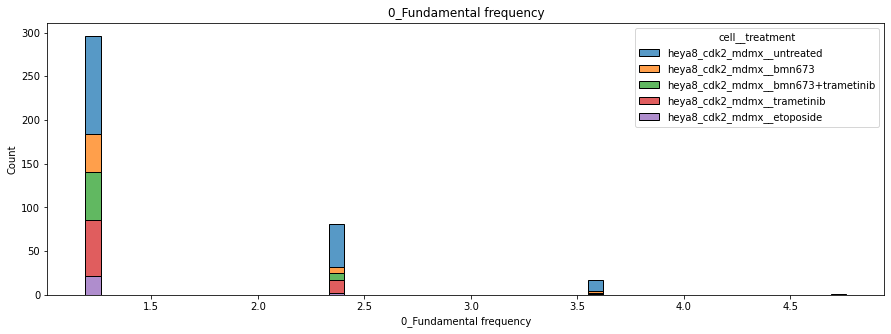

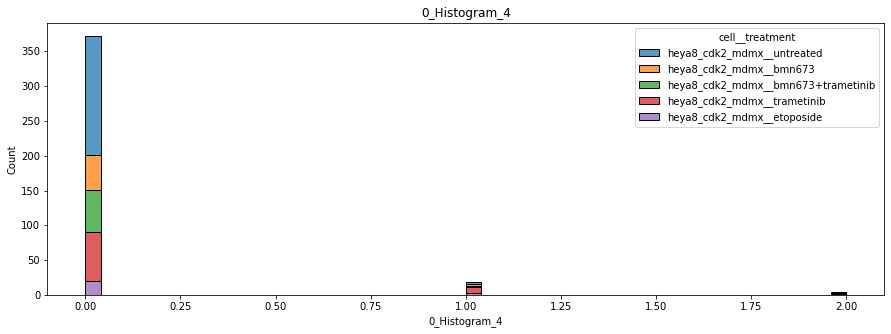

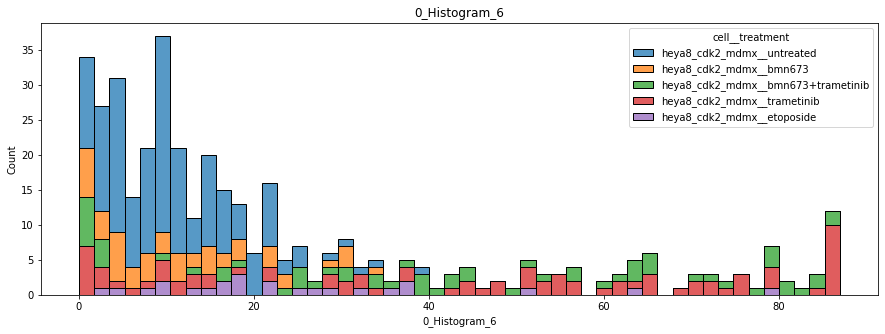

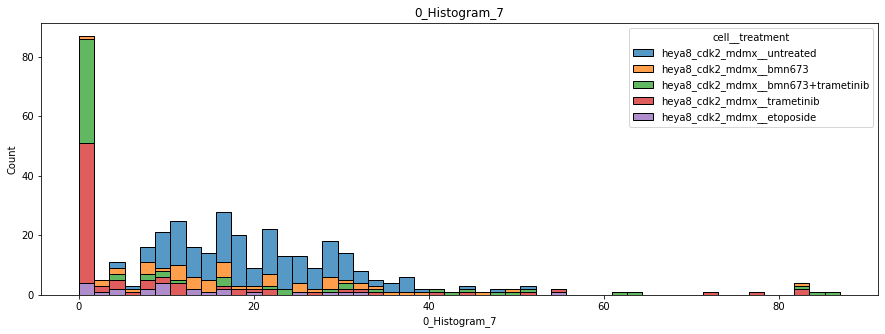

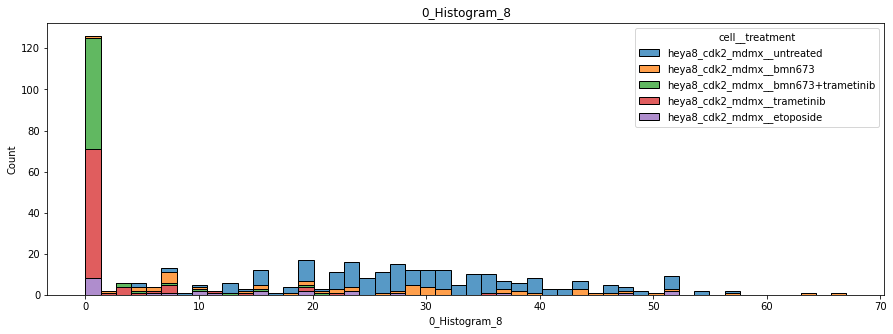

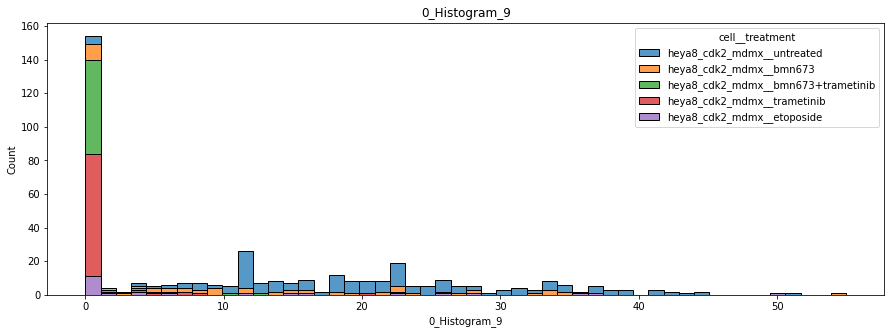

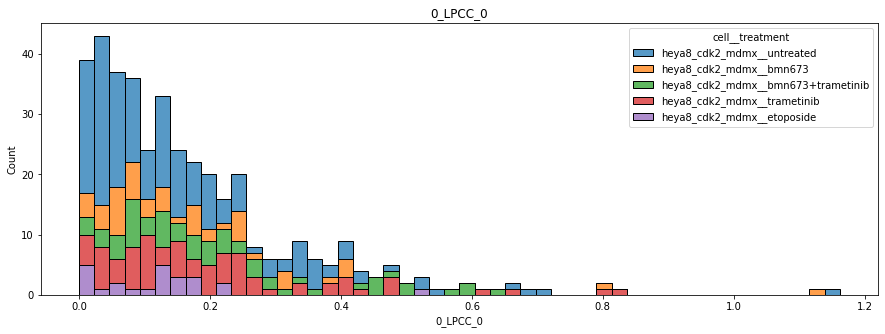

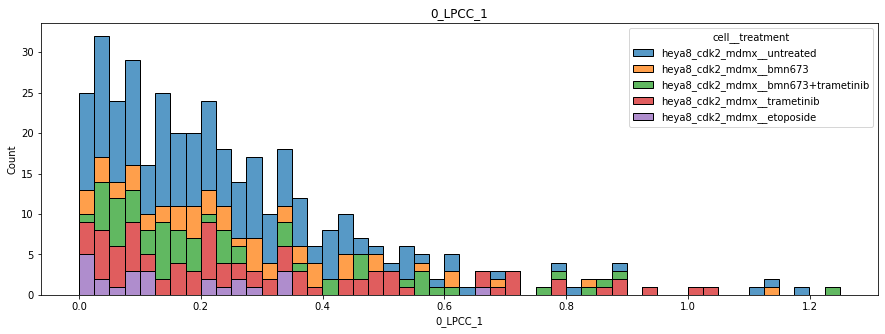

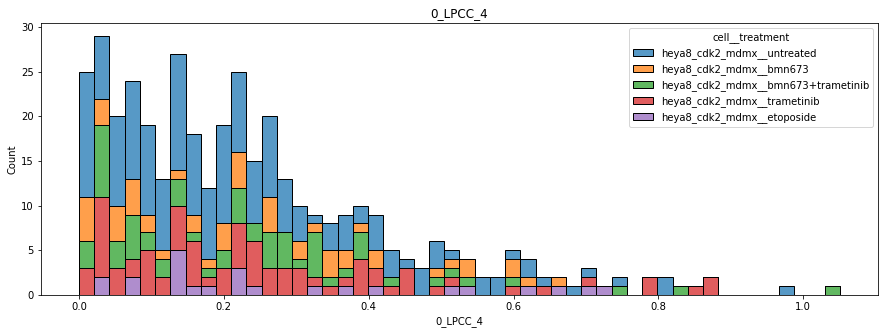

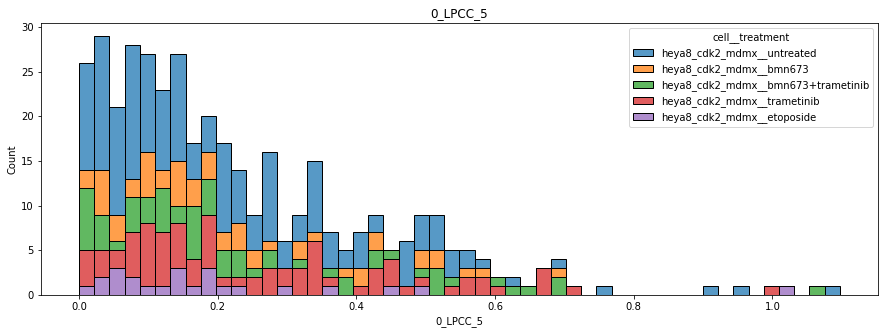

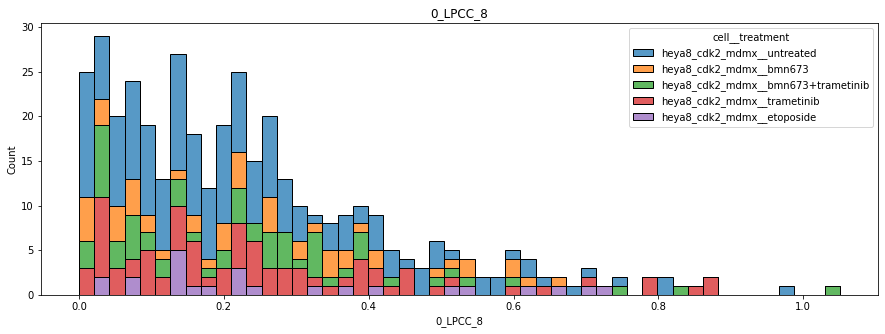

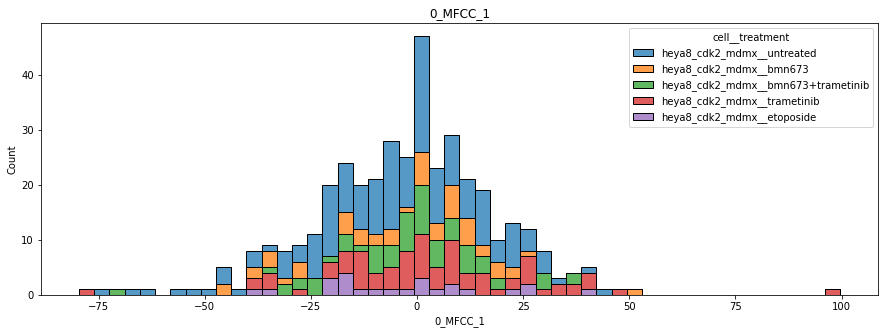

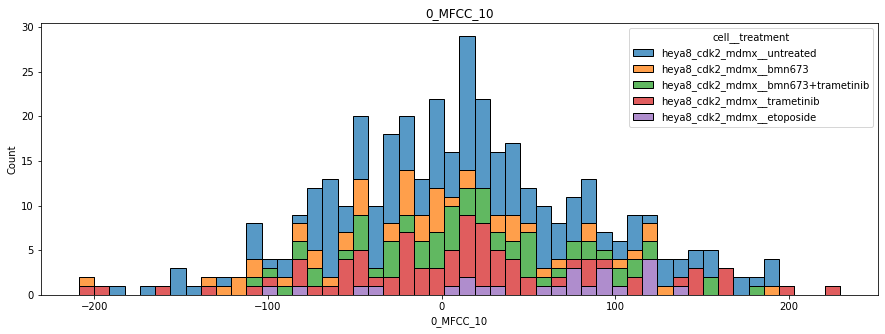

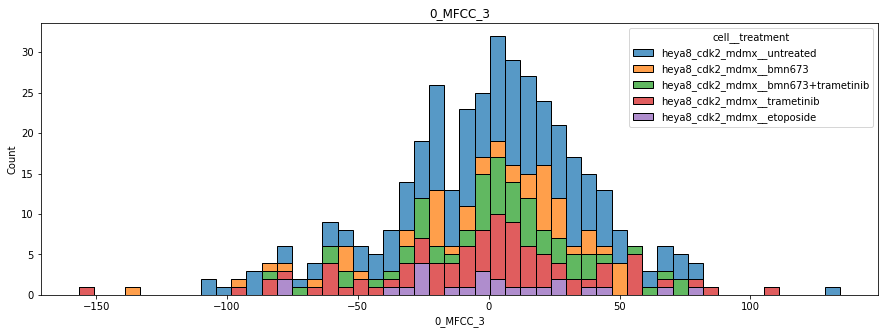

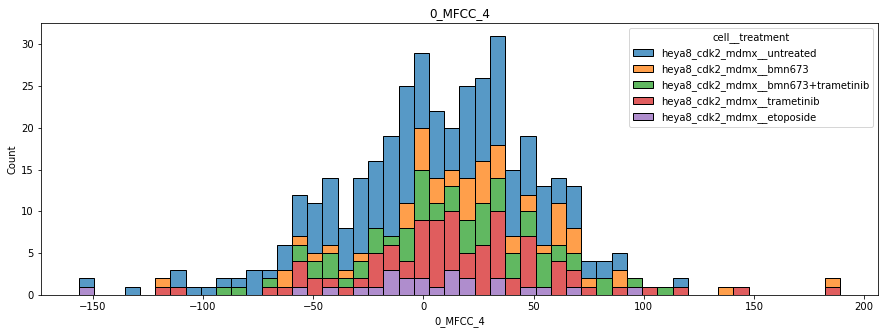

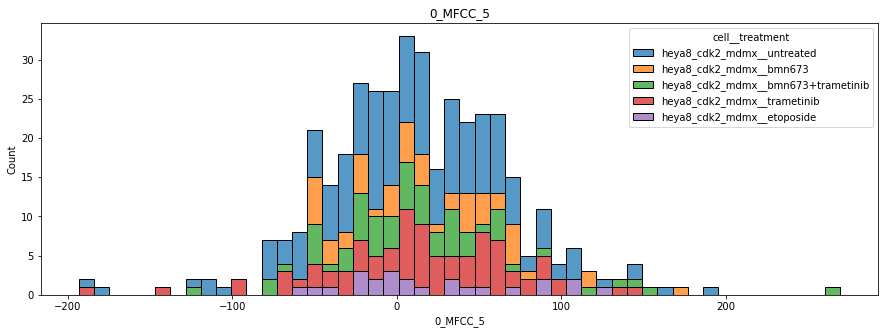

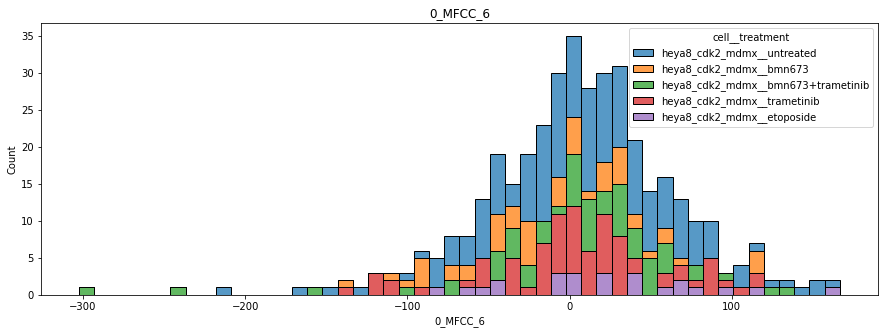

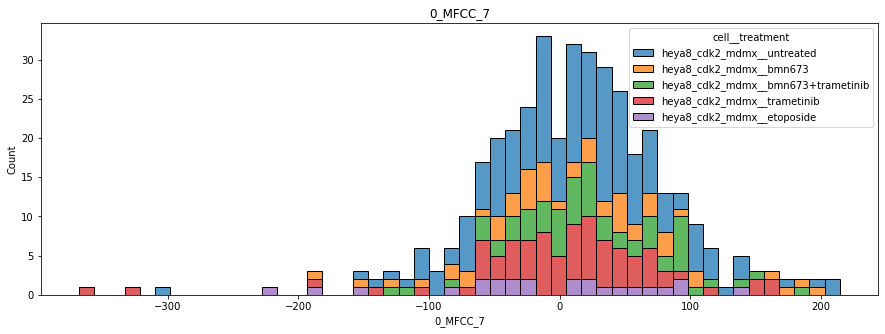

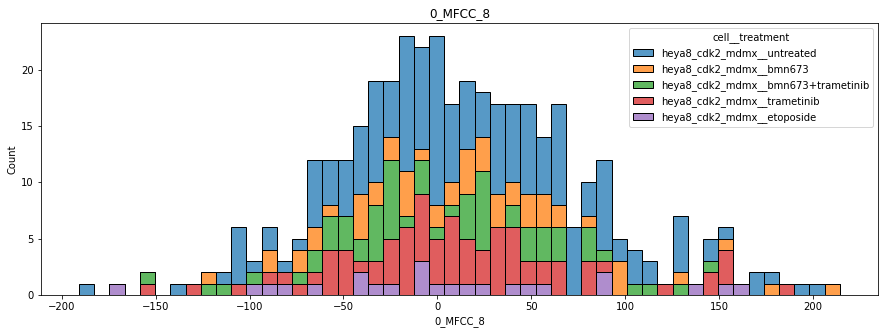

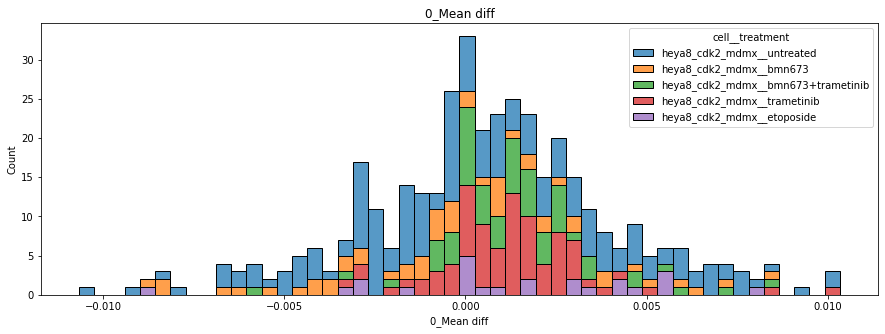

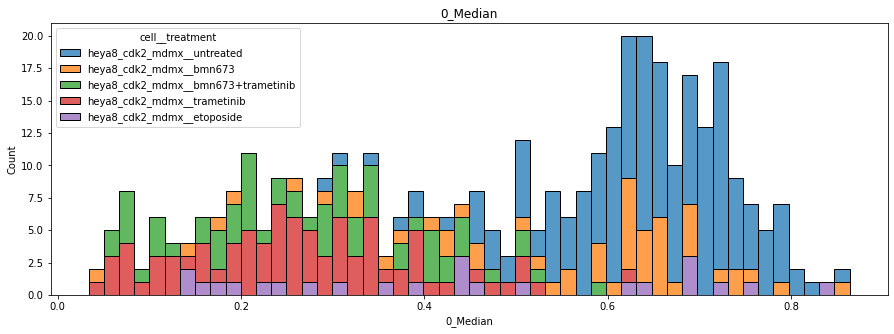

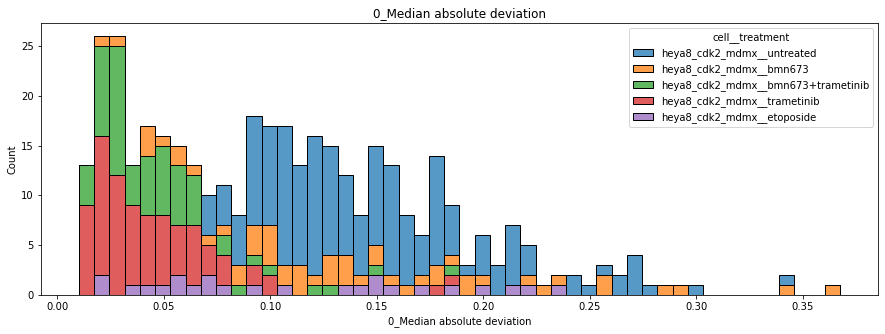

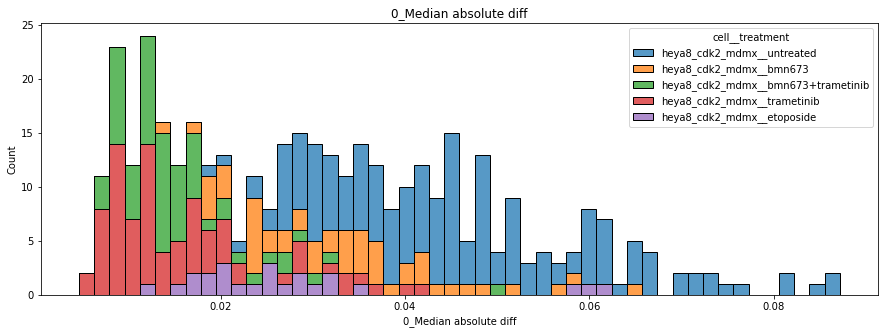

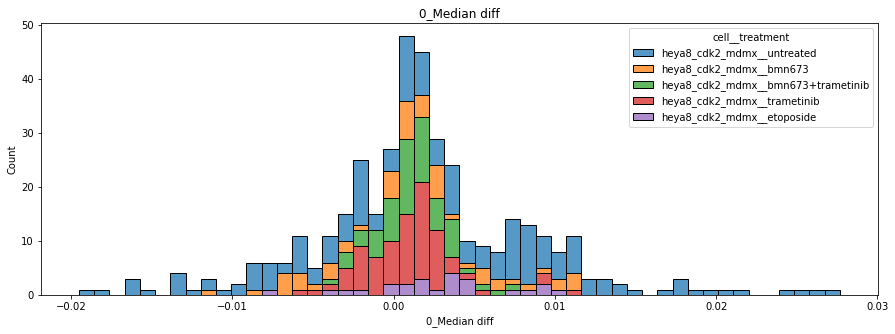

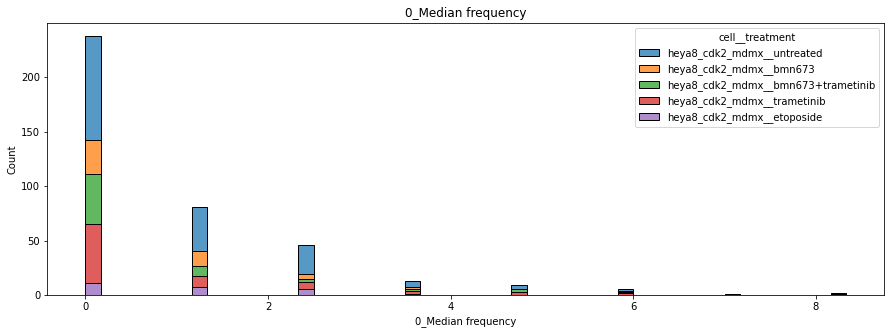

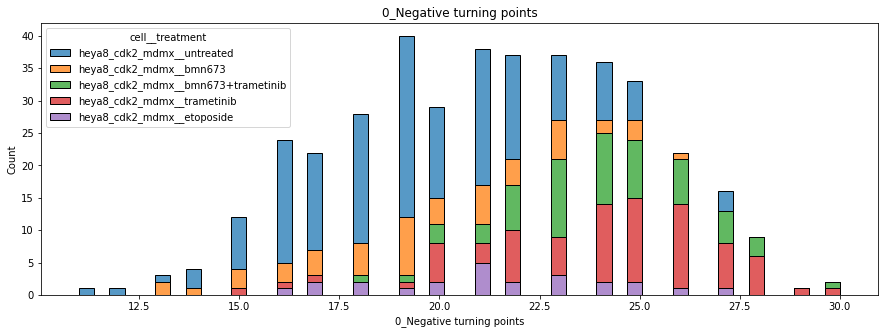

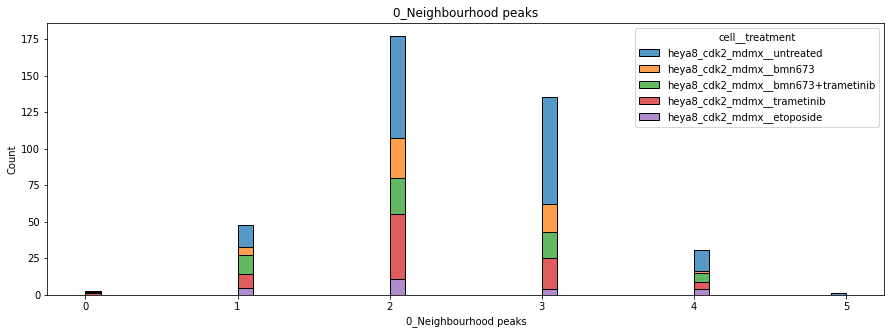

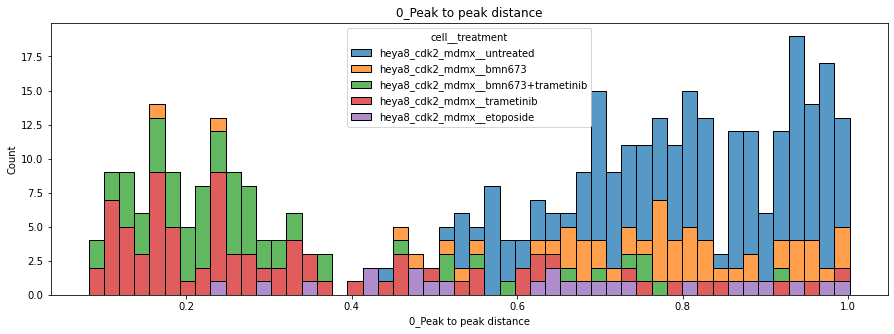

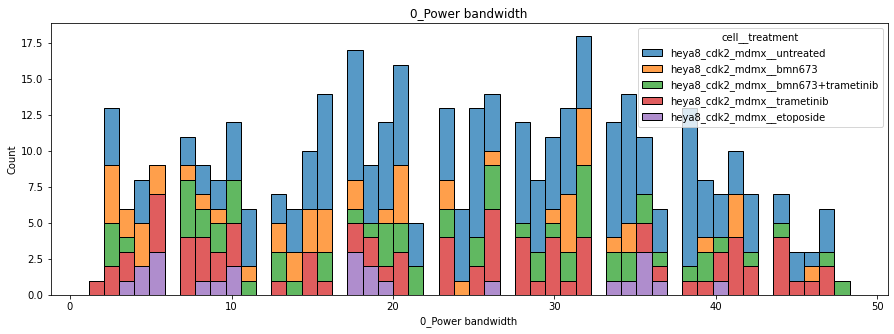

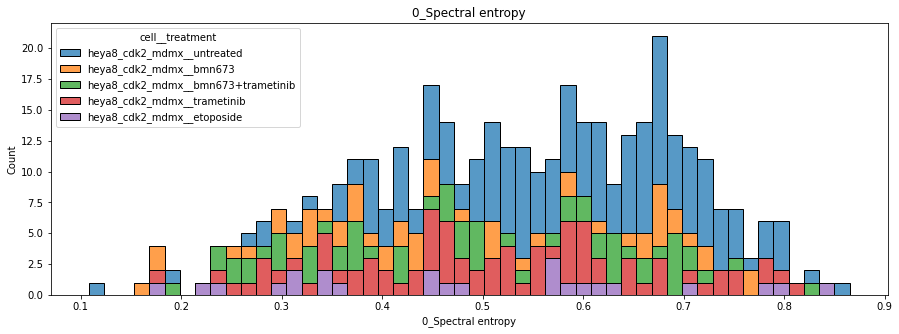

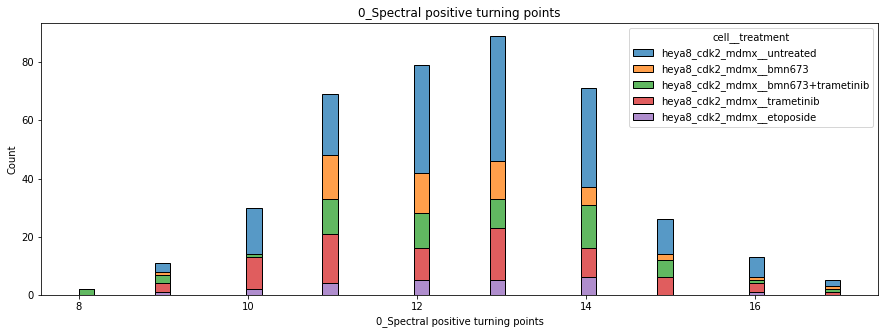

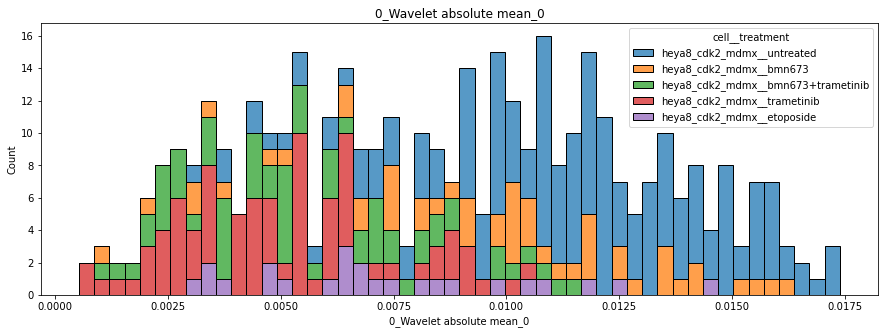

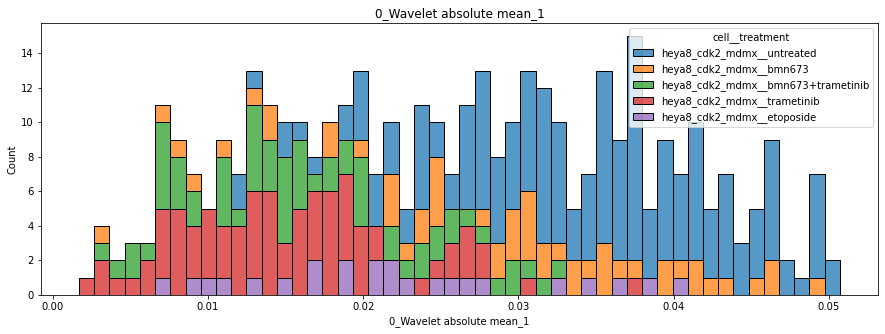

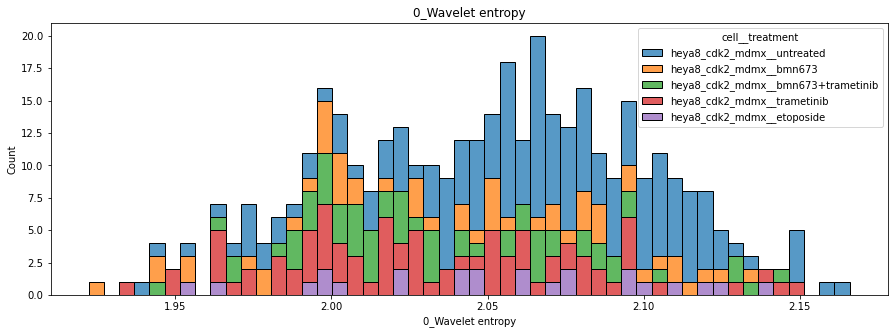

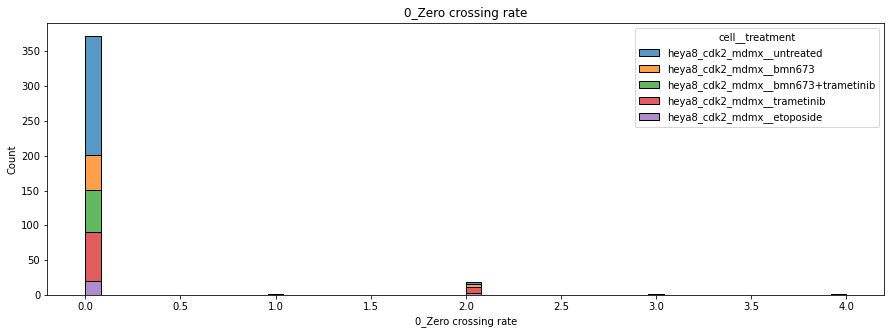

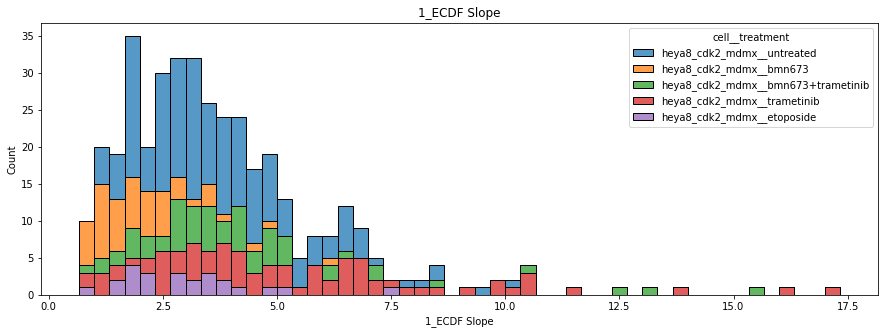

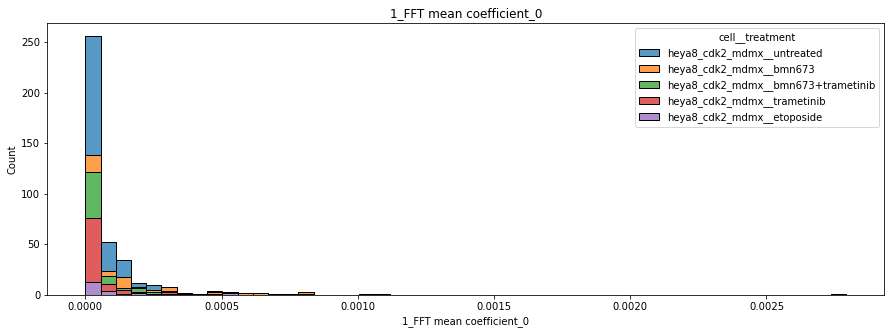

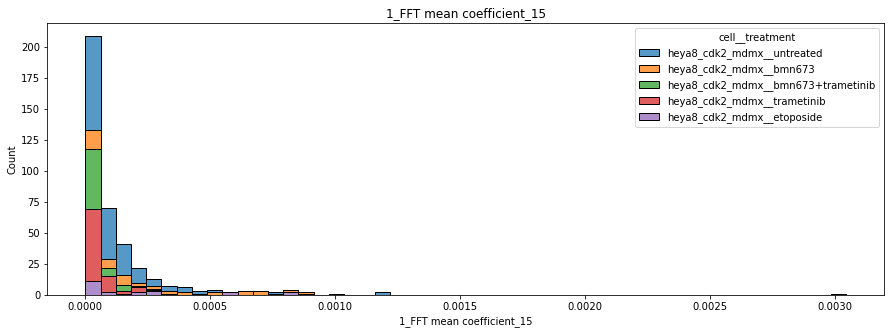

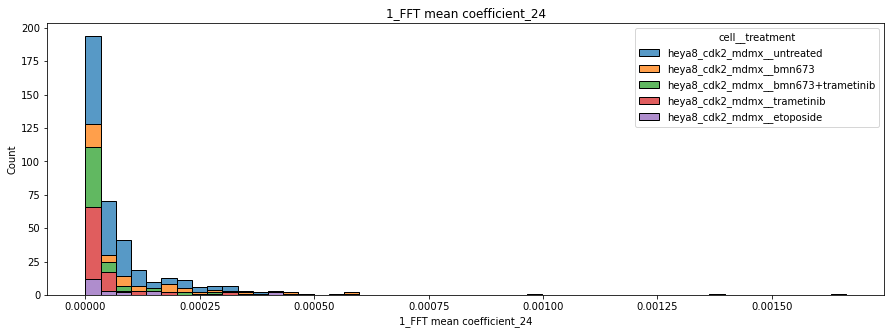

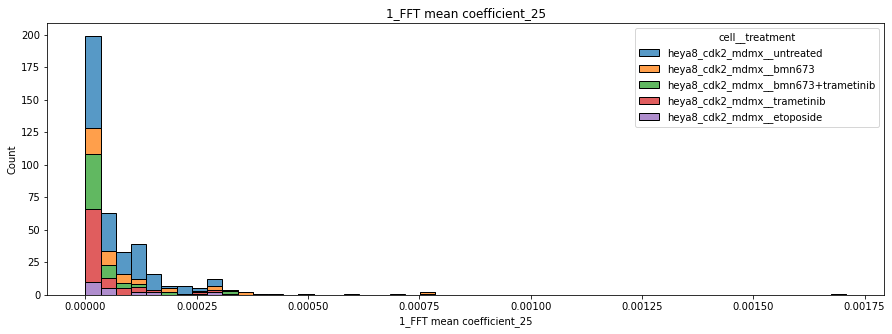

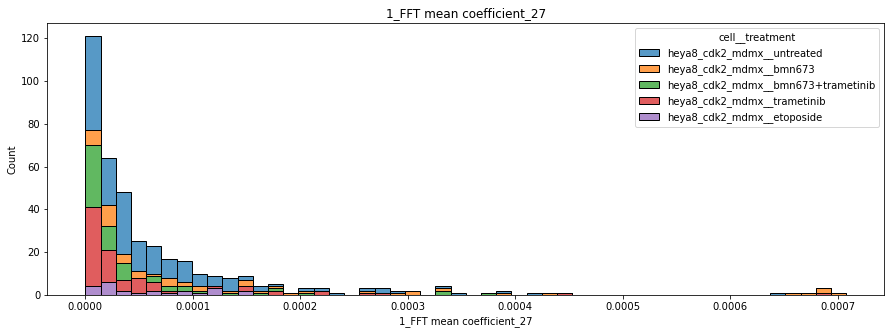

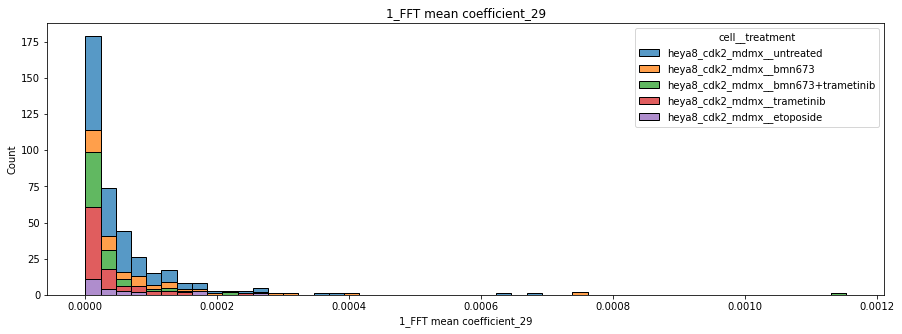

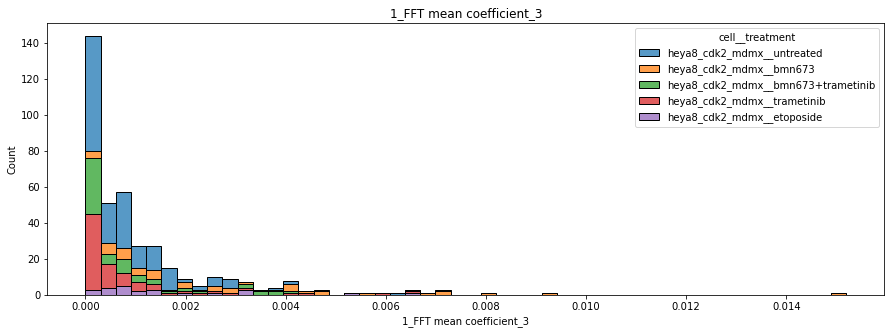

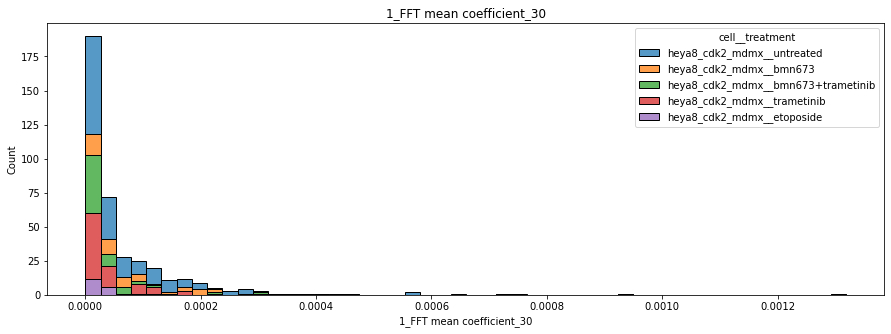

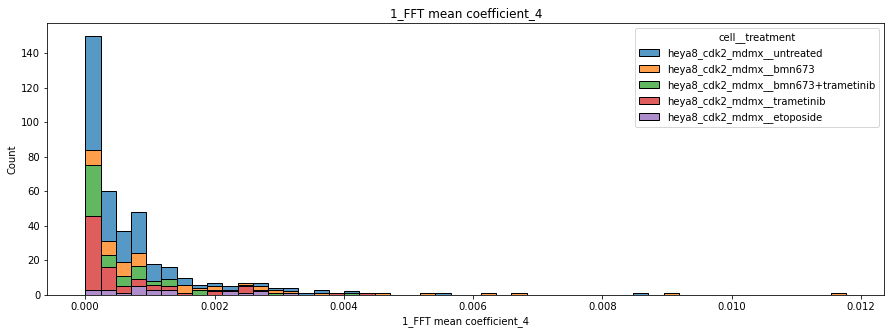

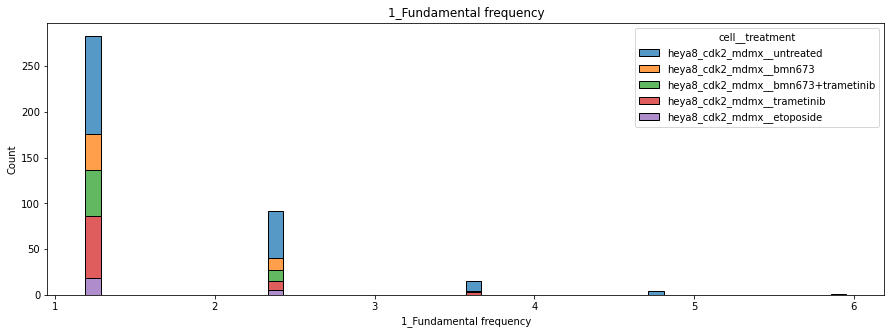

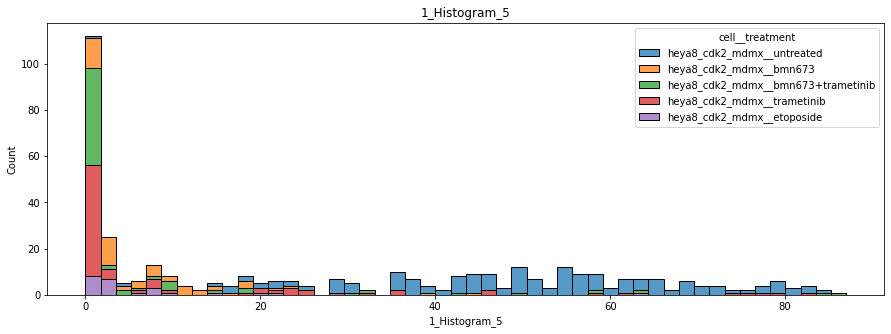

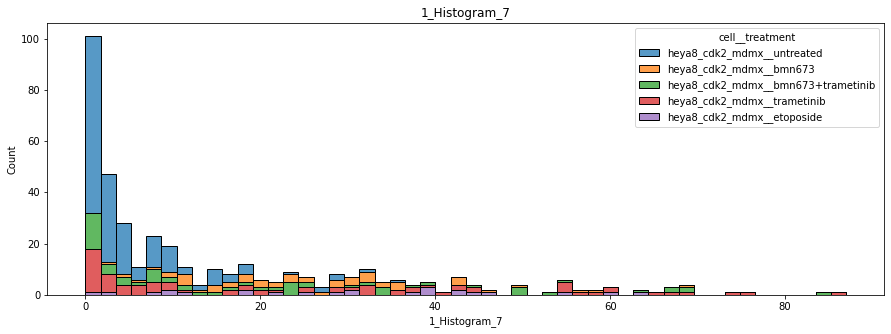

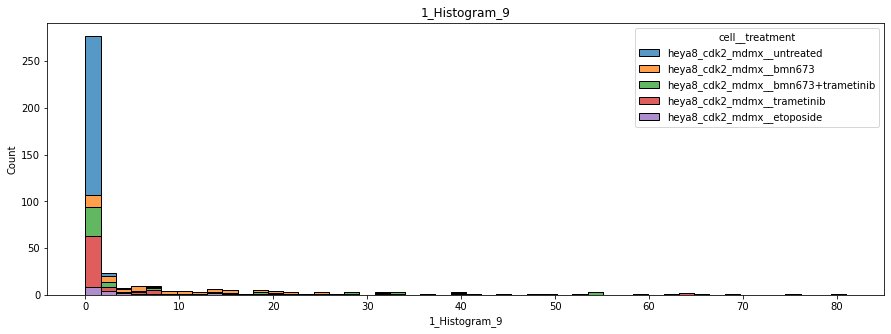

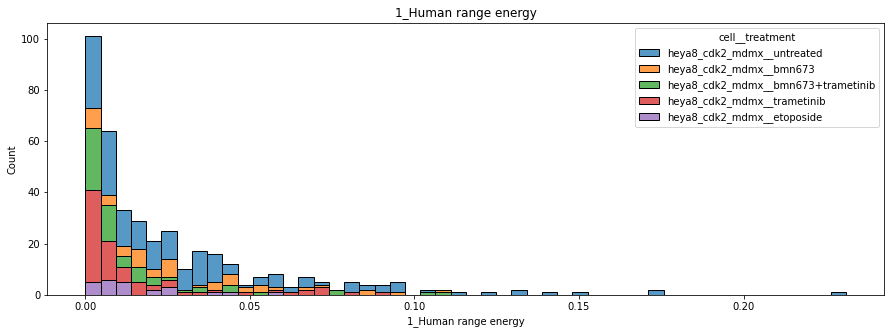

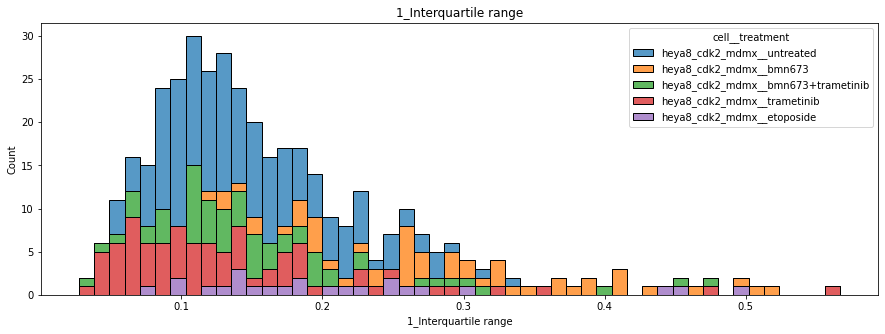

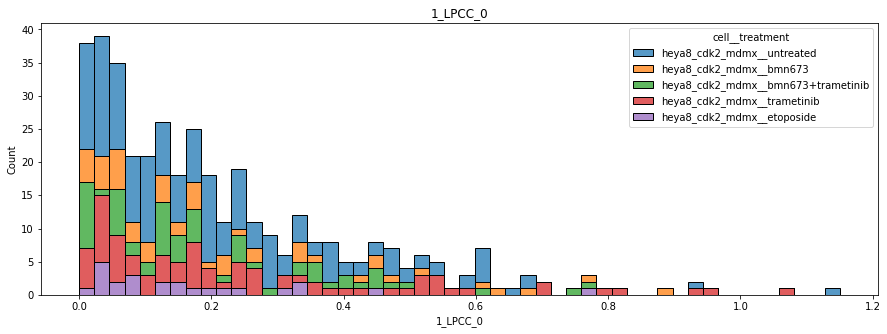

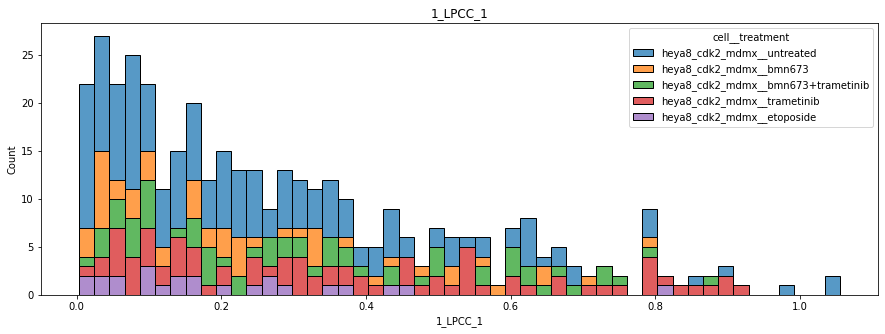

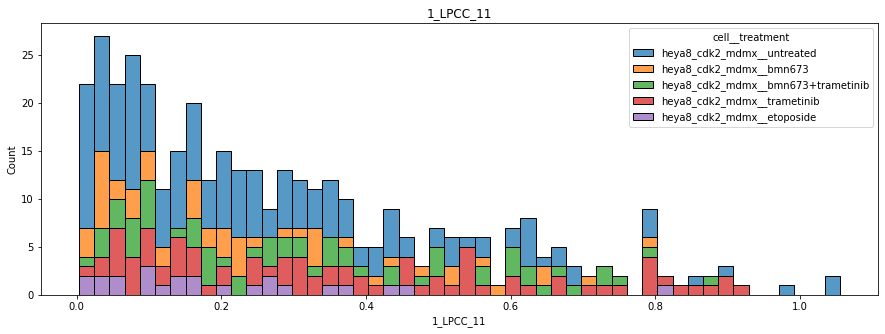

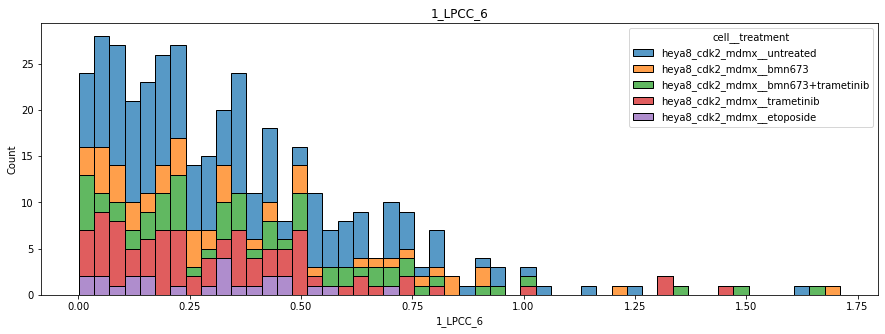

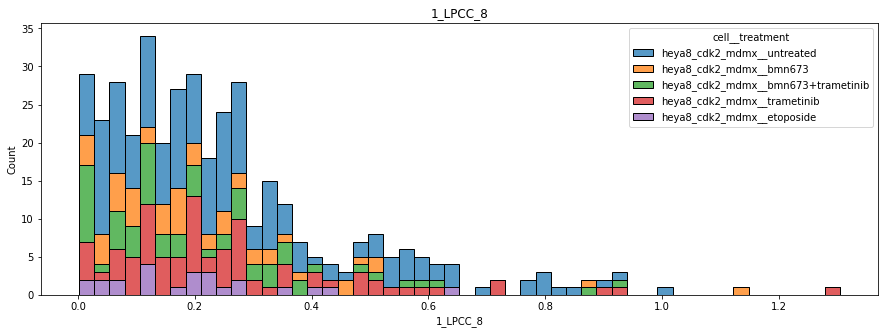

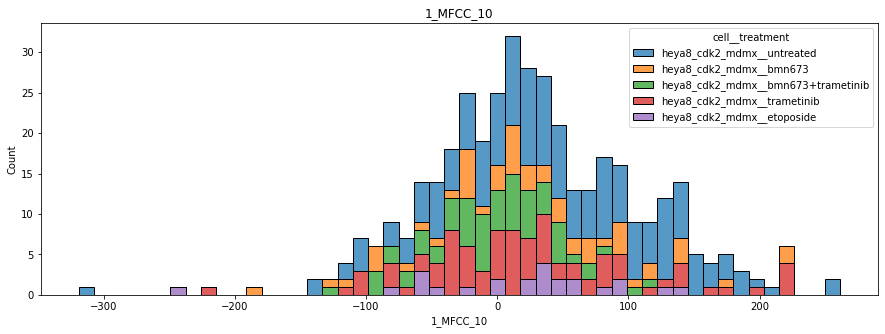

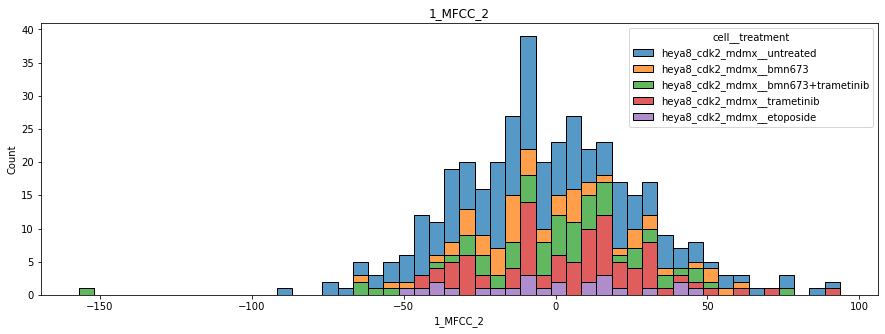

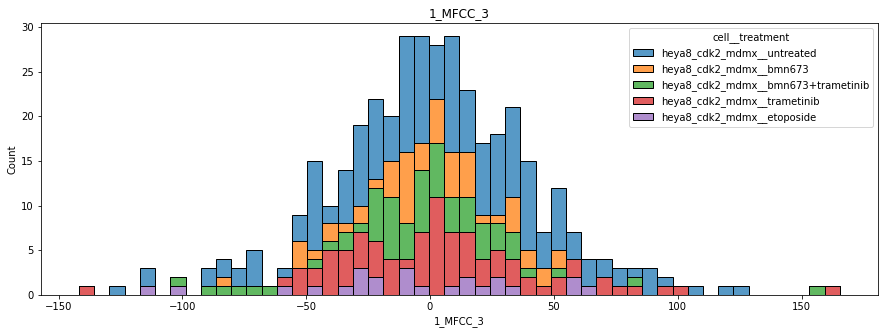

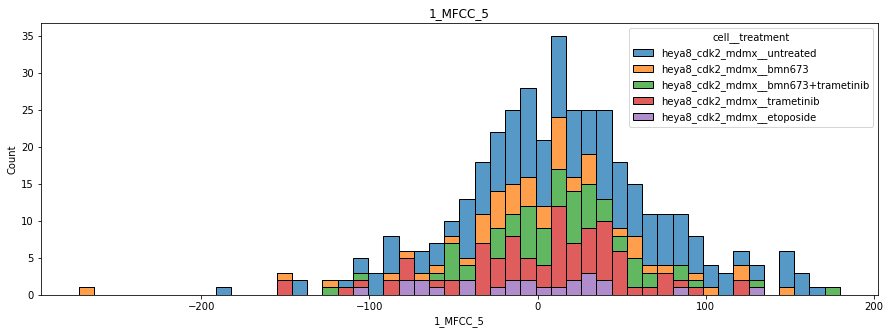

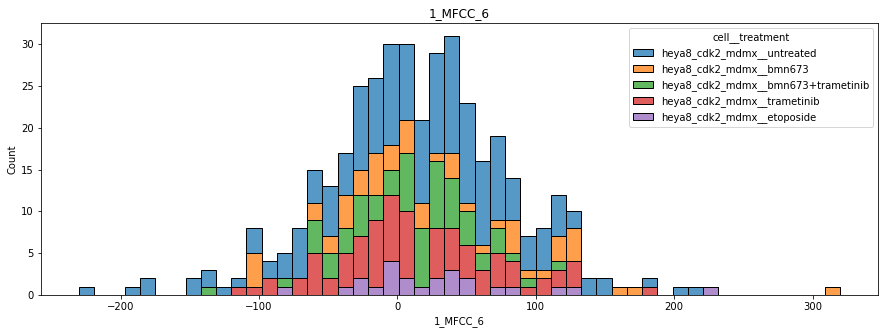

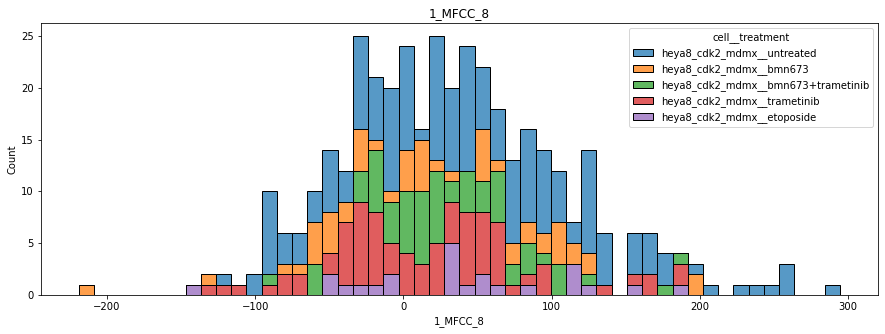

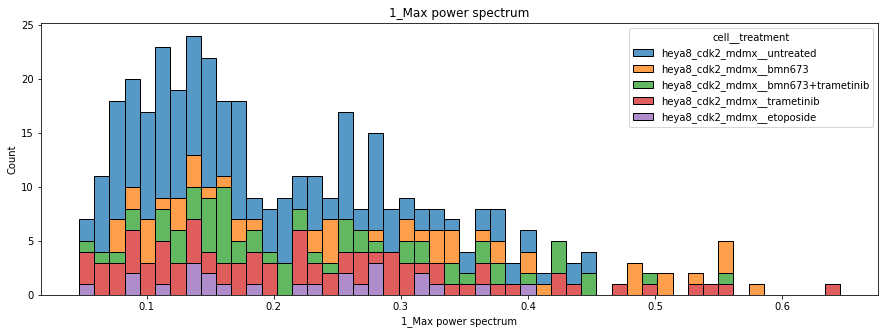

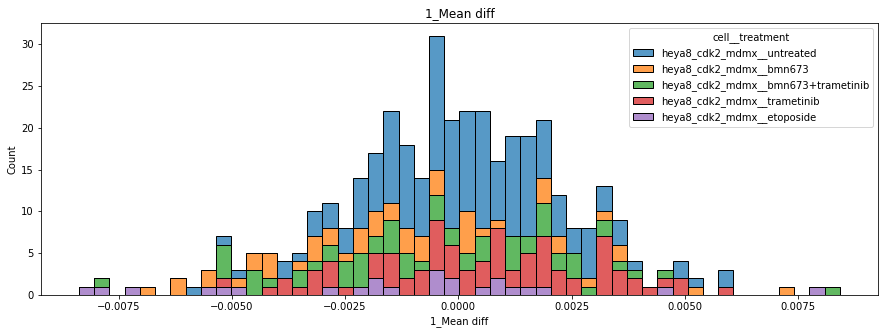

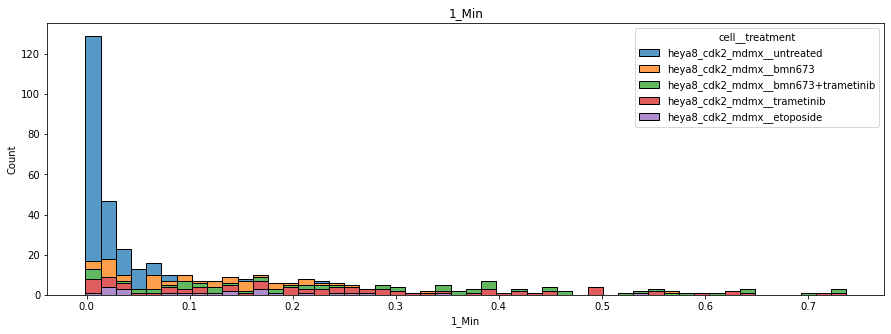

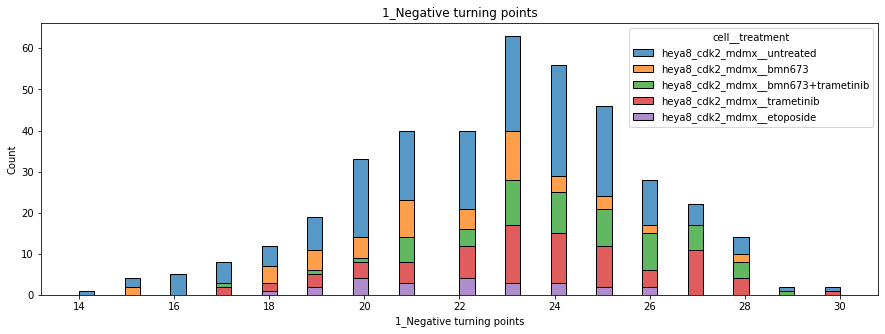

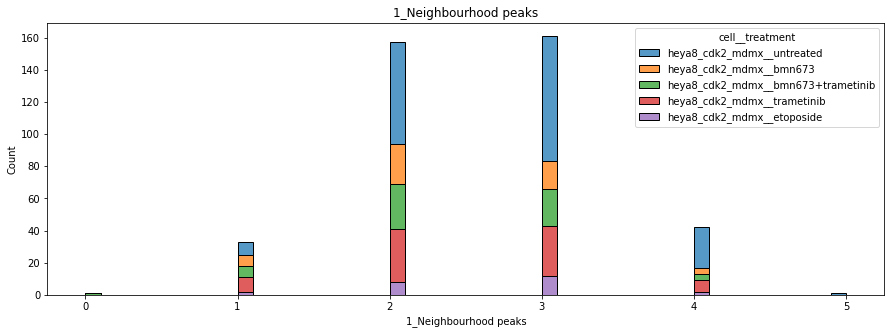

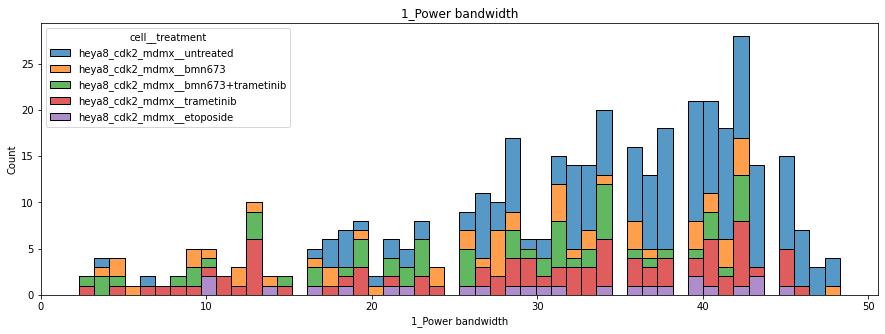

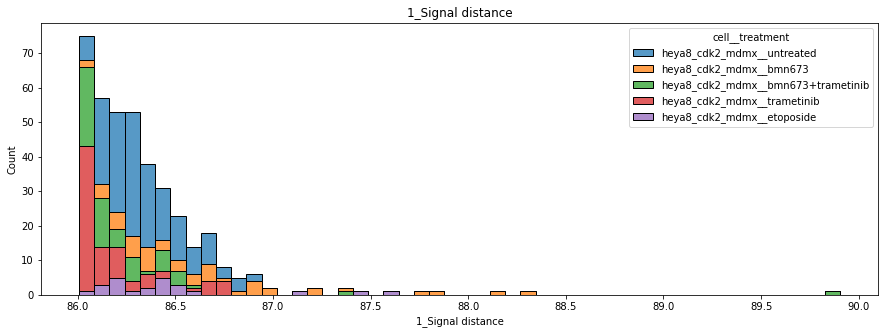

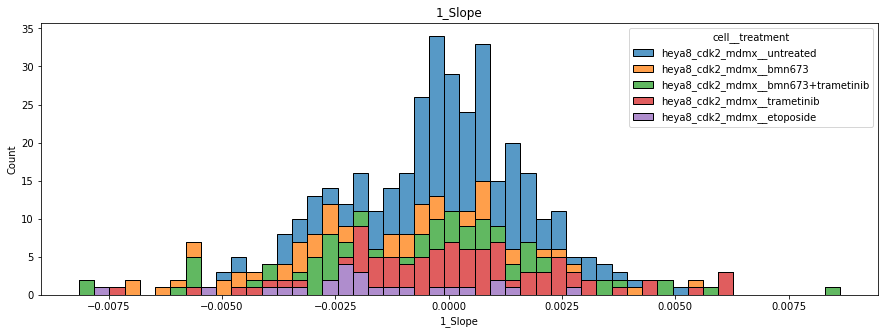

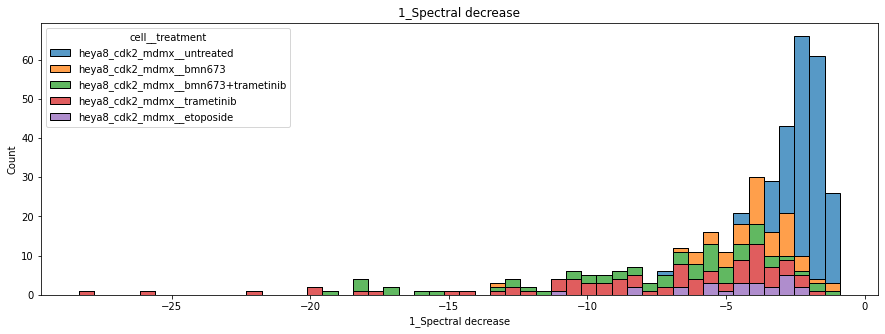

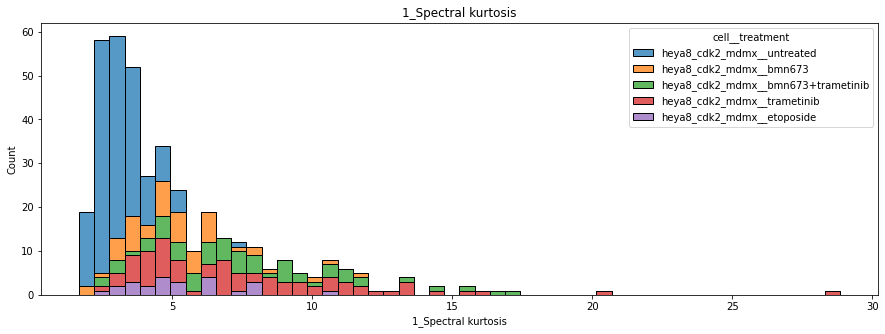

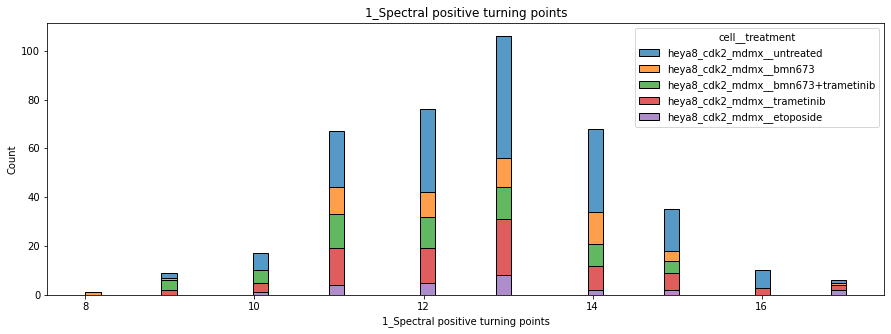

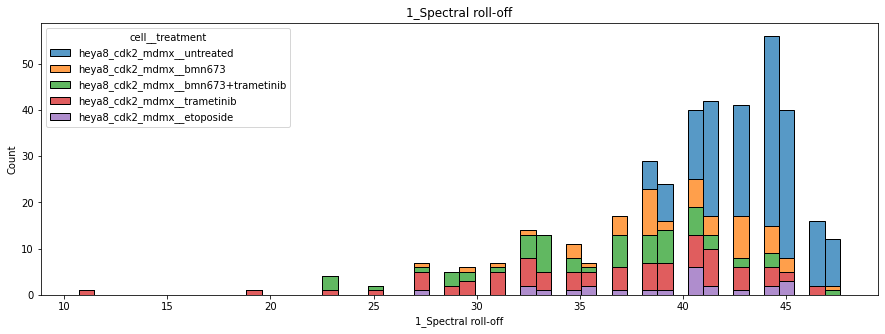

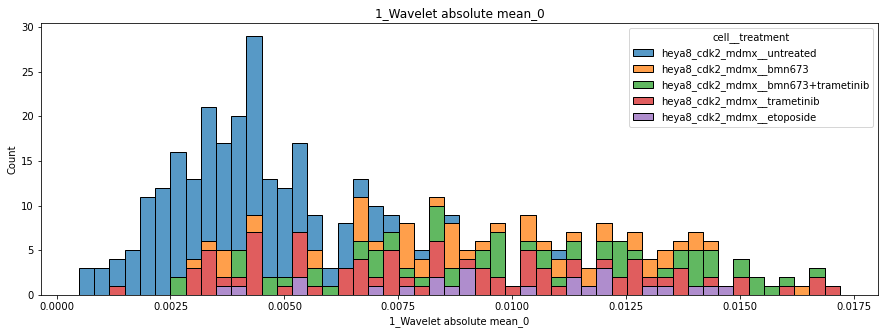

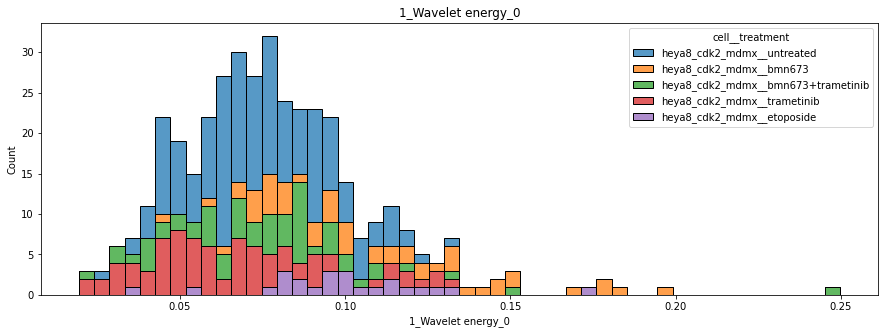

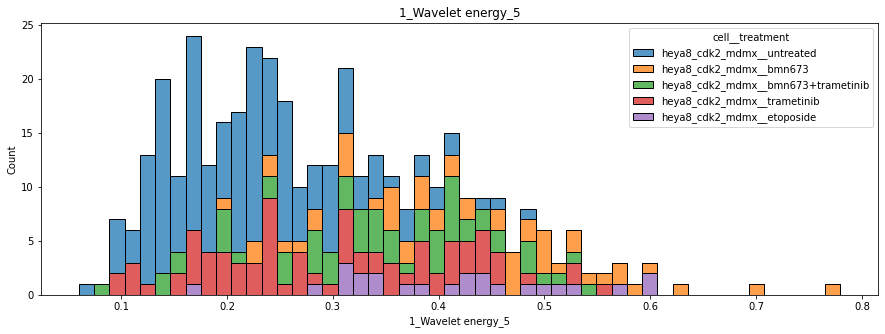

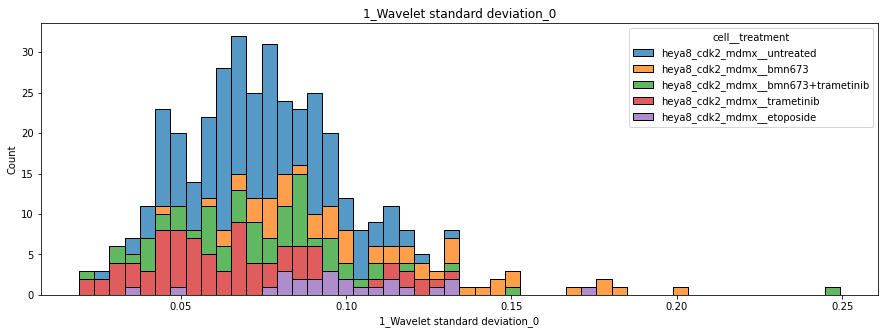

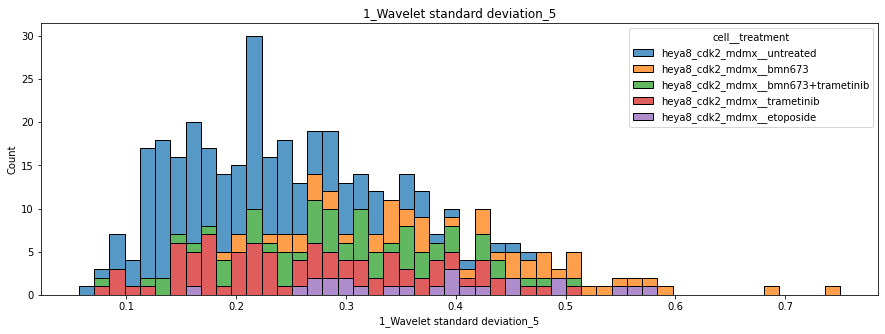

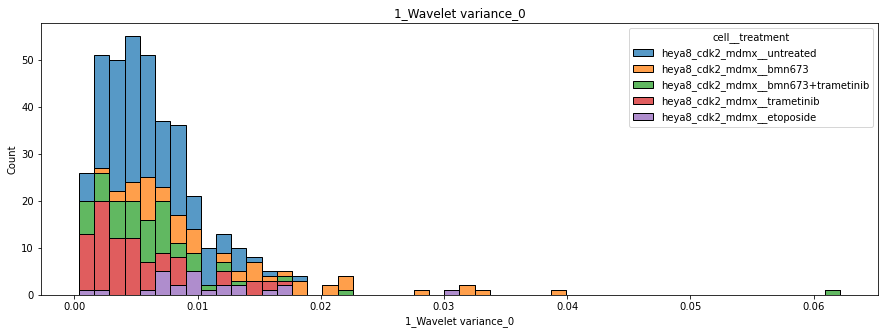

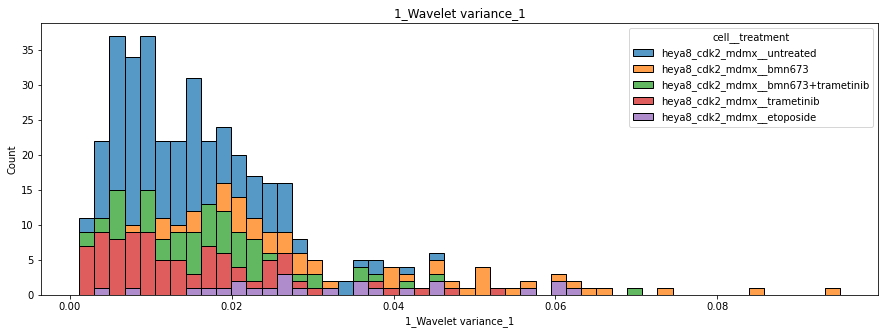

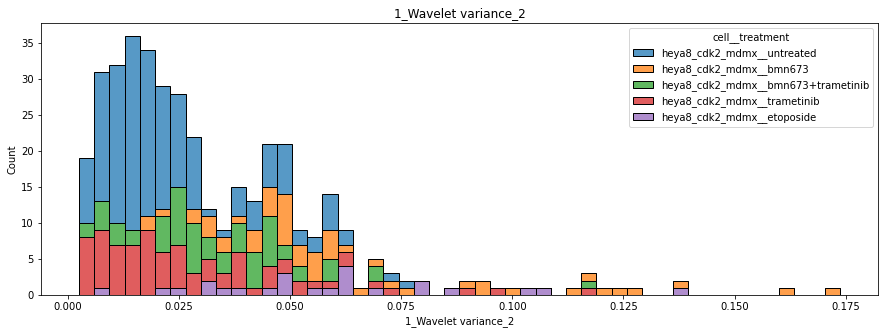

In [71]:
for feat in res2.columns[list(rfecv.get_support()) + [False, False]]: 
    plt.figure(figsize= (15,5))
    sbn.histplot(x=feat,kde=False, bins=50, hue='cell__treatment',multiple='stack', data=res)
    plt.title(feat)
    plt.show()

# umap 

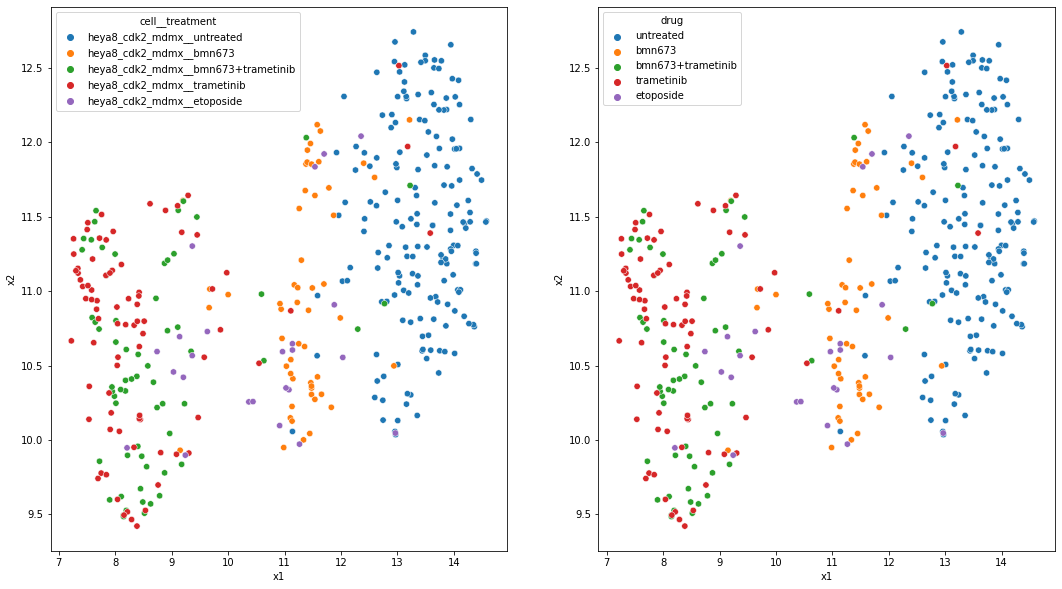

In [72]:
#scaled_res = StandardScaler().fit_transform(res[res.columns[:-2]].values)

reducer = umap.UMAP(n_neighbors=45, min_dist=0.01, n_components=2, metric='euclidean')

embedding = reducer.fit_transform(X3)# scaled_res)
embedding.shape

umap_res = pd.DataFrame(embedding).rename({0:'x1', 1:'x2'}, axis=1).assign(cell__treatment=res.cell__treatment,
                                                                          drug = [x.split('_')[-1] for x in res.cell__treatment])

f, axes = plt.subplots(1,2, figsize=(18,10))
sbn.scatterplot(x='x1', y='x2', hue='cell__treatment', data=umap_res, ax=axes[0], s=40)
sbn.scatterplot(x='x1', y='x2', hue='drug', data=umap_res, ax=axes[1], s=40)
plt.show()

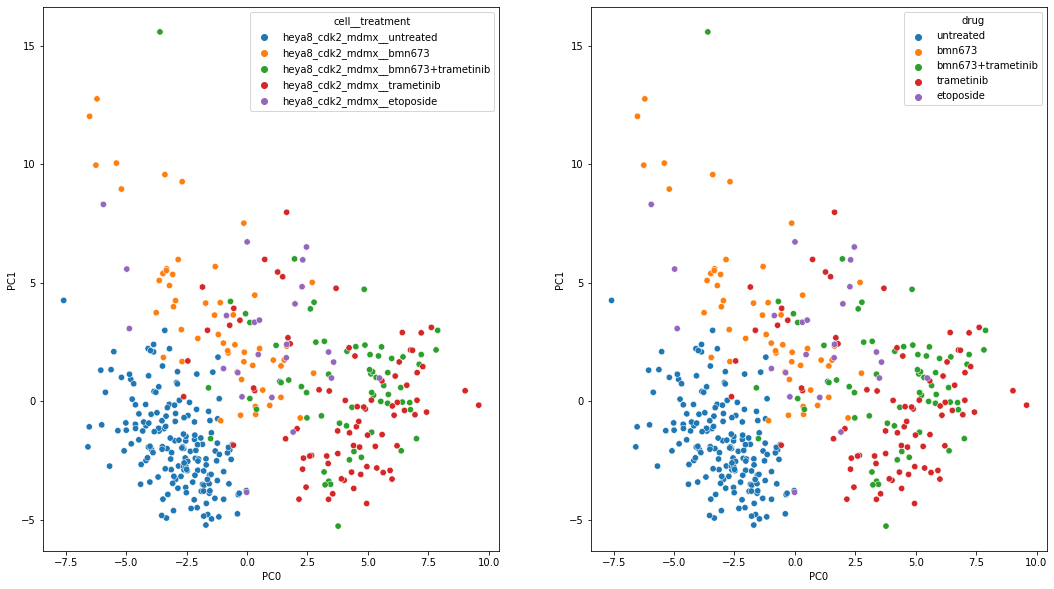

In [73]:
pca = decomposition.PCA(n_components=2)
pca.fit(X3)#scaled_res)
_X3 = pca.transform(X3)

pca_res = pd.DataFrame(_X3, columns=['PC0','PC1']).assign(cell__treatment=res.cell__treatment,
                                                         drug = [x.split('_')[-1] for x in res.cell__treatment])

f, axes = plt.subplots(1,2, figsize=(18,10))
sbn.scatterplot(x='PC0', y='PC1', hue='cell__treatment', data=pca_res, ax=axes[0], s=40)
sbn.scatterplot(x='PC0', y='PC1', hue='drug', data=pca_res, ax=axes[1], s=40)
plt.show()

# Analysis 3: Pathway Correlation 

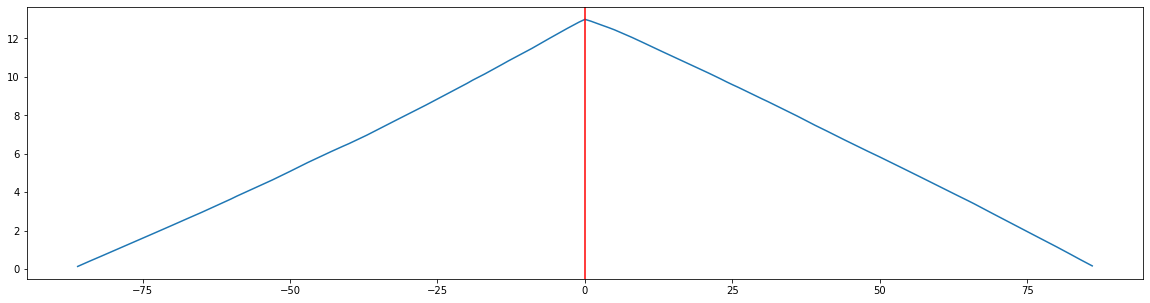

In [74]:
cc = [] 
for i, row in data.iterrows(): cc.append( np.correlate(row[data.attrs['clover_selector']].values, row[data.attrs['mscarlet_selector']].values, mode='full') )
cc = np.array(cc)
cc = cc.astype(np.float)

# Is there an overall increased cross correllation? 

shift = np.concatenate((np.arange(-len(data.attrs['clover_selector']) + 1,1,1),np.arange(1,len(data.attrs['clover_selector']),1)))
plt.figure(figsize=(20,5))
plt.plot(shift, cc.mean(axis=0))
plt.axvline(0, c='r')
plt.show()

In [75]:
res = pd.DataFrame(cc, columns=shift)
res = res.assign(cell__treatment=data.cell__treatment)
res.head()

-86       -85       -84       -83       -82       -81       -80  \
0  0.208641  0.470455  0.552382  0.794845  0.985562  1.244335  1.484061   
1  0.262185  0.389963  0.551340  0.722508  0.885652  1.010383  0.974991   
2  0.318395  0.482127  0.606083  0.743067  0.878753  1.077133  1.393017   
3  0.044501  0.103857  0.141565  0.247453  0.422155  0.664921  0.976271   
4  0.304721  0.392557  0.529110  0.586239  0.701733  0.708153  0.927971   

        -79       -78       -77  ...        78        79        80        81  \
0  1.699308  1.899953  1.999939  ...  1.015092  0.878418  0.720119  0.566729   
1  1.049989  1.340929  1.508268  ...  1.082496  0.855896  0.733438  0.618196   
2  1.504320  1.682515  1.670192  ...  1.266720  1.071116  0.964800  0.889896   
3  1.081122  1.291656  1.557550  ...  0.352878  0.293397  0.209277  0.161260   
4  1.107905  1.334572  1.502772  ...  1.954197  1.754111  1.862904  1.673054   

         82        83        84        85        86  \
0  0.443972  0.290614  0.183898  0.122912  0.079142   
1  0.510823  0.402336  0.365990  0.282343  0.183907   
2  0.791336  0.665440  0.475112  0.293650  0.137588   
3  0.111891  0.083365  0.063408  0.059265  0.024166   
4  1.338367  1.185293  0.827193  0.769690  0.548287   

              cell__treatment  
0  heya8_cdk2_mdmx__untreated  
1  heya8_cdk2_mdmx__untreated  
2  heya8_cdk2_mdmx__untreated  
3  heya8_cdk2_mdmx__untreated  
4  heya8_cdk2_mdmx__untreated  

[5 rows x 174 columns]

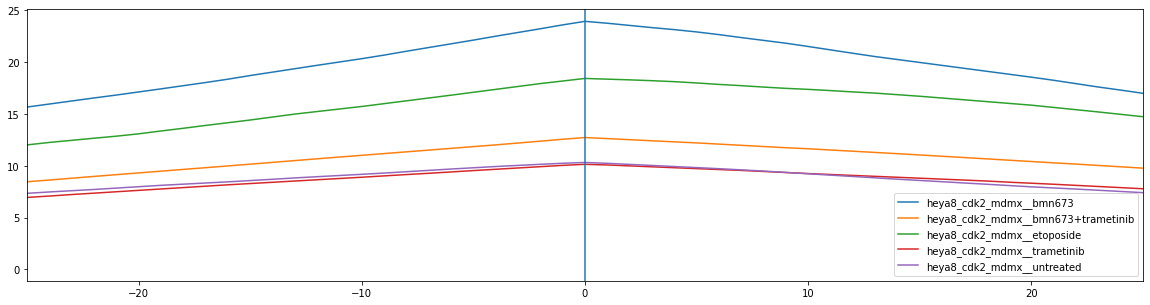

In [76]:
stats = res.groupby('cell__treatment').mean()#.reset_index()

plt.figure(figsize=(20,5))
for i,row in stats.iterrows(): 
    plt.plot(shift, row[shift], label=i)
plt.axvline(0)
plt.xlim(-25,25)
plt.legend()
plt.show()

# what is the max of each time series? 

In [77]:
#res = res.fillna(0)
res = res.assign(max_cc=[max(x) for x in res[shift].values])
res.head()

-86       -85       -84       -83       -82       -81       -80  \
0  0.208641  0.470455  0.552382  0.794845  0.985562  1.244335  1.484061   
1  0.262185  0.389963  0.551340  0.722508  0.885652  1.010383  0.974991   
2  0.318395  0.482127  0.606083  0.743067  0.878753  1.077133  1.393017   
3  0.044501  0.103857  0.141565  0.247453  0.422155  0.664921  0.976271   
4  0.304721  0.392557  0.529110  0.586239  0.701733  0.708153  0.927971   

        -79       -78       -77  ...        79        80        81        82  \
0  1.699308  1.899953  1.999939  ...  0.878418  0.720119  0.566729  0.443972   
1  1.049989  1.340929  1.508268  ...  0.855896  0.733438  0.618196  0.510823   
2  1.504320  1.682515  1.670192  ...  1.071116  0.964800  0.889896  0.791336   
3  1.081122  1.291656  1.557550  ...  0.293397  0.209277  0.161260  0.111891   
4  1.107905  1.334572  1.502772  ...  1.754111  1.862904  1.673054  1.338367   

         83        84        85        86             cell__treatment  \
0  0.290614  0.183898  0.122912  0.079142  heya8_cdk2_mdmx__untreated   
1  0.402336  0.365990  0.282343  0.183907  heya8_cdk2_mdmx__untreated   
2  0.665440  0.475112  0.293650  0.137588  heya8_cdk2_mdmx__untreated   
3  0.083365  0.063408  0.059265  0.024166  heya8_cdk2_mdmx__untreated   
4  1.185293  0.827193  0.769690  0.548287  heya8_cdk2_mdmx__untreated   

      max_cc  
0   8.748732  
1  10.055172  
2   8.874048  
3   6.940100  
4  11.262907  

[5 rows x 175 columns]

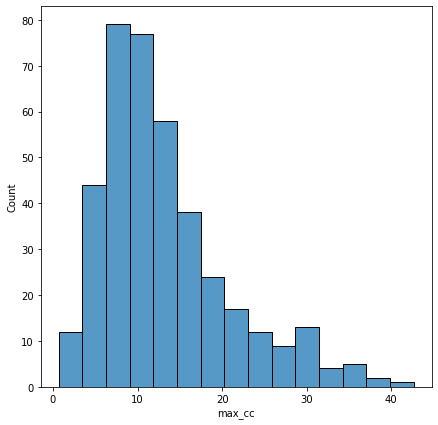

In [78]:
plt.figure(figsize=(7,7))
sbn.histplot(x='max_cc', data=res, bins=15)
plt.show()

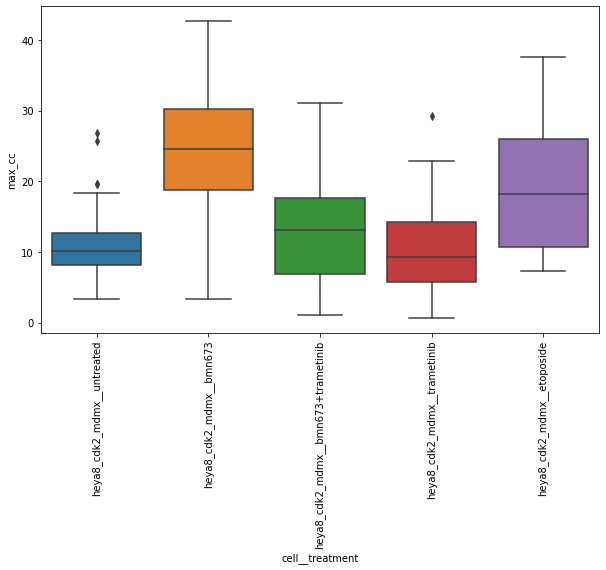

In [79]:
plt.figure(figsize=(10,6))
sbn.boxplot(y='max_cc', data=res, x='cell__treatment')
plt.xticks(rotation=90)
plt.show()

In [80]:
res.groupby('cell__treatment')['max_cc'].agg(['mean','std','count'])

mean       std  count
cell__treatment                                               
heya8_cdk2_mdmx__bmn673             24.126364  8.487238     53
heya8_cdk2_mdmx__bmn673+trametinib  12.865635  7.265543     63
heya8_cdk2_mdmx__etoposide          18.963160  9.183491     24
heya8_cdk2_mdmx__trametinib         10.316434  5.752591     80
heya8_cdk2_mdmx__untreated          10.570188  3.600869    175

# Side bar: how does this change if we look at `no shift` correllation? 

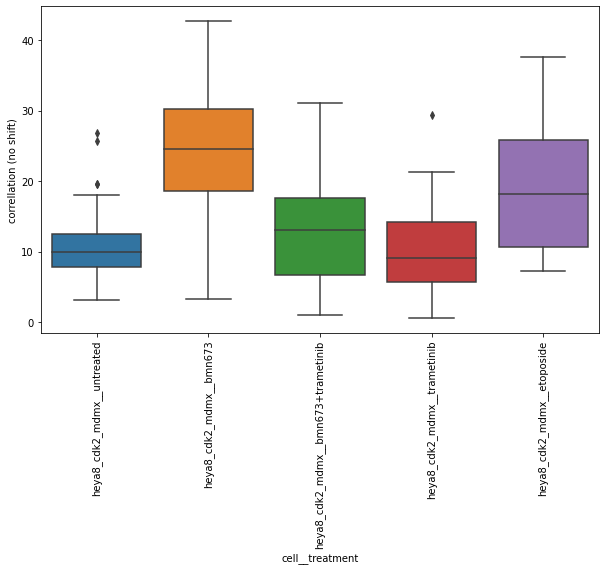

In [81]:
plt.figure(figsize=(10,6))
sbn.boxplot(y=0, data=res, x='cell__treatment')
plt.ylabel('correllation (no shift)')
plt.xticks(rotation=90)
plt.show()

# where does the maximum shift occur?

In [82]:
res = res.assign(max_idx=[shift[np.argmax(x)] for x in res[shift].values])
res.head()

-86       -85       -84       -83       -82       -81       -80  \
0  0.208641  0.470455  0.552382  0.794845  0.985562  1.244335  1.484061   
1  0.262185  0.389963  0.551340  0.722508  0.885652  1.010383  0.974991   
2  0.318395  0.482127  0.606083  0.743067  0.878753  1.077133  1.393017   
3  0.044501  0.103857  0.141565  0.247453  0.422155  0.664921  0.976271   
4  0.304721  0.392557  0.529110  0.586239  0.701733  0.708153  0.927971   

        -79       -78       -77  ...        80        81        82        83  \
0  1.699308  1.899953  1.999939  ...  0.720119  0.566729  0.443972  0.290614   
1  1.049989  1.340929  1.508268  ...  0.733438  0.618196  0.510823  0.402336   
2  1.504320  1.682515  1.670192  ...  0.964800  0.889896  0.791336  0.665440   
3  1.081122  1.291656  1.557550  ...  0.209277  0.161260  0.111891  0.083365   
4  1.107905  1.334572  1.502772  ...  1.862904  1.673054  1.338367  1.185293   

         84        85        86             cell__treatment     max_cc  \
0  0.183898  0.122912  0.079142  heya8_cdk2_mdmx__untreated   8.748732   
1  0.365990  0.282343  0.183907  heya8_cdk2_mdmx__untreated  10.055172   
2  0.475112  0.293650  0.137588  heya8_cdk2_mdmx__untreated   8.874048   
3  0.063408  0.059265  0.024166  heya8_cdk2_mdmx__untreated   6.940100   
4  0.827193  0.769690  0.548287  heya8_cdk2_mdmx__untreated  11.262907   

   max_idx  
0        0  
1        0  
2       -2  
3       -8  
4        0  

[5 rows x 176 columns]

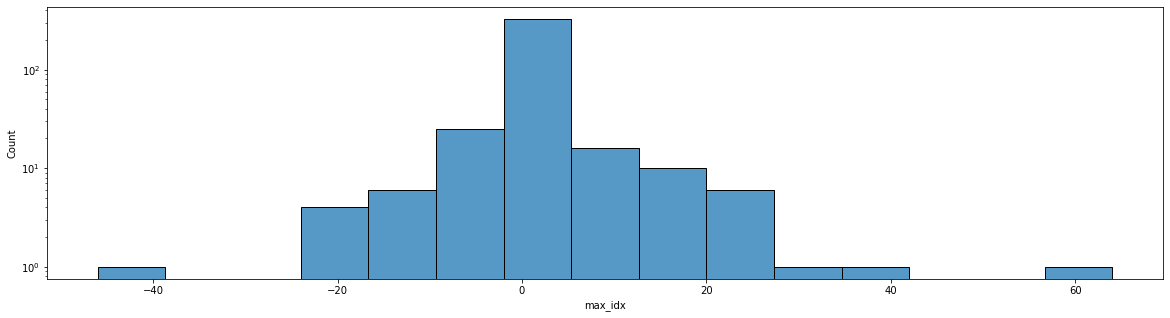

In [83]:
f, ax = plt.subplots(1,1,figsize=(20,5))
sbn.histplot(x='max_idx', data=res, bins=15)
ax.set_yscale('log')
plt.show()

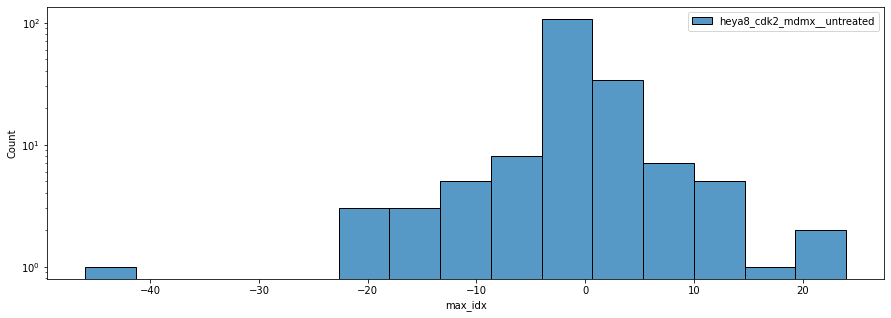

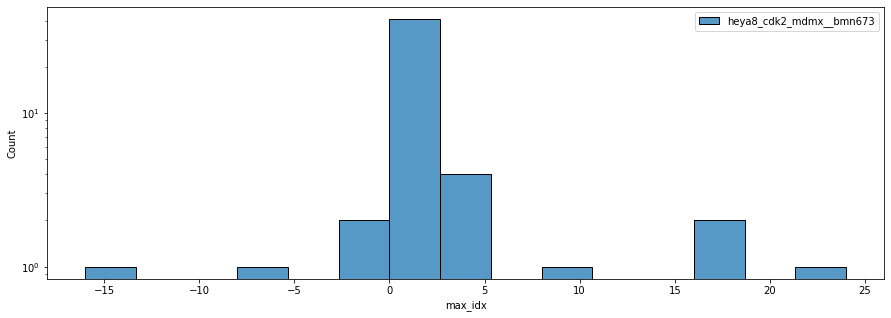

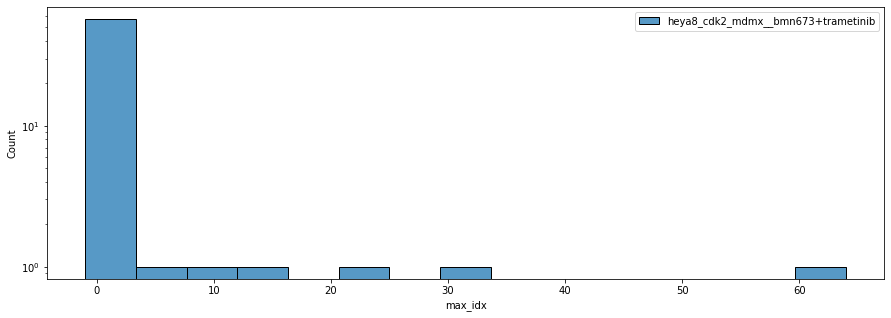

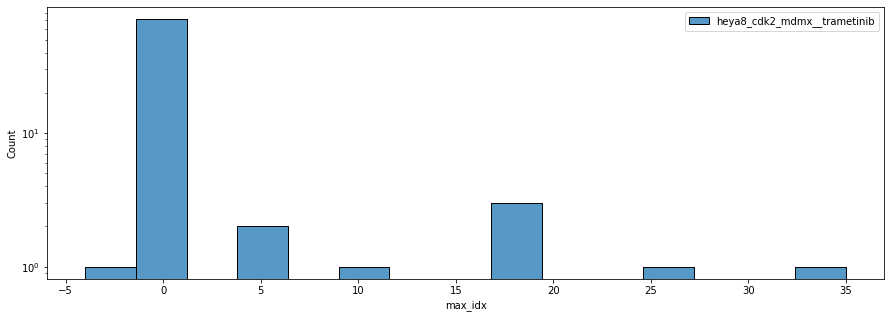

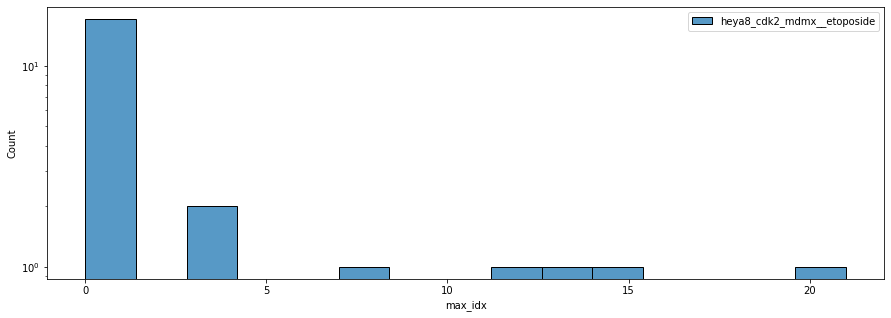

In [84]:
for ct in res.cell__treatment.unique(): 
    temp = res[res.cell__treatment == ct]
    f, ax = plt.subplots(1,1,figsize=(15,5))
    sbn.histplot(x='max_idx', data=temp, bins=15, label=ct)
    ax.set_yscale('log')
    plt.legend()
    plt.show()

# what about `max_cc` vs `max_idx`

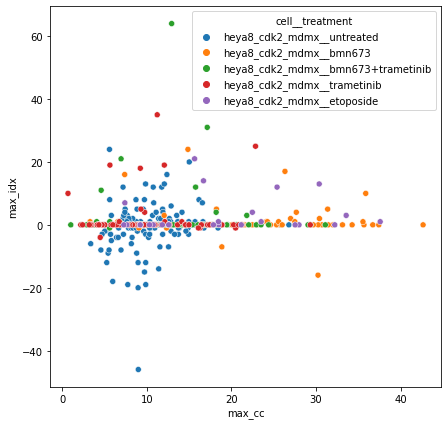

In [85]:
plt.figure(figsize=(7,7))
sbn.scatterplot(x='max_cc', y='max_idx', data=res, hue='cell__treatment')
plt.show()

# can we compare time series by the lag-lead order? e.g., does pathway A lag or lead - binarize via `max_idx` ? 

In [86]:
res = res.assign(pos_idx=lambda x: x.max_idx > 0, neg_idx=lambda x: x.max_idx < 0)

In [87]:
temp = res.groupby('cell__treatment').mean().reset_index()
temp.head()

cell__treatment       -86       -85       -84       -83  \
0             heya8_cdk2_mdmx__bmn673  0.231271  0.475224  0.739307  0.986369   
1  heya8_cdk2_mdmx__bmn673+trametinib  0.116834  0.234707  0.356215  0.468277   
2          heya8_cdk2_mdmx__etoposide  0.143856  0.291447  0.430038  0.586954   
3         heya8_cdk2_mdmx__trametinib  0.098192  0.197528  0.294249  0.388927   
4          heya8_cdk2_mdmx__untreated  0.125637  0.256416  0.368792  0.480751   

        -82       -81       -80       -79       -78  ...        81        82  \
0  1.238248  1.489592  1.725627  1.978413  2.209421  ...  1.631508  1.343992   
1  0.586285  0.706194  0.829024  0.955925  1.074645  ...  1.107930  0.930562   
2  0.754722  0.916506  1.071384  1.225890  1.388834  ...  1.617248  1.337754   
3  0.482535  0.573506  0.663575  0.757423  0.850659  ...  0.804465  0.671369   
4  0.598740  0.718121  0.834999  0.953441  1.077504  ...  0.741593  0.618562   

         83        84        85        86     max_cc   max_idx   pos_idx  \
0  1.060263  0.796795  0.532577  0.264489  24.126364  1.320755  0.320755   
1  0.754230  0.571249  0.378240  0.188371  12.865635  2.349206  0.158730   
2  1.053803  0.773462  0.512457  0.252310  18.963160  3.208333  0.416667   
3  0.532516  0.394380  0.263955  0.135748  10.316434  1.637500  0.137500   
4  0.490448  0.365326  0.244107  0.123288  10.570188 -0.428571  0.280000   

    neg_idx  
0  0.075472  
1  0.015873  
2  0.000000  
3  0.050000  
4  0.297143  

[5 rows x 178 columns]

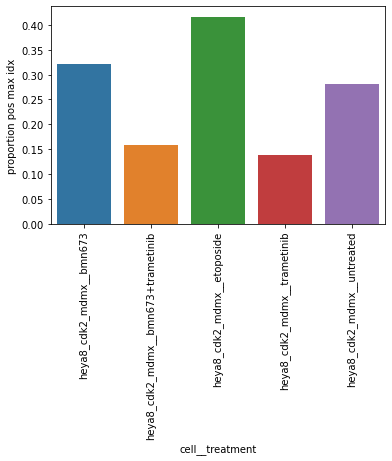

In [88]:
# proportion of positive max_idx
plt.figure()
sbn.barplot(x='cell__treatment', y='pos_idx', data=temp)
plt.ylabel('proportion pos max idx')
plt.xticks(rotation=90)
plt.show()

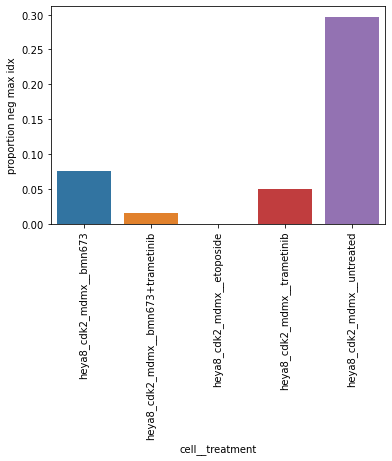

In [89]:
# proportion of positive max_idx
plt.figure()
sbn.barplot(x='cell__treatment', y='neg_idx', data=temp)
plt.ylabel('proportion neg max idx')
plt.xticks(rotation=90)
plt.show()